In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Network Definition

In [2]:
kernel_size=(3,3)  
in_channel_0=1
out_channel_0=64 
in_channel_1=out_channel_0
out_channel_1=64
input_length = 7*7*out_channel_1
hidden_0 = 64   
output_length = 10 

In [3]:
class CNN(nn.Module):
    def __init__(self, dropout=0.5):
        super(CNN, self).__init__()
        
        self.conv0 = nn.Conv2d( 
                         in_channels=in_channel_0,
                         out_channels=out_channel_0,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1
                     )
        
        self.bn0   = nn.BatchNorm2d(out_channel_0)
        self.act0  = nn.SiLU()
        
        self.drop0 = nn.Dropout(dropout)
        
        self.pool0 = nn.MaxPool2d(2)
        
        self.conv1 = nn.Conv2d( 
                         in_channels=in_channel_1,
                         out_channels=out_channel_1,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1
                     )
        
        self.bn1   = nn.BatchNorm2d(out_channel_1)
        self.act1  = nn.SiLU()
        self.drop1 = nn.Dropout(dropout)
        
        self.pool1 = nn.MaxPool2d(2)
        
        self.fc2   = nn.Linear(input_length, hidden_0)
        
        self.bn2   = nn.BatchNorm1d(hidden_0)
        self.act2  = nn.SiLU()
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = nn.Linear(hidden_0, output_length)

    def forward(self, x):
        out = self.pool0(self.drop0(self.act0(self.bn0(self.conv0(x)))))
        out = self.pool1(self.drop1(self.act1(self.bn1(self.conv1(out)))))
        out = out.reshape(out.shape[0], -1)
        out = self.drop2(self.act2(self.bn2(self.fc2(out))))
        out = self.out(out)
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model = CNN(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
        
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1031, Acc: 0.9693 | Val Loss: 0.0517, Acc: 0.9846


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9867 | Val Loss: 0.0444, Acc: 0.9867


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9898 | Val Loss: 0.0542, Acc: 0.9849


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.0422, Acc: 0.9869


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9934 | Val Loss: 0.0371, Acc: 0.9894


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.0495, Acc: 0.9885


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0603, Acc: 0.9849


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.0422, Acc: 0.9889


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0514, Acc: 0.9877


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0397, Acc: 0.9915


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0471, Acc: 0.9891


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0564, Acc: 0.9875


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0469, Acc: 0.9901


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0494, Acc: 0.9901


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0439, Acc: 0.9916


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0553, Acc: 0.9893


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0406, Acc: 0.9924


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0547, Acc: 0.9897


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0491, Acc: 0.9917


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0571, Acc: 0.9907


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0560, Acc: 0.9918


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0603, Acc: 0.9912


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.0524, Acc: 0.9909


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0549, Acc: 0.9900


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0516, Acc: 0.9918


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0540, Acc: 0.9915


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0568, Acc: 0.9902


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0619, Acc: 0.9904


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0492, Acc: 0.9915


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0504, Acc: 0.9924


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0587, Acc: 0.9914


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0822, Acc: 0.9888


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.0574, Acc: 0.9914


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0531, Acc: 0.9927


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0571, Acc: 0.9917


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0538, Acc: 0.9922


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0703, Acc: 0.9906


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0662, Acc: 0.9908


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0618, Acc: 0.9916


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0736, Acc: 0.9896


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0641, Acc: 0.9922


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0624, Acc: 0.9919


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0650, Acc: 0.9917


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0655, Acc: 0.9912


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0690, Acc: 0.9915


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0801, Acc: 0.9895


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0733, Acc: 0.9912


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0897, Acc: 0.9911


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.0702, Acc: 0.9921


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0640, Acc: 0.9927


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0591, Acc: 0.9928


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0660, Acc: 0.9926


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0745, Acc: 0.9912


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.0617, Acc: 0.9920


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0645, Acc: 0.9922


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0763, Acc: 0.9910


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.0816, Acc: 0.9906


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0811, Acc: 0.9919


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.0712, Acc: 0.9919


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0886, Acc: 0.9911


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0893, Acc: 0.9915


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.0844, Acc: 0.9924


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9993 | Val Loss: 0.0758, Acc: 0.9910


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0668, Acc: 0.9930


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0799, Acc: 0.9921


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9995 | Val Loss: 0.0761, Acc: 0.9918


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0739, Acc: 0.9926


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0882, Acc: 0.9917


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.0823, Acc: 0.9933


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0775, Acc: 0.9925


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0983, Acc: 0.9916


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0786, Acc: 0.9922


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0931, Acc: 0.9922


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0914, Acc: 0.9918


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0815, Acc: 0.9919


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9996 | Val Loss: 0.0874, Acc: 0.9908


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.0911, Acc: 0.9924


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9992 | Val Loss: 0.0853, Acc: 0.9918


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.0774, Acc: 0.9922


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1019, Acc: 0.9902


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0869, Acc: 0.9923


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0772, Acc: 0.9929


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0873, Acc: 0.9926


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9990 | Val Loss: 0.0869, Acc: 0.9910


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.0857, Acc: 0.9917


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0849, Acc: 0.9920


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0765, Acc: 0.9930


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1169, Acc: 0.9899


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0993, Acc: 0.9917


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0951, Acc: 0.9919


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.0972, Acc: 0.9918


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9994 | Val Loss: 0.0837, Acc: 0.9931


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0803, Acc: 0.9935


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0865, Acc: 0.9919


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.0910, Acc: 0.9925


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9997 | Val Loss: 0.1005, Acc: 0.9925


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1006, Acc: 0.9921


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1093, Acc: 0.9922


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9992 | Val Loss: 0.1020, Acc: 0.9918


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.0959, Acc: 0.9922


Final Test Loss: 0.0951 Accuracy: 0.9920


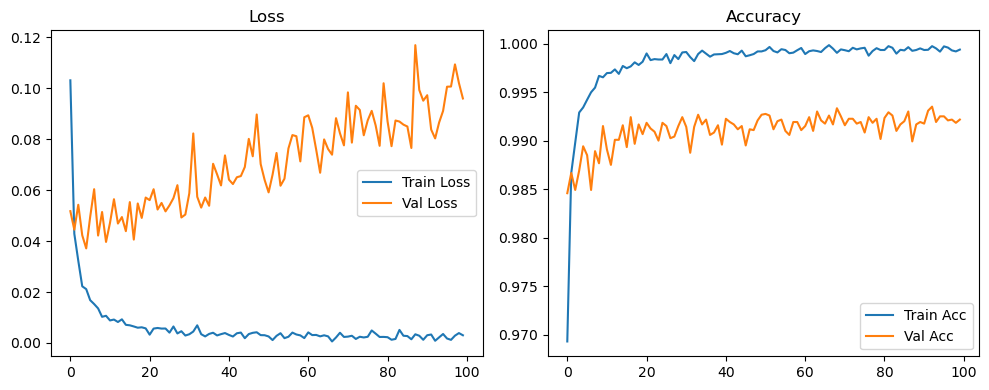

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1222, Acc: 0.9637 | Val Loss: 0.0701, Acc: 0.9788


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9821 | Val Loss: 0.0440, Acc: 0.9859


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9860 | Val Loss: 0.0452, Acc: 0.9861


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9886 | Val Loss: 0.0502, Acc: 0.9844


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9896 | Val Loss: 0.0428, Acc: 0.9870


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.0519, Acc: 0.9841


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9918 | Val Loss: 0.0531, Acc: 0.9840


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9922 | Val Loss: 0.0358, Acc: 0.9892


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0350, Acc: 0.9888


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.0306, Acc: 0.9908


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.0370, Acc: 0.9892


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0364, Acc: 0.9902


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0321, Acc: 0.9909


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0352, Acc: 0.9902


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0383, Acc: 0.9893


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0350, Acc: 0.9898


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0522, Acc: 0.9852


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0338, Acc: 0.9908


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0369, Acc: 0.9902


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0334, Acc: 0.9912


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0421, Acc: 0.9882


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0401, Acc: 0.9886


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0389, Acc: 0.9891


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9965 | Val Loss: 0.0411, Acc: 0.9904


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9963 | Val Loss: 0.0409, Acc: 0.9902


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0391, Acc: 0.9896


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0356, Acc: 0.9914


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0387, Acc: 0.9908


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0515, Acc: 0.9882


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0377, Acc: 0.9912


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0316, Acc: 0.9921


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0303, Acc: 0.9919


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0315, Acc: 0.9916


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0408, Acc: 0.9903


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0363, Acc: 0.9924


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0308, Acc: 0.9922


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0378, Acc: 0.9905


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0339, Acc: 0.9919


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0426, Acc: 0.9901


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0355, Acc: 0.9908


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0339, Acc: 0.9918


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0344, Acc: 0.9918


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0325, Acc: 0.9914


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0363, Acc: 0.9918


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0366, Acc: 0.9919


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.0347, Acc: 0.9918


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0347, Acc: 0.9915


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0353, Acc: 0.9920


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0319, Acc: 0.9919


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0330, Acc: 0.9923


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0469, Acc: 0.9901


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0337, Acc: 0.9921


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0381, Acc: 0.9905


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0408, Acc: 0.9900


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0388, Acc: 0.9903


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0416, Acc: 0.9904


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.0396, Acc: 0.9917


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0373, Acc: 0.9916


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0381, Acc: 0.9916


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0498, Acc: 0.9891


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0386, Acc: 0.9905


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0344, Acc: 0.9912


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0341, Acc: 0.9922


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0366, Acc: 0.9915


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.0369, Acc: 0.9914


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0348, Acc: 0.9915


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0362, Acc: 0.9907


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0350, Acc: 0.9911


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0432, Acc: 0.9908


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0366, Acc: 0.9903


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.0385, Acc: 0.9901


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0403, Acc: 0.9899


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0320, Acc: 0.9919


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.0355, Acc: 0.9912


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0397, Acc: 0.9892


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0386, Acc: 0.9903


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0314, Acc: 0.9926


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.0361, Acc: 0.9913


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0470, Acc: 0.9887


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0370, Acc: 0.9917


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9984 | Val Loss: 0.0410, Acc: 0.9912


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.0343, Acc: 0.9916


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0342, Acc: 0.9911


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9984 | Val Loss: 0.0354, Acc: 0.9918


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.0440, Acc: 0.9902


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0373, Acc: 0.9919


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0353, Acc: 0.9910


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9983 | Val Loss: 0.0374, Acc: 0.9909


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.0400, Acc: 0.9901


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0401, Acc: 0.9901


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0387, Acc: 0.9900


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0397, Acc: 0.9901


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0361, Acc: 0.9910


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0405, Acc: 0.9913


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0413, Acc: 0.9898


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0377, Acc: 0.9914


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.0425, Acc: 0.9902


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9984 | Val Loss: 0.0396, Acc: 0.9896


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.0429, Acc: 0.9896


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0383, Acc: 0.9896


Final Test Loss: 0.0351 Accuracy: 0.9901


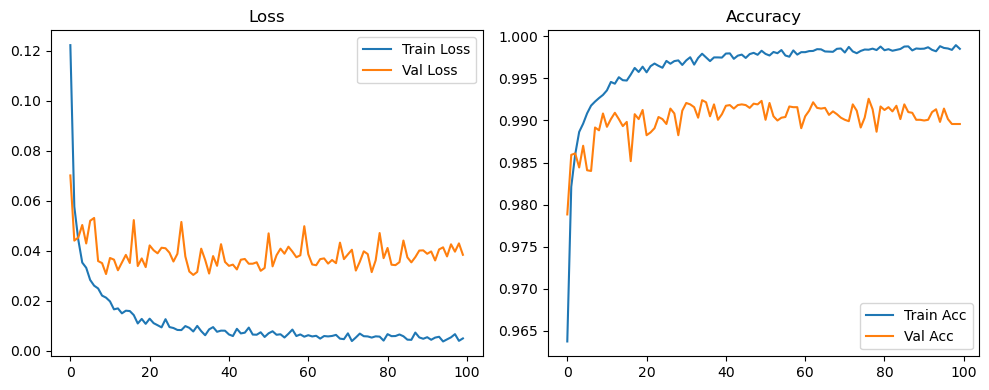

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1874, Acc: 0.9463 | Val Loss: 0.3582, Acc: 0.8833


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0968, Acc: 0.9713 | Val Loss: 0.3477, Acc: 0.8773


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9756 | Val Loss: 0.1854, Acc: 0.9391


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9783 | Val Loss: 0.1269, Acc: 0.9597


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9808 | Val Loss: 0.0916, Acc: 0.9738


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0614, Acc: 0.9806 | Val Loss: 0.1395, Acc: 0.9556


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9819 | Val Loss: 0.0830, Acc: 0.9769


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9831 | Val Loss: 0.1102, Acc: 0.9661


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9843 | Val Loss: 0.0599, Acc: 0.9832


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9853 | Val Loss: 0.0852, Acc: 0.9751


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9843 | Val Loss: 0.0916, Acc: 0.9725


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9858 | Val Loss: 0.0844, Acc: 0.9754


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9863 | Val Loss: 0.0826, Acc: 0.9756


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9868 | Val Loss: 0.0607, Acc: 0.9818


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9874 | Val Loss: 0.0571, Acc: 0.9833


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9866 | Val Loss: 0.0743, Acc: 0.9774


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9883 | Val Loss: 0.0996, Acc: 0.9688


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9875 | Val Loss: 0.0946, Acc: 0.9705


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9880 | Val Loss: 0.0730, Acc: 0.9783


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9890 | Val Loss: 0.0659, Acc: 0.9804


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9891 | Val Loss: 0.1089, Acc: 0.9662


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9892 | Val Loss: 0.0928, Acc: 0.9697


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9883 | Val Loss: 0.0877, Acc: 0.9736


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9898 | Val Loss: 0.0536, Acc: 0.9850


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9895 | Val Loss: 0.0928, Acc: 0.9718


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9895 | Val Loss: 0.0794, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9902 | Val Loss: 0.0672, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9898 | Val Loss: 0.0732, Acc: 0.9768


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9899 | Val Loss: 0.0574, Acc: 0.9827


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.0475, Acc: 0.9872


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9904 | Val Loss: 0.0668, Acc: 0.9808


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9898 | Val Loss: 0.0566, Acc: 0.9838


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9906 | Val Loss: 0.0471, Acc: 0.9873


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9909 | Val Loss: 0.0622, Acc: 0.9817


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.0676, Acc: 0.9794


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.0541, Acc: 0.9835


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9906 | Val Loss: 0.0701, Acc: 0.9781


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9908 | Val Loss: 0.0422, Acc: 0.9889


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9911 | Val Loss: 0.0480, Acc: 0.9868


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9918 | Val Loss: 0.0441, Acc: 0.9880


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9908 | Val Loss: 0.0543, Acc: 0.9854


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.0656, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9920 | Val Loss: 0.0573, Acc: 0.9830


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.0441, Acc: 0.9870


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9913 | Val Loss: 0.0485, Acc: 0.9868


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9913 | Val Loss: 0.0466, Acc: 0.9881


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9918 | Val Loss: 0.0463, Acc: 0.9866


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.0563, Acc: 0.9849


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.0670, Acc: 0.9802


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.0697, Acc: 0.9801


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9927 | Val Loss: 0.0475, Acc: 0.9868


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9915 | Val Loss: 0.0627, Acc: 0.9824


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9923 | Val Loss: 0.0643, Acc: 0.9809


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9926 | Val Loss: 0.0444, Acc: 0.9890


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9922 | Val Loss: 0.0471, Acc: 0.9867


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9927 | Val Loss: 0.0467, Acc: 0.9873


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9930 | Val Loss: 0.0547, Acc: 0.9835


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9924 | Val Loss: 0.0677, Acc: 0.9792


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.0381, Acc: 0.9896


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.0441, Acc: 0.9870


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9924 | Val Loss: 0.0495, Acc: 0.9864


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9926 | Val Loss: 0.0839, Acc: 0.9766


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9930 | Val Loss: 0.0371, Acc: 0.9886


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9933 | Val Loss: 0.0549, Acc: 0.9845


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.0478, Acc: 0.9866


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9934 | Val Loss: 0.0522, Acc: 0.9857


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9927 | Val Loss: 0.0434, Acc: 0.9887


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.0715, Acc: 0.9804


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.0624, Acc: 0.9811


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0569, Acc: 0.9858


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9930 | Val Loss: 0.0597, Acc: 0.9824


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0552, Acc: 0.9832


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0720, Acc: 0.9772


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9935 | Val Loss: 0.0694, Acc: 0.9808


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9931 | Val Loss: 0.0676, Acc: 0.9812


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0630, Acc: 0.9822


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.0356, Acc: 0.9904


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.0423, Acc: 0.9887


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9931 | Val Loss: 0.0764, Acc: 0.9771


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.0422, Acc: 0.9887


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9936 | Val Loss: 0.0525, Acc: 0.9852


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.0558, Acc: 0.9849


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.0621, Acc: 0.9840


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9933 | Val Loss: 0.0613, Acc: 0.9832


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0424, Acc: 0.9874


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9938 | Val Loss: 0.0632, Acc: 0.9824


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9939 | Val Loss: 0.0527, Acc: 0.9868


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0641, Acc: 0.9816


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.0568, Acc: 0.9837


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9934 | Val Loss: 0.0498, Acc: 0.9854


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9937 | Val Loss: 0.0601, Acc: 0.9826


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0573, Acc: 0.9837


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.0409, Acc: 0.9896


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0423, Acc: 0.9891


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0562, Acc: 0.9861


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9943 | Val Loss: 0.0553, Acc: 0.9857


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9936 | Val Loss: 0.0705, Acc: 0.9809


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0611, Acc: 0.9838


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.0504, Acc: 0.9868


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.0580, Acc: 0.9849


Final Test Loss: 0.0552 Accuracy: 0.9860


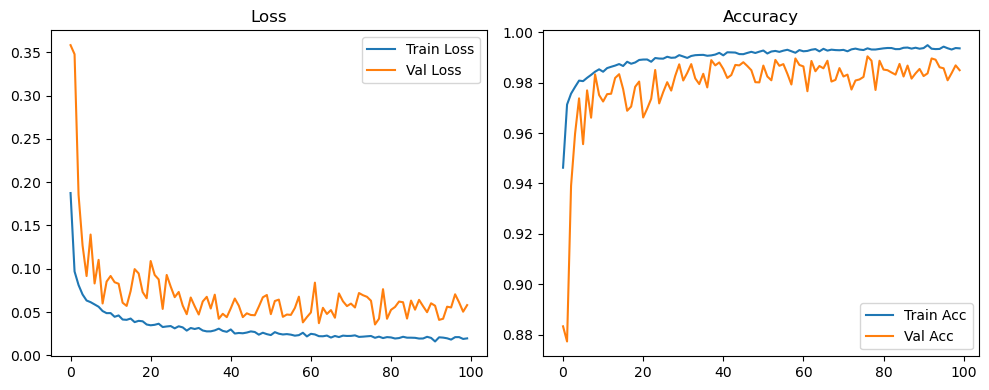

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1028, Acc: 0.9689 | Val Loss: 0.0512, Acc: 0.9850


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9867 | Val Loss: 0.0440, Acc: 0.9858


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9897 | Val Loss: 0.0414, Acc: 0.9876


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9925 | Val Loss: 0.0406, Acc: 0.9889


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0380, Acc: 0.9891


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.0505, Acc: 0.9873


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0485, Acc: 0.9891


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0388, Acc: 0.9912


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0436, Acc: 0.9900


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0539, Acc: 0.9885


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0404, Acc: 0.9903


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0482, Acc: 0.9902


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0467, Acc: 0.9901


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0465, Acc: 0.9897


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0462, Acc: 0.9897


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0487, Acc: 0.9897


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0442, Acc: 0.9913


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0461, Acc: 0.9900


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0502, Acc: 0.9905


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0603, Acc: 0.9904


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0568, Acc: 0.9907


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0572, Acc: 0.9901


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0593, Acc: 0.9897


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0473, Acc: 0.9908


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0529, Acc: 0.9906


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0505, Acc: 0.9920


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0501, Acc: 0.9912


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0594, Acc: 0.9904


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0508, Acc: 0.9910


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0555, Acc: 0.9915


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0565, Acc: 0.9910


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0512, Acc: 0.9918


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0581, Acc: 0.9910


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0575, Acc: 0.9918


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.0531, Acc: 0.9927


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0783, Acc: 0.9895


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0684, Acc: 0.9904


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0662, Acc: 0.9917


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0646, Acc: 0.9921


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0861, Acc: 0.9904


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9988 | Val Loss: 0.0639, Acc: 0.9918


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0643, Acc: 0.9916


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.0671, Acc: 0.9917


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0630, Acc: 0.9918


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0621, Acc: 0.9915


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0648, Acc: 0.9915


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0662, Acc: 0.9911


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0678, Acc: 0.9904


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0758, Acc: 0.9906


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0745, Acc: 0.9917


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0590, Acc: 0.9930


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0554, Acc: 0.9937


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0536, Acc: 0.9928


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0563, Acc: 0.9925


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0595, Acc: 0.9925


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0699, Acc: 0.9918


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0612, Acc: 0.9928


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0589, Acc: 0.9928


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0706, Acc: 0.9921


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0722, Acc: 0.9917


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0686, Acc: 0.9916


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0774, Acc: 0.9916


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0704, Acc: 0.9930


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0730, Acc: 0.9930


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0846, Acc: 0.9918


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0829, Acc: 0.9922


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0785, Acc: 0.9923


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.0792, Acc: 0.9920


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0769, Acc: 0.9922


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0814, Acc: 0.9918


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0788, Acc: 0.9919


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0765, Acc: 0.9913


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0713, Acc: 0.9928


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0821, Acc: 0.9918


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0813, Acc: 0.9932


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0787, Acc: 0.9932


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0755, Acc: 0.9919


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0857, Acc: 0.9917


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0745, Acc: 0.9920


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0737, Acc: 0.9921


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0696, Acc: 0.9928


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0743, Acc: 0.9929


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0747, Acc: 0.9929


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0749, Acc: 0.9927


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0763, Acc: 0.9930


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0731, Acc: 0.9931


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0733, Acc: 0.9931


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0739, Acc: 0.9935


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0737, Acc: 0.9930


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0716, Acc: 0.9931


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0677, Acc: 0.9935


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0732, Acc: 0.9925


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0703, Acc: 0.9930


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0739, Acc: 0.9929


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0736, Acc: 0.9931


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0753, Acc: 0.9930


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0865, Acc: 0.9924


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0784, Acc: 0.9931


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0780, Acc: 0.9938


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0787, Acc: 0.9934


Final Test Loss: 0.0652 Accuracy: 0.9935


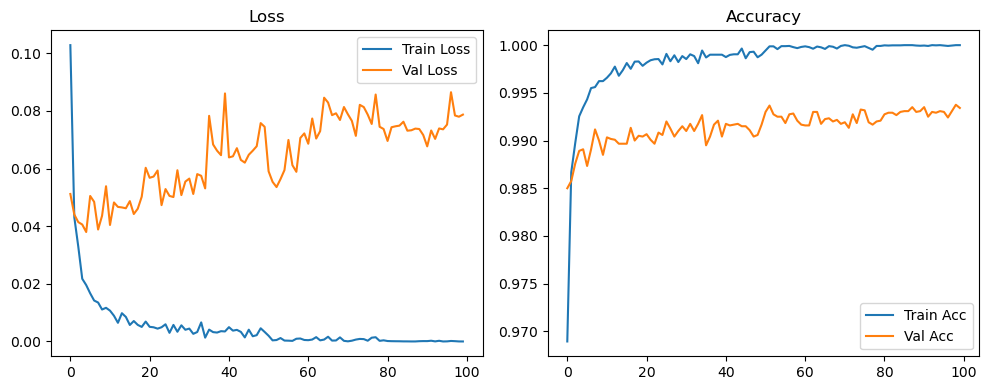

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1223, Acc: 0.9642 | Val Loss: 0.0753, Acc: 0.9766


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9823 | Val Loss: 0.0429, Acc: 0.9872


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9858 | Val Loss: 0.0525, Acc: 0.9835


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9885 | Val Loss: 0.0441, Acc: 0.9860


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9894 | Val Loss: 0.0459, Acc: 0.9864


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9908 | Val Loss: 0.0455, Acc: 0.9858


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9922 | Val Loss: 0.0552, Acc: 0.9828


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9924 | Val Loss: 0.0292, Acc: 0.9908


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.0339, Acc: 0.9895


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.0335, Acc: 0.9900


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9933 | Val Loss: 0.0376, Acc: 0.9895


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9954 | Val Loss: 0.0391, Acc: 0.9891


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0338, Acc: 0.9901


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0358, Acc: 0.9907


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.0300, Acc: 0.9918


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9945 | Val Loss: 0.0367, Acc: 0.9896


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9944 | Val Loss: 0.0419, Acc: 0.9869


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0389, Acc: 0.9898


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0307, Acc: 0.9916


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0384, Acc: 0.9896


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0371, Acc: 0.9905


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.0437, Acc: 0.9888


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0409, Acc: 0.9883


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9966 | Val Loss: 0.0418, Acc: 0.9898


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0434, Acc: 0.9891


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.0435, Acc: 0.9888


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0364, Acc: 0.9910


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0371, Acc: 0.9907


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0392, Acc: 0.9899


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0447, Acc: 0.9883


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0339, Acc: 0.9915


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0373, Acc: 0.9906


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0400, Acc: 0.9908


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0434, Acc: 0.9898


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.0375, Acc: 0.9907


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0317, Acc: 0.9921


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0419, Acc: 0.9906


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0307, Acc: 0.9918


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0371, Acc: 0.9914


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0351, Acc: 0.9908


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0328, Acc: 0.9921


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0346, Acc: 0.9917


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.0394, Acc: 0.9913


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0366, Acc: 0.9908


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0431, Acc: 0.9907


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0303, Acc: 0.9926


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0320, Acc: 0.9916


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.0361, Acc: 0.9905


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0302, Acc: 0.9928


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0386, Acc: 0.9895


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0333, Acc: 0.9927


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0407, Acc: 0.9918


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0348, Acc: 0.9919


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0313, Acc: 0.9922


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0358, Acc: 0.9918


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0346, Acc: 0.9922


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0328, Acc: 0.9924


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0360, Acc: 0.9915


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0375, Acc: 0.9914


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0343, Acc: 0.9924


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0328, Acc: 0.9918


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0372, Acc: 0.9908


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0291, Acc: 0.9931


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0325, Acc: 0.9922


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0320, Acc: 0.9924


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0288, Acc: 0.9933


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0319, Acc: 0.9922


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0289, Acc: 0.9932


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0380, Acc: 0.9909


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0333, Acc: 0.9925


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0344, Acc: 0.9920


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0282, Acc: 0.9934


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0357, Acc: 0.9909


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0330, Acc: 0.9920


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0332, Acc: 0.9916


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0382, Acc: 0.9907


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0306, Acc: 0.9934


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0292, Acc: 0.9929


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0307, Acc: 0.9918


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0345, Acc: 0.9912


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0301, Acc: 0.9922


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0319, Acc: 0.9924


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0287, Acc: 0.9931


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0313, Acc: 0.9927


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0327, Acc: 0.9930


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0355, Acc: 0.9921


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.0320, Acc: 0.9926


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0307, Acc: 0.9929


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0327, Acc: 0.9927


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9996 | Val Loss: 0.0297, Acc: 0.9932


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0314, Acc: 0.9925


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0331, Acc: 0.9923


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9997 | Val Loss: 0.0302, Acc: 0.9928


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0314, Acc: 0.9935


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0328, Acc: 0.9926


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0333, Acc: 0.9928


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0328, Acc: 0.9934


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0303, Acc: 0.9930


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0301, Acc: 0.9928


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0292, Acc: 0.9932


Final Test Loss: 0.0244 Accuracy: 0.9935


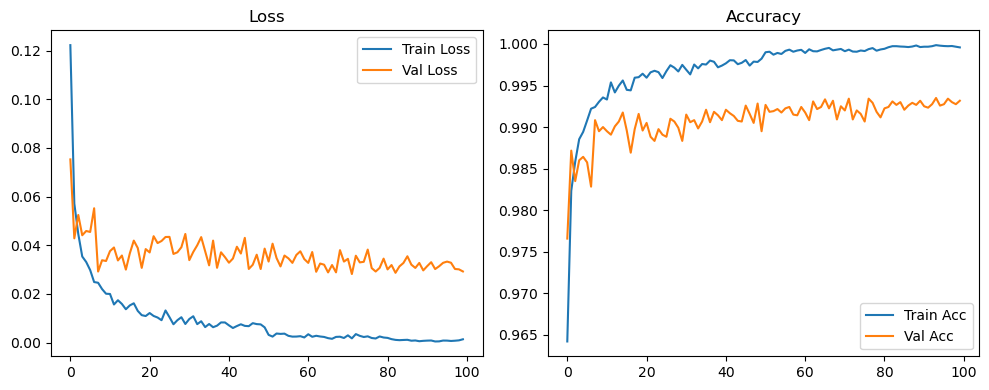

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1872, Acc: 0.9460 | Val Loss: 0.3552, Acc: 0.8852


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0948, Acc: 0.9717 | Val Loss: 0.2872, Acc: 0.8988


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0812, Acc: 0.9749 | Val Loss: 0.1895, Acc: 0.9381


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9786 | Val Loss: 0.1534, Acc: 0.9507


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9804 | Val Loss: 0.1021, Acc: 0.9703


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9814 | Val Loss: 0.1040, Acc: 0.9684


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0574, Acc: 0.9820 | Val Loss: 0.0877, Acc: 0.9750


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9833 | Val Loss: 0.1183, Acc: 0.9639


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9846 | Val Loss: 0.0514, Acc: 0.9862


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9847 | Val Loss: 0.0782, Acc: 0.9776


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9853 | Val Loss: 0.0935, Acc: 0.9704


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9864 | Val Loss: 0.1052, Acc: 0.9704


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9858 | Val Loss: 0.0741, Acc: 0.9780


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9873 | Val Loss: 0.0694, Acc: 0.9786


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9865 | Val Loss: 0.0504, Acc: 0.9857


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9867 | Val Loss: 0.0534, Acc: 0.9842


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9887 | Val Loss: 0.0845, Acc: 0.9743


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9875 | Val Loss: 0.0929, Acc: 0.9713


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9878 | Val Loss: 0.0685, Acc: 0.9792


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9888 | Val Loss: 0.0601, Acc: 0.9821


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9893 | Val Loss: 0.1100, Acc: 0.9648


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9889 | Val Loss: 0.1045, Acc: 0.9670


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9885 | Val Loss: 0.0632, Acc: 0.9824


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9896 | Val Loss: 0.0509, Acc: 0.9858


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9897 | Val Loss: 0.0760, Acc: 0.9775


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9893 | Val Loss: 0.0869, Acc: 0.9722


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 0.0664, Acc: 0.9801


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9903 | Val Loss: 0.0785, Acc: 0.9763


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9902 | Val Loss: 0.0756, Acc: 0.9784


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9904 | Val Loss: 0.0461, Acc: 0.9868


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9909 | Val Loss: 0.0569, Acc: 0.9833


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9905 | Val Loss: 0.0672, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9910 | Val Loss: 0.0558, Acc: 0.9865


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9904 | Val Loss: 0.0528, Acc: 0.9861


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9905 | Val Loss: 0.0974, Acc: 0.9704


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9920 | Val Loss: 0.0731, Acc: 0.9777


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.0755, Acc: 0.9792


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9908 | Val Loss: 0.0584, Acc: 0.9845


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.0565, Acc: 0.9830


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9918 | Val Loss: 0.0574, Acc: 0.9848


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9909 | Val Loss: 0.0525, Acc: 0.9861


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9917 | Val Loss: 0.0599, Acc: 0.9827


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9913 | Val Loss: 0.0509, Acc: 0.9864


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.0554, Acc: 0.9848


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9922 | Val Loss: 0.0640, Acc: 0.9810


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9916 | Val Loss: 0.0485, Acc: 0.9868


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9915 | Val Loss: 0.0688, Acc: 0.9797


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.0624, Acc: 0.9822


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.0721, Acc: 0.9792


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0906, Acc: 0.9718


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0582, Acc: 0.9840


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9946 | Val Loss: 0.0571, Acc: 0.9840


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.0503, Acc: 0.9859


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.0509, Acc: 0.9849


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9945 | Val Loss: 0.0478, Acc: 0.9857


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.0566, Acc: 0.9849


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.0576, Acc: 0.9844


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0513, Acc: 0.9858


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0499, Acc: 0.9874


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0463, Acc: 0.9866


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0371, Acc: 0.9906


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9948 | Val Loss: 0.0631, Acc: 0.9835


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9949 | Val Loss: 0.0399, Acc: 0.9889


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.0486, Acc: 0.9856


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0406, Acc: 0.9888


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.0435, Acc: 0.9890


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0449, Acc: 0.9882


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0475, Acc: 0.9864


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.0535, Acc: 0.9841


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0573, Acc: 0.9847


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.0539, Acc: 0.9850


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9951 | Val Loss: 0.0502, Acc: 0.9855


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0729, Acc: 0.9795


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0677, Acc: 0.9808


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0562, Acc: 0.9847


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.0476, Acc: 0.9863


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.0382, Acc: 0.9900


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0439, Acc: 0.9888


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.0638, Acc: 0.9821


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.0441, Acc: 0.9890


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.0447, Acc: 0.9892


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0559, Acc: 0.9858


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0425, Acc: 0.9890


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9962 | Val Loss: 0.0487, Acc: 0.9874


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0442, Acc: 0.9886


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0510, Acc: 0.9862


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0473, Acc: 0.9877


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0467, Acc: 0.9877


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0469, Acc: 0.9878


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0397, Acc: 0.9885


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0427, Acc: 0.9884


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.0471, Acc: 0.9876


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.0397, Acc: 0.9898


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0410, Acc: 0.9886


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0430, Acc: 0.9890


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0424, Acc: 0.9892


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0377, Acc: 0.9898


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0350, Acc: 0.9912


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0431, Acc: 0.9883


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.0438, Acc: 0.9881


Final Test Loss: 0.0439 Accuracy: 0.9885


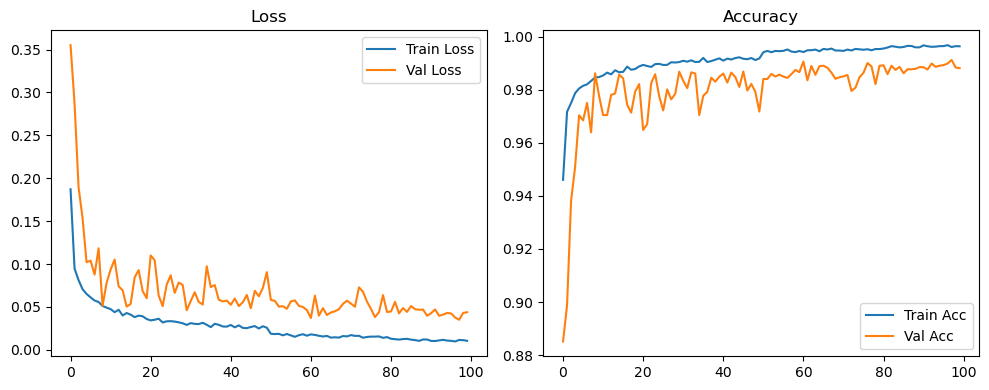

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1031, Acc: 0.9691 | Val Loss: 0.0515, Acc: 0.9848


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9868 | Val Loss: 0.0368, Acc: 0.9890


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.0454, Acc: 0.9859


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0402, Acc: 0.9881


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0362, Acc: 0.9904


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0424, Acc: 0.9885


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0579, Acc: 0.9852


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0342, Acc: 0.9913


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.0522, Acc: 0.9883


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0408, Acc: 0.9902


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0465, Acc: 0.9905


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0520, Acc: 0.9897


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0425, Acc: 0.9912


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0529, Acc: 0.9890


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0558, Acc: 0.9899


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0461, Acc: 0.9919


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0462, Acc: 0.9927


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0554, Acc: 0.9904


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.0436, Acc: 0.9920


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0544, Acc: 0.9899


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0523, Acc: 0.9915


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0666, Acc: 0.9903


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0445, Acc: 0.9921


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0466, Acc: 0.9913


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0574, Acc: 0.9909


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.0509, Acc: 0.9906


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0543, Acc: 0.9922


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0522, Acc: 0.9921


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.0505, Acc: 0.9917


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0744, Acc: 0.9890


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0593, Acc: 0.9916


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0562, Acc: 0.9914


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.0506, Acc: 0.9919


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0693, Acc: 0.9898


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0653, Acc: 0.9911


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0477, Acc: 0.9928


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0593, Acc: 0.9923


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0655, Acc: 0.9911


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0550, Acc: 0.9923


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0651, Acc: 0.9919


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0653, Acc: 0.9913


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0621, Acc: 0.9913


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0579, Acc: 0.9929


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0584, Acc: 0.9918


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9992 | Val Loss: 0.0576, Acc: 0.9920


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0566, Acc: 0.9918


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0643, Acc: 0.9920


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0636, Acc: 0.9928


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0773, Acc: 0.9918


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0766, Acc: 0.9910


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0622, Acc: 0.9926


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0623, Acc: 0.9928


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0610, Acc: 0.9929


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0614, Acc: 0.9925


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0609, Acc: 0.9924


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0544, Acc: 0.9931


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0652, Acc: 0.9923


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0648, Acc: 0.9918


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0785, Acc: 0.9917


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0700, Acc: 0.9908


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0773, Acc: 0.9913


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0696, Acc: 0.9920


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0688, Acc: 0.9922


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0644, Acc: 0.9930


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9998 | Val Loss: 0.0699, Acc: 0.9920


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0674, Acc: 0.9924


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0616, Acc: 0.9931


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0696, Acc: 0.9918


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0714, Acc: 0.9919


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0635, Acc: 0.9927


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0751, Acc: 0.9918


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0689, Acc: 0.9929


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0699, Acc: 0.9934


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0750, Acc: 0.9928


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0706, Acc: 0.9932


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0749, Acc: 0.9921


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0763, Acc: 0.9924


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0789, Acc: 0.9926


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0713, Acc: 0.9933


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0780, Acc: 0.9919


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0753, Acc: 0.9931


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0746, Acc: 0.9932


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0721, Acc: 0.9938


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0708, Acc: 0.9932


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0715, Acc: 0.9929


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0696, Acc: 0.9934


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0683, Acc: 0.9934


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0700, Acc: 0.9933


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0710, Acc: 0.9933


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0671, Acc: 0.9938


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0674, Acc: 0.9939


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0713, Acc: 0.9936


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0698, Acc: 0.9936


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0719, Acc: 0.9938


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0696, Acc: 0.9932


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0702, Acc: 0.9935


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0709, Acc: 0.9938


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0699, Acc: 0.9938


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0696, Acc: 0.9941


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0697, Acc: 0.9940


Final Test Loss: 0.0628 Accuracy: 0.9934


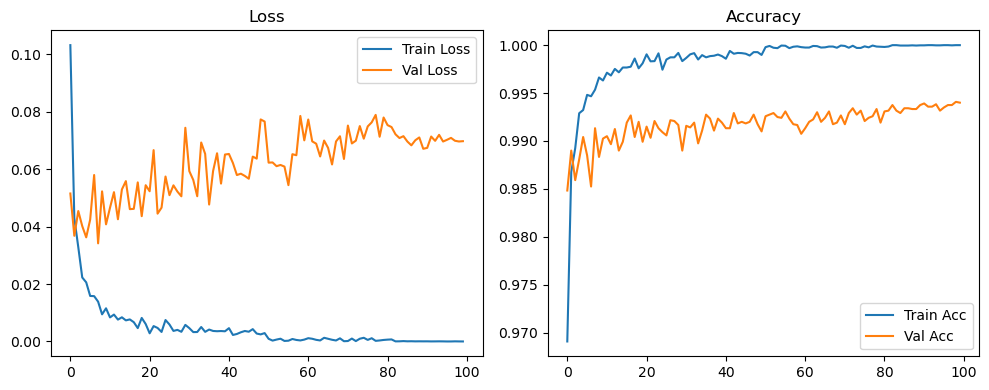

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1228, Acc: 0.9635 | Val Loss: 0.0816, Acc: 0.9756


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9818 | Val Loss: 0.0438, Acc: 0.9865


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9857 | Val Loss: 0.0527, Acc: 0.9846


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9882 | Val Loss: 0.0487, Acc: 0.9852


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9900 | Val Loss: 0.0461, Acc: 0.9858


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9909 | Val Loss: 0.0464, Acc: 0.9853


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9912 | Val Loss: 0.0484, Acc: 0.9853


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.0353, Acc: 0.9888


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.0316, Acc: 0.9906


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.0310, Acc: 0.9905


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.0388, Acc: 0.9881


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9943 | Val Loss: 0.0391, Acc: 0.9896


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0337, Acc: 0.9889


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0322, Acc: 0.9908


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.0268, Acc: 0.9921


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.0323, Acc: 0.9896


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0383, Acc: 0.9897


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0377, Acc: 0.9900


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.0330, Acc: 0.9909


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0327, Acc: 0.9912


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0376, Acc: 0.9897


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0402, Acc: 0.9901


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0575, Acc: 0.9858


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0369, Acc: 0.9917


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9963 | Val Loss: 0.0373, Acc: 0.9898


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.0321, Acc: 0.9921


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0407, Acc: 0.9900


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0332, Acc: 0.9908


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0408, Acc: 0.9903


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9976 | Val Loss: 0.0367, Acc: 0.9908


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0343, Acc: 0.9911


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0290, Acc: 0.9933


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0325, Acc: 0.9918


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0366, Acc: 0.9908


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0396, Acc: 0.9911


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0363, Acc: 0.9919


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0351, Acc: 0.9918


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0404, Acc: 0.9905


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0387, Acc: 0.9915


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0354, Acc: 0.9912


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0419, Acc: 0.9894


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0364, Acc: 0.9926


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0375, Acc: 0.9912


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0435, Acc: 0.9900


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0360, Acc: 0.9914


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0321, Acc: 0.9911


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0378, Acc: 0.9918


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.0401, Acc: 0.9905


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0418, Acc: 0.9895


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0350, Acc: 0.9917


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0338, Acc: 0.9918


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0327, Acc: 0.9918


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0318, Acc: 0.9921


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0344, Acc: 0.9922


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0400, Acc: 0.9908


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0385, Acc: 0.9910


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0377, Acc: 0.9922


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0403, Acc: 0.9907


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0331, Acc: 0.9922


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0370, Acc: 0.9921


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0356, Acc: 0.9923


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.0399, Acc: 0.9918


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0370, Acc: 0.9929


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0328, Acc: 0.9924


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0285, Acc: 0.9936


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0302, Acc: 0.9930


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0325, Acc: 0.9934


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0365, Acc: 0.9927


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0320, Acc: 0.9923


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0358, Acc: 0.9921


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0352, Acc: 0.9919


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0310, Acc: 0.9926


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0333, Acc: 0.9922


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0343, Acc: 0.9922


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0365, Acc: 0.9915


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0373, Acc: 0.9918


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0311, Acc: 0.9934


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0328, Acc: 0.9922


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0355, Acc: 0.9917


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0368, Acc: 0.9923


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0329, Acc: 0.9925


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0345, Acc: 0.9925


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0344, Acc: 0.9924


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0343, Acc: 0.9930


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0332, Acc: 0.9929


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0342, Acc: 0.9930


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0340, Acc: 0.9931


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0352, Acc: 0.9929


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0360, Acc: 0.9927


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0321, Acc: 0.9932


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0313, Acc: 0.9933


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0327, Acc: 0.9932


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0305, Acc: 0.9932


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0314, Acc: 0.9931


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0331, Acc: 0.9932


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0351, Acc: 0.9928


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0346, Acc: 0.9934


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0311, Acc: 0.9932


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0300, Acc: 0.9938


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0283, Acc: 0.9942


Final Test Loss: 0.0251 Accuracy: 0.9933


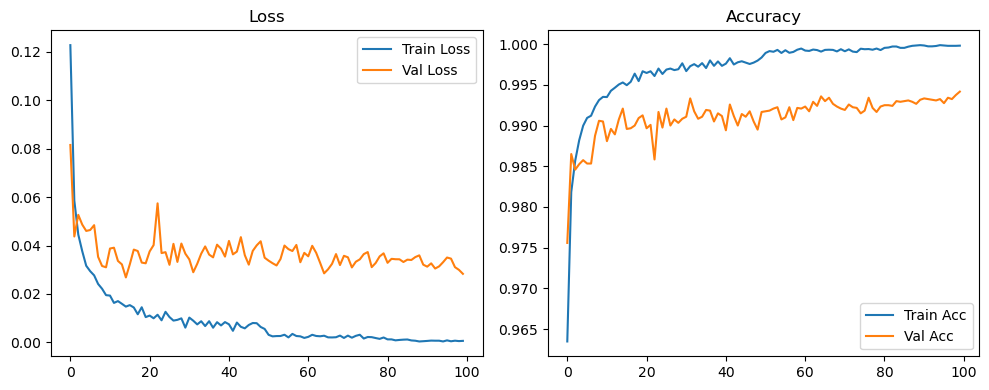

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1881, Acc: 0.9456 | Val Loss: 0.2667, Acc: 0.9157


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9719 | Val Loss: 0.2719, Acc: 0.9081


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9754 | Val Loss: 0.1587, Acc: 0.9513


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9778 | Val Loss: 0.1433, Acc: 0.9551


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0650, Acc: 0.9801 | Val Loss: 0.1030, Acc: 0.9695


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9818 | Val Loss: 0.1027, Acc: 0.9697


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9818 | Val Loss: 0.0864, Acc: 0.9743


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9841 | Val Loss: 0.1134, Acc: 0.9645


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9846 | Val Loss: 0.0705, Acc: 0.9798


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9850 | Val Loss: 0.0928, Acc: 0.9723


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9849 | Val Loss: 0.0524, Acc: 0.9854


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9856 | Val Loss: 0.0903, Acc: 0.9747


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9855 | Val Loss: 0.0977, Acc: 0.9712


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.0592, Acc: 0.9829


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9871 | Val Loss: 0.0525, Acc: 0.9841


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9873 | Val Loss: 0.0538, Acc: 0.9845


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9881 | Val Loss: 0.0905, Acc: 0.9727


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9875 | Val Loss: 0.0796, Acc: 0.9760


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9874 | Val Loss: 0.0628, Acc: 0.9807


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9888 | Val Loss: 0.0870, Acc: 0.9735


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 0.0946, Acc: 0.9711


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9885 | Val Loss: 0.1003, Acc: 0.9687


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9885 | Val Loss: 0.0609, Acc: 0.9830


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 0.0552, Acc: 0.9834


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9887 | Val Loss: 0.0736, Acc: 0.9772


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9898 | Val Loss: 0.0910, Acc: 0.9704


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9897 | Val Loss: 0.0486, Acc: 0.9864


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9899 | Val Loss: 0.0606, Acc: 0.9806


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9900 | Val Loss: 0.0546, Acc: 0.9848


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.0475, Acc: 0.9857


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9908 | Val Loss: 0.0468, Acc: 0.9866


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.0556, Acc: 0.9830


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9901 | Val Loss: 0.0460, Acc: 0.9870


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.0491, Acc: 0.9861


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9911 | Val Loss: 0.0737, Acc: 0.9781


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.0517, Acc: 0.9848


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9902 | Val Loss: 0.0560, Acc: 0.9839


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9905 | Val Loss: 0.0613, Acc: 0.9823


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9913 | Val Loss: 0.0461, Acc: 0.9864


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9907 | Val Loss: 0.0488, Acc: 0.9860


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9919 | Val Loss: 0.0517, Acc: 0.9860


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9917 | Val Loss: 0.0559, Acc: 0.9842


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.0565, Acc: 0.9826


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.0420, Acc: 0.9880


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9916 | Val Loss: 0.0534, Acc: 0.9851


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9919 | Val Loss: 0.0383, Acc: 0.9902


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.0468, Acc: 0.9860


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.0498, Acc: 0.9847


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9917 | Val Loss: 0.0468, Acc: 0.9872


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9925 | Val Loss: 0.0536, Acc: 0.9850


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0567, Acc: 0.9842


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0488, Acc: 0.9857


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0485, Acc: 0.9861


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.0406, Acc: 0.9888


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0374, Acc: 0.9904


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.0446, Acc: 0.9880


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0362, Acc: 0.9905


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9939 | Val Loss: 0.0396, Acc: 0.9883


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9948 | Val Loss: 0.0467, Acc: 0.9872


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.0389, Acc: 0.9883


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 0.0404, Acc: 0.9900


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.0539, Acc: 0.9841


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.0365, Acc: 0.9904


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0419, Acc: 0.9881


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.0389, Acc: 0.9889


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0399, Acc: 0.9882


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0488, Acc: 0.9854


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0411, Acc: 0.9875


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0553, Acc: 0.9835


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9949 | Val Loss: 0.0400, Acc: 0.9889


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.0477, Acc: 0.9862


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.0453, Acc: 0.9869


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0431, Acc: 0.9870


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0436, Acc: 0.9871


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.0454, Acc: 0.9877


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0396, Acc: 0.9892


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.0346, Acc: 0.9903


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0384, Acc: 0.9893


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0453, Acc: 0.9880


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0360, Acc: 0.9901


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0352, Acc: 0.9902


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0409, Acc: 0.9883


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0341, Acc: 0.9908


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0406, Acc: 0.9895


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9959 | Val Loss: 0.0389, Acc: 0.9891


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0397, Acc: 0.9887


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0360, Acc: 0.9898


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0367, Acc: 0.9894


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0348, Acc: 0.9905


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0322, Acc: 0.9912


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0326, Acc: 0.9911


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0355, Acc: 0.9909


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.0339, Acc: 0.9917


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.0335, Acc: 0.9906


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0369, Acc: 0.9902


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0389, Acc: 0.9889


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0368, Acc: 0.9892


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0336, Acc: 0.9908


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0362, Acc: 0.9898


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0389, Acc: 0.9894


Final Test Loss: 0.0371 Accuracy: 0.9908


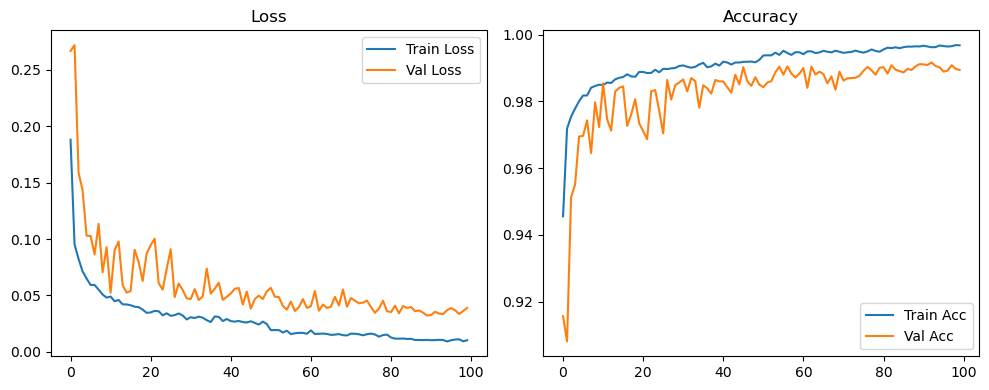

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1027, Acc: 0.9693 | Val Loss: 0.0497, Acc: 0.9848


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9864 | Val Loss: 0.0361, Acc: 0.9889


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9900 | Val Loss: 0.0438, Acc: 0.9882


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.0379, Acc: 0.9899


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.0375, Acc: 0.9888


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0506, Acc: 0.9869


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0345, Acc: 0.9917


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0443, Acc: 0.9891


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.0444, Acc: 0.9893


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0433, Acc: 0.9890


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0481, Acc: 0.9893


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0480, Acc: 0.9891


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0421, Acc: 0.9911


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0449, Acc: 0.9906


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0426, Acc: 0.9903


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0472, Acc: 0.9913


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0476, Acc: 0.9914


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0496, Acc: 0.9910


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0551, Acc: 0.9898


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0457, Acc: 0.9902


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0570, Acc: 0.9895


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0562, Acc: 0.9902


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0499, Acc: 0.9916


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0682, Acc: 0.9895


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0477, Acc: 0.9918


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0533, Acc: 0.9911


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0635, Acc: 0.9898


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0508, Acc: 0.9923


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0582, Acc: 0.9907


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0579, Acc: 0.9910


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0623, Acc: 0.9914


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0592, Acc: 0.9924


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.0834, Acc: 0.9883


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0520, Acc: 0.9920


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0593, Acc: 0.9910


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0569, Acc: 0.9912


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0591, Acc: 0.9919


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0853, Acc: 0.9887


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0625, Acc: 0.9922


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.0677, Acc: 0.9912


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0694, Acc: 0.9915


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0690, Acc: 0.9906


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.0554, Acc: 0.9931


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0648, Acc: 0.9925


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0630, Acc: 0.9928


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0725, Acc: 0.9911


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.0735, Acc: 0.9906


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0642, Acc: 0.9914


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0604, Acc: 0.9933


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0728, Acc: 0.9908


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0603, Acc: 0.9927


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.0596, Acc: 0.9937


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0590, Acc: 0.9936


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0580, Acc: 0.9932


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0573, Acc: 0.9936


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0566, Acc: 0.9936


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0569, Acc: 0.9938


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0558, Acc: 0.9939


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0595, Acc: 0.9938


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0615, Acc: 0.9938


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0612, Acc: 0.9940


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0617, Acc: 0.9938


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0598, Acc: 0.9939


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9938


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0602, Acc: 0.9934


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0617, Acc: 0.9935


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0609, Acc: 0.9937


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0627, Acc: 0.9935


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0638, Acc: 0.9938


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0636, Acc: 0.9938


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0633, Acc: 0.9932


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9937


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0580, Acc: 0.9939


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0564, Acc: 0.9942


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0589, Acc: 0.9938


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0578, Acc: 0.9939


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0626, Acc: 0.9937


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0637, Acc: 0.9938


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0650, Acc: 0.9936


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0642, Acc: 0.9933


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9932


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0662, Acc: 0.9932


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0659, Acc: 0.9931


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0652, Acc: 0.9934


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0661, Acc: 0.9931


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0660, Acc: 0.9934


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0657, Acc: 0.9938


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0643, Acc: 0.9938


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0661, Acc: 0.9933


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0640, Acc: 0.9938


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0635, Acc: 0.9939


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0661, Acc: 0.9937


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0660, Acc: 0.9935


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0659, Acc: 0.9938


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0674, Acc: 0.9938


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0670, Acc: 0.9941


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0677, Acc: 0.9939


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0653, Acc: 0.9940


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0660, Acc: 0.9941


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0646, Acc: 0.9938


Final Test Loss: 0.0542 Accuracy: 0.9938


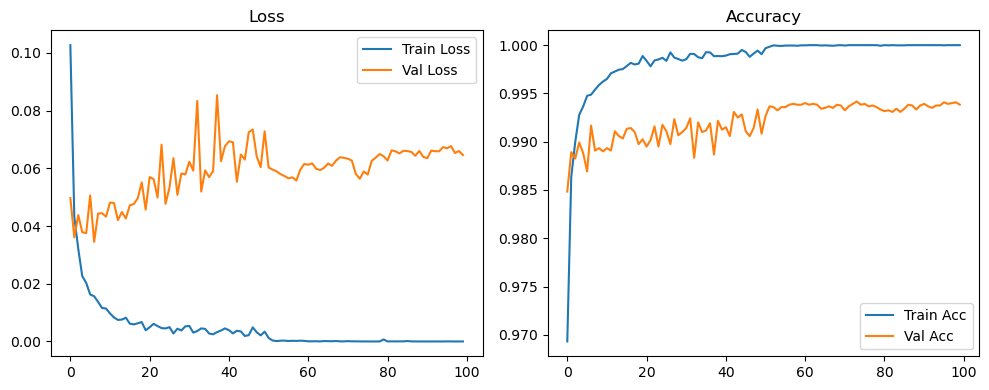

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1217, Acc: 0.9644 | Val Loss: 0.0828, Acc: 0.9740


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9822 | Val Loss: 0.0456, Acc: 0.9858


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9867 | Val Loss: 0.0468, Acc: 0.9860


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9890 | Val Loss: 0.0572, Acc: 0.9824


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9895 | Val Loss: 0.0429, Acc: 0.9872


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.0488, Acc: 0.9851


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9915 | Val Loss: 0.0538, Acc: 0.9854


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9923 | Val Loss: 0.0325, Acc: 0.9905


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0422, Acc: 0.9871


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9927 | Val Loss: 0.0315, Acc: 0.9897


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0406, Acc: 0.9884


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.0313, Acc: 0.9904


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9948 | Val Loss: 0.0351, Acc: 0.9899


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.0321, Acc: 0.9913


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0305, Acc: 0.9918


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0310, Acc: 0.9915


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0352, Acc: 0.9898


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0387, Acc: 0.9898


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.0277, Acc: 0.9926


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0369, Acc: 0.9910


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0384, Acc: 0.9907


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0397, Acc: 0.9898


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0371, Acc: 0.9891


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0341, Acc: 0.9906


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0383, Acc: 0.9894


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0361, Acc: 0.9903


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0310, Acc: 0.9919


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0355, Acc: 0.9911


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0381, Acc: 0.9902


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0329, Acc: 0.9902


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0299, Acc: 0.9918


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0388, Acc: 0.9910


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.0342, Acc: 0.9922


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0339, Acc: 0.9913


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0419, Acc: 0.9890


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0402, Acc: 0.9922


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0350, Acc: 0.9907


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0336, Acc: 0.9918


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.0314, Acc: 0.9924


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0298, Acc: 0.9928


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0367, Acc: 0.9908


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0408, Acc: 0.9909


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0348, Acc: 0.9912


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0395, Acc: 0.9911


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0325, Acc: 0.9922


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0368, Acc: 0.9913


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0370, Acc: 0.9910


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0392, Acc: 0.9913


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.0394, Acc: 0.9898


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0463, Acc: 0.9892


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0346, Acc: 0.9922


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0352, Acc: 0.9918


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0301, Acc: 0.9931


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0303, Acc: 0.9924


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0326, Acc: 0.9924


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0314, Acc: 0.9929


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0314, Acc: 0.9934


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0334, Acc: 0.9928


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0345, Acc: 0.9931


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0330, Acc: 0.9927


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0311, Acc: 0.9932


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0323, Acc: 0.9928


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0303, Acc: 0.9928


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0299, Acc: 0.9933


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0304, Acc: 0.9939


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0304, Acc: 0.9938


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0309, Acc: 0.9935


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0325, Acc: 0.9935


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0317, Acc: 0.9935


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0339, Acc: 0.9929


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0325, Acc: 0.9932


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0316, Acc: 0.9936


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0303, Acc: 0.9931


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0300, Acc: 0.9928


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0318, Acc: 0.9928


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0323, Acc: 0.9934


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0310, Acc: 0.9938


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0293, Acc: 0.9936


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0340, Acc: 0.9934


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0322, Acc: 0.9936


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0320, Acc: 0.9931


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0353, Acc: 0.9928


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0321, Acc: 0.9936


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0340, Acc: 0.9933


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0333, Acc: 0.9937


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0327, Acc: 0.9937


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0337, Acc: 0.9937


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0344, Acc: 0.9937


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0335, Acc: 0.9933


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0322, Acc: 0.9935


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0317, Acc: 0.9938


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0326, Acc: 0.9937


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0308, Acc: 0.9938


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0325, Acc: 0.9932


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0328, Acc: 0.9935


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0331, Acc: 0.9932


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0334, Acc: 0.9932


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0323, Acc: 0.9933


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0320, Acc: 0.9935


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0307, Acc: 0.9938


Final Test Loss: 0.0244 Accuracy: 0.9939


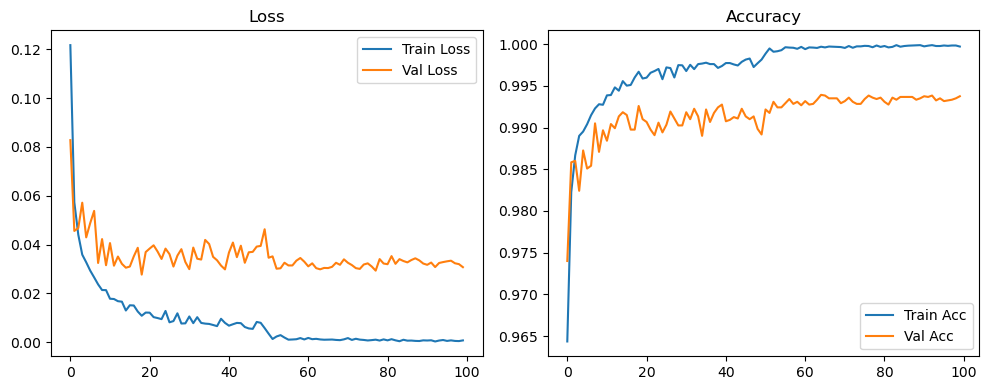

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1866, Acc: 0.9461 | Val Loss: 0.2487, Acc: 0.9233


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9720 | Val Loss: 0.2232, Acc: 0.9274


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9756 | Val Loss: 0.1723, Acc: 0.9446


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0708, Acc: 0.9785 | Val Loss: 0.1221, Acc: 0.9598


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0649, Acc: 0.9810 | Val Loss: 0.0945, Acc: 0.9721


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0610, Acc: 0.9805 | Val Loss: 0.1016, Acc: 0.9706


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9821 | Val Loss: 0.0775, Acc: 0.9775


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9835 | Val Loss: 0.1134, Acc: 0.9652


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9841 | Val Loss: 0.0441, Acc: 0.9901


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9856 | Val Loss: 0.1007, Acc: 0.9678


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9852 | Val Loss: 0.0905, Acc: 0.9728


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9858 | Val Loss: 0.1018, Acc: 0.9708


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9855 | Val Loss: 0.0712, Acc: 0.9788


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9867 | Val Loss: 0.0539, Acc: 0.9849


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9874 | Val Loss: 0.0465, Acc: 0.9867


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9873 | Val Loss: 0.0587, Acc: 0.9831


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9870 | Val Loss: 0.0763, Acc: 0.9776


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9874 | Val Loss: 0.0613, Acc: 0.9831


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9880 | Val Loss: 0.0692, Acc: 0.9804


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9889 | Val Loss: 0.0701, Acc: 0.9789


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9889 | Val Loss: 0.0766, Acc: 0.9764


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 0.0934, Acc: 0.9716


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9888 | Val Loss: 0.0828, Acc: 0.9748


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9898 | Val Loss: 0.0429, Acc: 0.9886


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9894 | Val Loss: 0.0716, Acc: 0.9796


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.0746, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9899 | Val Loss: 0.0588, Acc: 0.9829


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9903 | Val Loss: 0.0591, Acc: 0.9822


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9908 | Val Loss: 0.0569, Acc: 0.9837


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9907 | Val Loss: 0.0544, Acc: 0.9861


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9899 | Val Loss: 0.0498, Acc: 0.9858


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.0693, Acc: 0.9792


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9903 | Val Loss: 0.0436, Acc: 0.9879


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9907 | Val Loss: 0.0652, Acc: 0.9811


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.0549, Acc: 0.9835


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0705, Acc: 0.9794


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.0792, Acc: 0.9735


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9916 | Val Loss: 0.0528, Acc: 0.9848


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.0533, Acc: 0.9841


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9917 | Val Loss: 0.0473, Acc: 0.9862


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9912 | Val Loss: 0.0623, Acc: 0.9822


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.0617, Acc: 0.9812


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9911 | Val Loss: 0.0643, Acc: 0.9818


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.0626, Acc: 0.9817


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.0526, Acc: 0.9847


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9911 | Val Loss: 0.0536, Acc: 0.9863


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9922 | Val Loss: 0.0580, Acc: 0.9828


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9932 | Val Loss: 0.0542, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9917 | Val Loss: 0.0600, Acc: 0.9822


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9920 | Val Loss: 0.0886, Acc: 0.9729


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.0618, Acc: 0.9812


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9949 | Val Loss: 0.0547, Acc: 0.9843


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.0463, Acc: 0.9861


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.0550, Acc: 0.9841


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0483, Acc: 0.9859


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0469, Acc: 0.9872


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0428, Acc: 0.9881


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0438, Acc: 0.9874


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0456, Acc: 0.9868


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9950 | Val Loss: 0.0399, Acc: 0.9886


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0380, Acc: 0.9886


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0459, Acc: 0.9869


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.0392, Acc: 0.9887


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9955 | Val Loss: 0.0366, Acc: 0.9894


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.0384, Acc: 0.9894


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9955 | Val Loss: 0.0388, Acc: 0.9891


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0386, Acc: 0.9892


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0412, Acc: 0.9877


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0400, Acc: 0.9885


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.0418, Acc: 0.9878


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.0414, Acc: 0.9874


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0400, Acc: 0.9883


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0454, Acc: 0.9861


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0414, Acc: 0.9878


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0436, Acc: 0.9870


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.0400, Acc: 0.9895


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0352, Acc: 0.9898


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.0345, Acc: 0.9912


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0453, Acc: 0.9871


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0405, Acc: 0.9882


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0374, Acc: 0.9898


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0448, Acc: 0.9868


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0350, Acc: 0.9906


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0438, Acc: 0.9878


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0379, Acc: 0.9892


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0368, Acc: 0.9897


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0395, Acc: 0.9886


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0368, Acc: 0.9898


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0371, Acc: 0.9900


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0315, Acc: 0.9913


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0329, Acc: 0.9907


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0357, Acc: 0.9903


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.0318, Acc: 0.9918


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0332, Acc: 0.9908


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0347, Acc: 0.9907


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0351, Acc: 0.9902


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0353, Acc: 0.9903


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0288, Acc: 0.9920


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0336, Acc: 0.9907


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0339, Acc: 0.9909


Final Test Loss: 0.0315 Accuracy: 0.9918


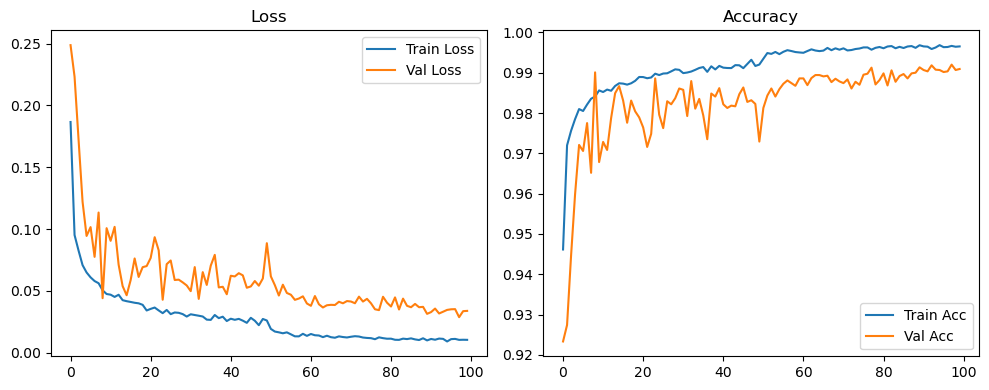

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1016, Acc: 0.9726 | Val Loss: 0.0458, Acc: 0.9859


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9874 | Val Loss: 0.0388, Acc: 0.9877


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9913 | Val Loss: 0.0422, Acc: 0.9875


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.0334, Acc: 0.9900


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.0378, Acc: 0.9898


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0391, Acc: 0.9896


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0392, Acc: 0.9893


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0396, Acc: 0.9900


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0457, Acc: 0.9892


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0365, Acc: 0.9908


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0527, Acc: 0.9870


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0448, Acc: 0.9900


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0460, Acc: 0.9892


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0520, Acc: 0.9884


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0392, Acc: 0.9908


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0374, Acc: 0.9921


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0510, Acc: 0.9901


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0424, Acc: 0.9912


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0415, Acc: 0.9921


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0439, Acc: 0.9913


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0466, Acc: 0.9909


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0403, Acc: 0.9926


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0530, Acc: 0.9910


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0488, Acc: 0.9910


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0462, Acc: 0.9910


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0478, Acc: 0.9916


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0446, Acc: 0.9921


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9991 | Val Loss: 0.0563, Acc: 0.9902


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0442, Acc: 0.9912


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0488, Acc: 0.9920


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0586, Acc: 0.9905


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0583, Acc: 0.9900


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0457, Acc: 0.9922


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0510, Acc: 0.9916


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0546, Acc: 0.9928


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0482, Acc: 0.9931


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0562, Acc: 0.9913


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0472, Acc: 0.9925


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0517, Acc: 0.9922


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0534, Acc: 0.9917


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0538, Acc: 0.9914


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0497, Acc: 0.9920


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0512, Acc: 0.9922


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0507, Acc: 0.9918


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0461, Acc: 0.9933


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0582, Acc: 0.9905


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0578, Acc: 0.9913


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0461, Acc: 0.9922


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0543, Acc: 0.9927


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0507, Acc: 0.9923


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0548, Acc: 0.9926


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0546, Acc: 0.9922


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0516, Acc: 0.9920


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0579, Acc: 0.9920


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0549, Acc: 0.9918


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0657, Acc: 0.9913


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0600, Acc: 0.9921


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0691, Acc: 0.9911


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0570, Acc: 0.9926


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0630, Acc: 0.9910


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0512, Acc: 0.9932


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0600, Acc: 0.9920


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0610, Acc: 0.9919


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0582, Acc: 0.9927


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0650, Acc: 0.9919


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0584, Acc: 0.9926


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.0642, Acc: 0.9921


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0572, Acc: 0.9919


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0549, Acc: 0.9931


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0585, Acc: 0.9929


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0607, Acc: 0.9928


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0605, Acc: 0.9927


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0627, Acc: 0.9918


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0691, Acc: 0.9916


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0671, Acc: 0.9928


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0657, Acc: 0.9928


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0622, Acc: 0.9922


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0647, Acc: 0.9927


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0626, Acc: 0.9924


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0729, Acc: 0.9919


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0636, Acc: 0.9914


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0735, Acc: 0.9916


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0678, Acc: 0.9922


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0747, Acc: 0.9912


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0753, Acc: 0.9917


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0710, Acc: 0.9923


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0639, Acc: 0.9932


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0619, Acc: 0.9933


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0760, Acc: 0.9926


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0746, Acc: 0.9925


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0665, Acc: 0.9923


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0695, Acc: 0.9918


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0597, Acc: 0.9931


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0653, Acc: 0.9918


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0752, Acc: 0.9923


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0675, Acc: 0.9933


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0710, Acc: 0.9922


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0751, Acc: 0.9914


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0712, Acc: 0.9925


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0688, Acc: 0.9933


Final Test Loss: 0.0587 Accuracy: 0.9923


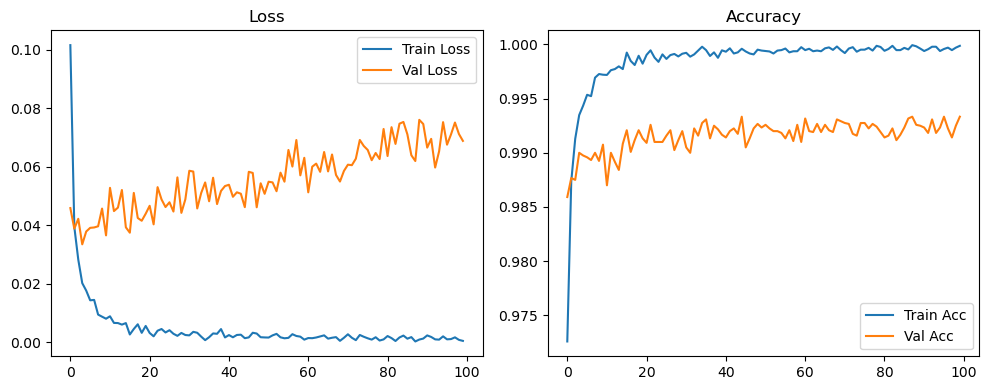

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1220, Acc: 0.9672 | Val Loss: 0.0614, Acc: 0.9808


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9831 | Val Loss: 0.0462, Acc: 0.9848


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9870 | Val Loss: 0.0460, Acc: 0.9851


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9898 | Val Loss: 0.0471, Acc: 0.9855


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9913 | Val Loss: 0.0385, Acc: 0.9884


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9918 | Val Loss: 0.0453, Acc: 0.9863


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.0415, Acc: 0.9875


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0333, Acc: 0.9903


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.0355, Acc: 0.9889


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9942 | Val Loss: 0.0340, Acc: 0.9899


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0342, Acc: 0.9898


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0303, Acc: 0.9912


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9946 | Val Loss: 0.0305, Acc: 0.9913


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0282, Acc: 0.9926


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0272, Acc: 0.9928


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0358, Acc: 0.9904


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.0463, Acc: 0.9875


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.0321, Acc: 0.9917


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.0325, Acc: 0.9922


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0313, Acc: 0.9918


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0329, Acc: 0.9922


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0327, Acc: 0.9920


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0305, Acc: 0.9920


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0306, Acc: 0.9931


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9971 | Val Loss: 0.0346, Acc: 0.9918


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0357, Acc: 0.9912


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0331, Acc: 0.9914


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0320, Acc: 0.9920


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0297, Acc: 0.9928


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0303, Acc: 0.9930


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0346, Acc: 0.9918


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0324, Acc: 0.9923


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0290, Acc: 0.9924


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0295, Acc: 0.9928


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0328, Acc: 0.9919


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0327, Acc: 0.9923


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0369, Acc: 0.9912


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0314, Acc: 0.9925


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0350, Acc: 0.9920


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0286, Acc: 0.9923


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0298, Acc: 0.9930


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0334, Acc: 0.9920


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0276, Acc: 0.9932


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0255, Acc: 0.9932


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0307, Acc: 0.9921


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0299, Acc: 0.9928


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0295, Acc: 0.9931


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0282, Acc: 0.9935


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0280, Acc: 0.9928


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0350, Acc: 0.9922


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0370, Acc: 0.9918


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0330, Acc: 0.9924


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0321, Acc: 0.9929


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0285, Acc: 0.9932


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0313, Acc: 0.9926


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0290, Acc: 0.9931


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0350, Acc: 0.9919


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0325, Acc: 0.9921


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0347, Acc: 0.9921


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0299, Acc: 0.9926


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0305, Acc: 0.9928


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0353, Acc: 0.9916


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0338, Acc: 0.9925


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0330, Acc: 0.9923


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0285, Acc: 0.9922


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0324, Acc: 0.9922


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0282, Acc: 0.9932


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0320, Acc: 0.9923


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0307, Acc: 0.9924


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0240, Acc: 0.9935


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0295, Acc: 0.9926


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0315, Acc: 0.9928


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0329, Acc: 0.9918


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0290, Acc: 0.9928


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0354, Acc: 0.9902


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0260, Acc: 0.9930


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0268, Acc: 0.9933


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0287, Acc: 0.9924


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0298, Acc: 0.9921


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0298, Acc: 0.9932


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0353, Acc: 0.9916


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0334, Acc: 0.9915


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0302, Acc: 0.9923


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0298, Acc: 0.9934


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0313, Acc: 0.9933


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0298, Acc: 0.9928


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0299, Acc: 0.9926


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0304, Acc: 0.9932


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0404, Acc: 0.9905


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0331, Acc: 0.9918


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0289, Acc: 0.9929


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0274, Acc: 0.9938


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0292, Acc: 0.9927


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0306, Acc: 0.9929


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0353, Acc: 0.9912


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0323, Acc: 0.9921


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0309, Acc: 0.9921


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0271, Acc: 0.9929


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0303, Acc: 0.9912


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0336, Acc: 0.9916


Final Test Loss: 0.0316 Accuracy: 0.9925


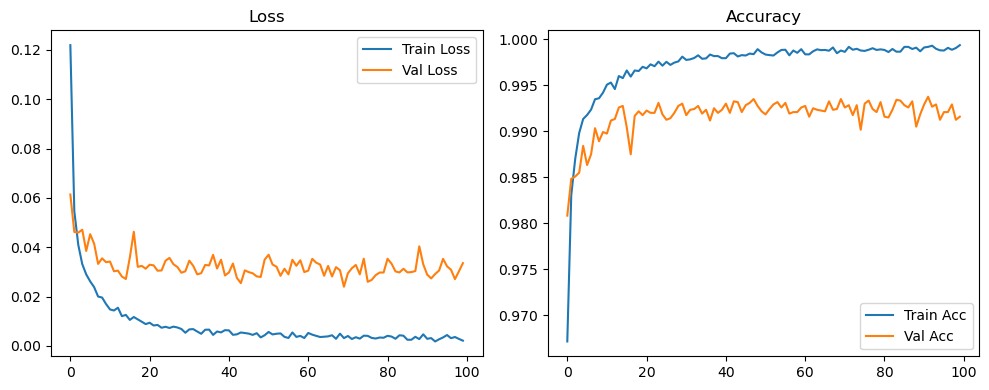

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1865, Acc: 0.9495 | Val Loss: 0.2194, Acc: 0.9325


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0916, Acc: 0.9726 | Val Loss: 0.1352, Acc: 0.9631


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0777, Acc: 0.9761 | Val Loss: 0.0860, Acc: 0.9776


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9802 | Val Loss: 0.0824, Acc: 0.9768


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9811 | Val Loss: 0.0594, Acc: 0.9859


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9827 | Val Loss: 0.0695, Acc: 0.9828


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9835 | Val Loss: 0.0480, Acc: 0.9884


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9859 | Val Loss: 0.0555, Acc: 0.9851


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9860 | Val Loss: 0.0490, Acc: 0.9868


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9866 | Val Loss: 0.0656, Acc: 0.9805


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9862 | Val Loss: 0.0574, Acc: 0.9842


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9876 | Val Loss: 0.0460, Acc: 0.9874


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9873 | Val Loss: 0.0643, Acc: 0.9811


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9881 | Val Loss: 0.0383, Acc: 0.9900


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9882 | Val Loss: 0.0395, Acc: 0.9888


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9881 | Val Loss: 0.0470, Acc: 0.9868


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9885 | Val Loss: 0.0545, Acc: 0.9858


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9884 | Val Loss: 0.0447, Acc: 0.9888


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9896 | Val Loss: 0.0474, Acc: 0.9874


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9900 | Val Loss: 0.0431, Acc: 0.9877


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9899 | Val Loss: 0.0512, Acc: 0.9861


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.0520, Acc: 0.9851


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9897 | Val Loss: 0.0428, Acc: 0.9891


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9912 | Val Loss: 0.0390, Acc: 0.9895


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.0374, Acc: 0.9898


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9907 | Val Loss: 0.0364, Acc: 0.9902


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.0339, Acc: 0.9914


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9913 | Val Loss: 0.0440, Acc: 0.9879


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9906 | Val Loss: 0.0443, Acc: 0.9879


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0427, Acc: 0.9880


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9912 | Val Loss: 0.0393, Acc: 0.9896


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.0340, Acc: 0.9906


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9925 | Val Loss: 0.0466, Acc: 0.9867


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9914 | Val Loss: 0.0440, Acc: 0.9882


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.0538, Acc: 0.9850


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.0351, Acc: 0.9894


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.0377, Acc: 0.9893


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9922 | Val Loss: 0.0355, Acc: 0.9899


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9920 | Val Loss: 0.0315, Acc: 0.9920


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9920 | Val Loss: 0.0344, Acc: 0.9907


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9920 | Val Loss: 0.0409, Acc: 0.9891


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.0468, Acc: 0.9872


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.0387, Acc: 0.9890


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0406, Acc: 0.9898


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9929 | Val Loss: 0.0391, Acc: 0.9902


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0366, Acc: 0.9899


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9930 | Val Loss: 0.0373, Acc: 0.9897


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0361, Acc: 0.9904


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9921 | Val Loss: 0.0481, Acc: 0.9868


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9932 | Val Loss: 0.0335, Acc: 0.9917


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9930 | Val Loss: 0.0421, Acc: 0.9880


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9932 | Val Loss: 0.0373, Acc: 0.9893


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.0396, Acc: 0.9899


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.0344, Acc: 0.9914


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.0372, Acc: 0.9907


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9937 | Val Loss: 0.0392, Acc: 0.9898


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.0364, Acc: 0.9904


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9934 | Val Loss: 0.0360, Acc: 0.9898


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9937 | Val Loss: 0.0355, Acc: 0.9902


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0321, Acc: 0.9922


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9936 | Val Loss: 0.0354, Acc: 0.9914


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.0481, Acc: 0.9877


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9937 | Val Loss: 0.0306, Acc: 0.9925


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.0420, Acc: 0.9892


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9944 | Val Loss: 0.0304, Acc: 0.9922


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0358, Acc: 0.9907


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0400, Acc: 0.9892


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.0386, Acc: 0.9891


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.0401, Acc: 0.9892


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.0406, Acc: 0.9908


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0417, Acc: 0.9897


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9943 | Val Loss: 0.0311, Acc: 0.9920


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9942 | Val Loss: 0.0508, Acc: 0.9869


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0441, Acc: 0.9888


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.0541, Acc: 0.9875


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.0467, Acc: 0.9887


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0347, Acc: 0.9905


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9947 | Val Loss: 0.0439, Acc: 0.9887


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.0513, Acc: 0.9882


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9942 | Val Loss: 0.0385, Acc: 0.9895


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0388, Acc: 0.9904


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9942 | Val Loss: 0.0464, Acc: 0.9876


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.0404, Acc: 0.9898


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0514, Acc: 0.9873


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.0546, Acc: 0.9870


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.0451, Acc: 0.9881


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9943 | Val Loss: 0.0425, Acc: 0.9895


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0473, Acc: 0.9893


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0541, Acc: 0.9857


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9944 | Val Loss: 0.0509, Acc: 0.9861


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9948 | Val Loss: 0.0468, Acc: 0.9888


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.0494, Acc: 0.9878


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.0607, Acc: 0.9853


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.0475, Acc: 0.9869


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9952 | Val Loss: 0.0486, Acc: 0.9886


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.0449, Acc: 0.9884


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0495, Acc: 0.9873


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.0432, Acc: 0.9883


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.0538, Acc: 0.9873


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0649, Acc: 0.9826


Final Test Loss: 0.0617 Accuracy: 0.9839


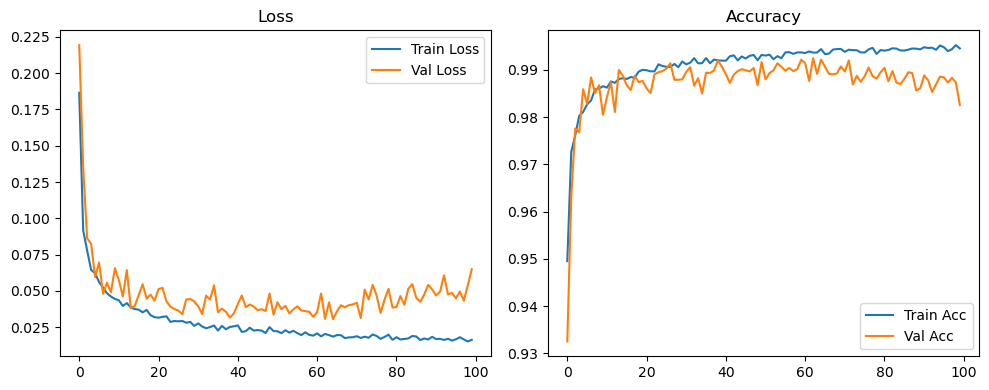

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1013, Acc: 0.9722 | Val Loss: 0.0458, Acc: 0.9857


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9873 | Val Loss: 0.0354, Acc: 0.9892


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 0.0362, Acc: 0.9898


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9939 | Val Loss: 0.0337, Acc: 0.9898


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.0364, Acc: 0.9904


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0408, Acc: 0.9889


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.0380, Acc: 0.9901


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0379, Acc: 0.9901


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0402, Acc: 0.9909


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0417, Acc: 0.9900


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0473, Acc: 0.9893


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0384, Acc: 0.9912


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0441, Acc: 0.9916


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0543, Acc: 0.9895


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0360, Acc: 0.9918


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0345, Acc: 0.9931


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0388, Acc: 0.9922


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0553, Acc: 0.9872


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0431, Acc: 0.9923


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0489, Acc: 0.9900


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0404, Acc: 0.9922


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0470, Acc: 0.9912


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0452, Acc: 0.9924


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0540, Acc: 0.9905


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0506, Acc: 0.9909


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0398, Acc: 0.9926


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0453, Acc: 0.9918


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0475, Acc: 0.9916


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0440, Acc: 0.9925


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0499, Acc: 0.9920


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0493, Acc: 0.9911


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0513, Acc: 0.9915


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0410, Acc: 0.9934


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0543, Acc: 0.9913


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0549, Acc: 0.9922


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0450, Acc: 0.9919


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0477, Acc: 0.9922


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0449, Acc: 0.9921


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0497, Acc: 0.9914


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0460, Acc: 0.9930


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0486, Acc: 0.9924


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0481, Acc: 0.9925


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0468, Acc: 0.9922


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0581, Acc: 0.9916


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0446, Acc: 0.9926


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0507, Acc: 0.9922


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0496, Acc: 0.9928


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0468, Acc: 0.9928


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0533, Acc: 0.9923


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0604, Acc: 0.9923


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0446, Acc: 0.9938


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0455, Acc: 0.9931


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0484, Acc: 0.9930


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0429, Acc: 0.9936


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9937


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9938


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0478, Acc: 0.9939


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0470, Acc: 0.9933


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9940


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0514, Acc: 0.9934


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0498, Acc: 0.9938


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0495, Acc: 0.9935


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9932


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0540, Acc: 0.9935


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0542, Acc: 0.9929


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0541, Acc: 0.9928


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0496, Acc: 0.9936


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0520, Acc: 0.9943


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0574, Acc: 0.9932


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0519, Acc: 0.9938


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0485, Acc: 0.9940


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9941


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0538, Acc: 0.9937


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9936


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0551, Acc: 0.9932


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0592, Acc: 0.9933


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0578, Acc: 0.9925


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0551, Acc: 0.9936


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0555, Acc: 0.9932


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0558, Acc: 0.9926


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0522, Acc: 0.9928


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0556, Acc: 0.9928


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9929


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9923


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9925


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0539, Acc: 0.9928


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0498, Acc: 0.9929


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9931


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9932


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9935


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9932


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0539, Acc: 0.9935


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9934


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0520, Acc: 0.9936


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9934


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9934


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9938


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9942


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0499, Acc: 0.9939


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9936


Final Test Loss: 0.0534 Accuracy: 0.9934


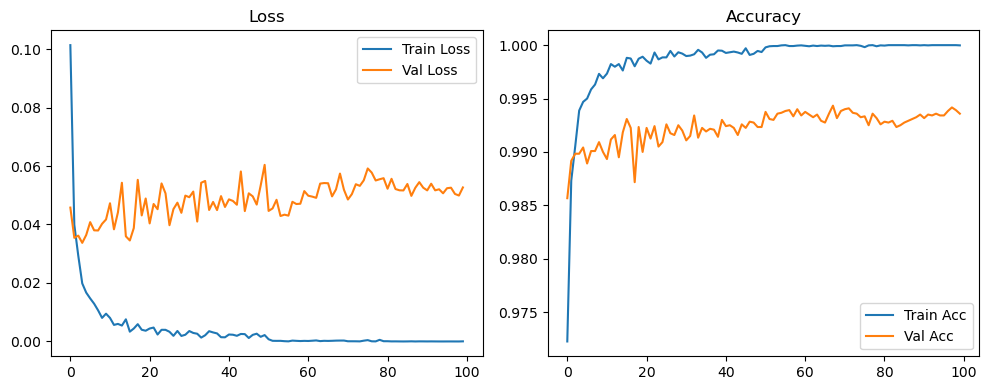

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1226, Acc: 0.9668 | Val Loss: 0.0620, Acc: 0.9808


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0544, Acc: 0.9835 | Val Loss: 0.0468, Acc: 0.9851


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9874 | Val Loss: 0.0428, Acc: 0.9868


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9894 | Val Loss: 0.0448, Acc: 0.9859


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.0340, Acc: 0.9892


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9917 | Val Loss: 0.0368, Acc: 0.9886


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.0495, Acc: 0.9861


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0300, Acc: 0.9912


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0347, Acc: 0.9906


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9940 | Val Loss: 0.0370, Acc: 0.9895


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.0369, Acc: 0.9900


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.0294, Acc: 0.9912


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.0327, Acc: 0.9909


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0307, Acc: 0.9920


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.0292, Acc: 0.9928


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0323, Acc: 0.9922


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0360, Acc: 0.9902


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0312, Acc: 0.9917


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0301, Acc: 0.9929


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0295, Acc: 0.9926


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0335, Acc: 0.9918


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0373, Acc: 0.9907


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0335, Acc: 0.9910


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0297, Acc: 0.9924


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0319, Acc: 0.9924


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9976 | Val Loss: 0.0304, Acc: 0.9932


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.0323, Acc: 0.9924


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0335, Acc: 0.9920


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0333, Acc: 0.9920


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0337, Acc: 0.9928


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0340, Acc: 0.9925


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0325, Acc: 0.9922


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0282, Acc: 0.9933


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0296, Acc: 0.9925


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0333, Acc: 0.9921


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0306, Acc: 0.9933


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0313, Acc: 0.9924


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0355, Acc: 0.9915


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0324, Acc: 0.9925


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0299, Acc: 0.9928


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0336, Acc: 0.9923


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0372, Acc: 0.9921


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0336, Acc: 0.9910


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0337, Acc: 0.9916


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0407, Acc: 0.9914


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0343, Acc: 0.9918


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0339, Acc: 0.9918


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0323, Acc: 0.9930


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0322, Acc: 0.9930


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.0351, Acc: 0.9924


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0299, Acc: 0.9933


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0288, Acc: 0.9934


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0274, Acc: 0.9937


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0270, Acc: 0.9940


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0314, Acc: 0.9934


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0299, Acc: 0.9941


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0300, Acc: 0.9931


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0310, Acc: 0.9931


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0302, Acc: 0.9935


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0315, Acc: 0.9930


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0250, Acc: 0.9944


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0297, Acc: 0.9928


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0283, Acc: 0.9932


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0269, Acc: 0.9933


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0279, Acc: 0.9934


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0283, Acc: 0.9933


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0262, Acc: 0.9939


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0322, Acc: 0.9928


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0331, Acc: 0.9929


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0312, Acc: 0.9933


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0285, Acc: 0.9936


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0311, Acc: 0.9931


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0266, Acc: 0.9941


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0262, Acc: 0.9938


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0308, Acc: 0.9934


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0307, Acc: 0.9932


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0297, Acc: 0.9929


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0265, Acc: 0.9938


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0304, Acc: 0.9937


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0296, Acc: 0.9934


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0269, Acc: 0.9941


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0287, Acc: 0.9937


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0282, Acc: 0.9935


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0289, Acc: 0.9939


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0298, Acc: 0.9942


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0321, Acc: 0.9932


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0295, Acc: 0.9935


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0317, Acc: 0.9932


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0316, Acc: 0.9936


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0292, Acc: 0.9938


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0287, Acc: 0.9938


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0291, Acc: 0.9938


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0277, Acc: 0.9941


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0288, Acc: 0.9947


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0307, Acc: 0.9935


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0301, Acc: 0.9936


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0306, Acc: 0.9940


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0294, Acc: 0.9943


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0313, Acc: 0.9939


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0299, Acc: 0.9937


Final Test Loss: 0.0275 Accuracy: 0.9942


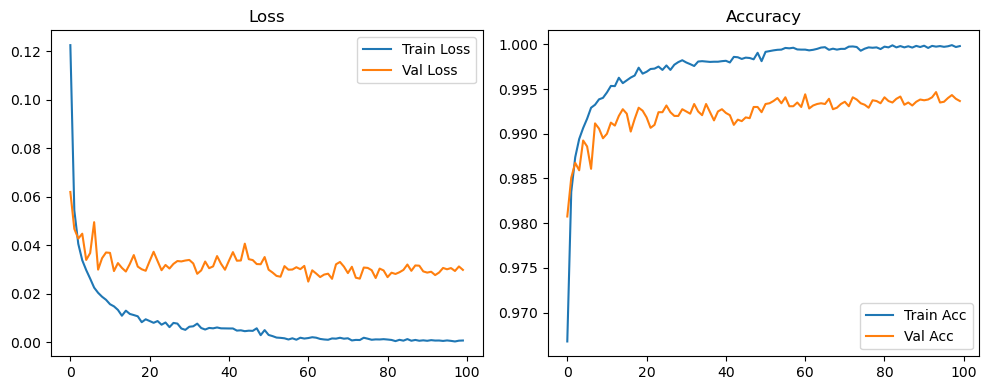

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1869, Acc: 0.9493 | Val Loss: 0.2109, Acc: 0.9388


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0907, Acc: 0.9730 | Val Loss: 0.1660, Acc: 0.9493


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0770, Acc: 0.9765 | Val Loss: 0.0906, Acc: 0.9772


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9802 | Val Loss: 0.1164, Acc: 0.9625


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0618, Acc: 0.9813 | Val Loss: 0.0779, Acc: 0.9784


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9835 | Val Loss: 0.0657, Acc: 0.9823


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9841 | Val Loss: 0.0520, Acc: 0.9876


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9857 | Val Loss: 0.0682, Acc: 0.9802


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9858 | Val Loss: 0.0645, Acc: 0.9816


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9868 | Val Loss: 0.0714, Acc: 0.9793


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9863 | Val Loss: 0.0583, Acc: 0.9838


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9883 | Val Loss: 0.0715, Acc: 0.9791


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9877 | Val Loss: 0.0696, Acc: 0.9794


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9880 | Val Loss: 0.0414, Acc: 0.9884


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9882 | Val Loss: 0.0462, Acc: 0.9873


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9884 | Val Loss: 0.0550, Acc: 0.9840


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.0663, Acc: 0.9801


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9888 | Val Loss: 0.0463, Acc: 0.9872


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9897 | Val Loss: 0.0494, Acc: 0.9862


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0555, Acc: 0.9839


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9908 | Val Loss: 0.0588, Acc: 0.9837


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9900 | Val Loss: 0.0574, Acc: 0.9827


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9896 | Val Loss: 0.0462, Acc: 0.9878


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.0403, Acc: 0.9908


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9908 | Val Loss: 0.0487, Acc: 0.9862


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.0553, Acc: 0.9840


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.0523, Acc: 0.9848


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9913 | Val Loss: 0.0415, Acc: 0.9890


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.0492, Acc: 0.9870


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9916 | Val Loss: 0.0423, Acc: 0.9879


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.0390, Acc: 0.9896


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0368, Acc: 0.9902


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.0466, Acc: 0.9875


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9918 | Val Loss: 0.0479, Acc: 0.9863


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.0503, Acc: 0.9858


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.0389, Acc: 0.9886


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9916 | Val Loss: 0.0579, Acc: 0.9832


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.0457, Acc: 0.9873


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0370, Acc: 0.9894


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.0381, Acc: 0.9898


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.0499, Acc: 0.9861


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9926 | Val Loss: 0.0453, Acc: 0.9875


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.0396, Acc: 0.9884


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.0454, Acc: 0.9875


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9929 | Val Loss: 0.0419, Acc: 0.9888


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.0436, Acc: 0.9885


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9923 | Val Loss: 0.0396, Acc: 0.9898


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0402, Acc: 0.9889


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9923 | Val Loss: 0.0405, Acc: 0.9893


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.0393, Acc: 0.9898


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0380, Acc: 0.9898


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0343, Acc: 0.9909


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9946 | Val Loss: 0.0335, Acc: 0.9912


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0336, Acc: 0.9912


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.0338, Acc: 0.9912


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0383, Acc: 0.9902


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.0363, Acc: 0.9902


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0369, Acc: 0.9898


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0349, Acc: 0.9910


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0330, Acc: 0.9907


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0331, Acc: 0.9917


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0406, Acc: 0.9888


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0298, Acc: 0.9917


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0306, Acc: 0.9912


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0314, Acc: 0.9911


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0319, Acc: 0.9917


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0284, Acc: 0.9909


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0319, Acc: 0.9912


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0341, Acc: 0.9907


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0325, Acc: 0.9912


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0315, Acc: 0.9916


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0333, Acc: 0.9902


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0385, Acc: 0.9898


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0344, Acc: 0.9909


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0357, Acc: 0.9908


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0398, Acc: 0.9890


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0340, Acc: 0.9907


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.0336, Acc: 0.9909


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.0352, Acc: 0.9909


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0333, Acc: 0.9912


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.0277, Acc: 0.9921


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.0367, Acc: 0.9902


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0308, Acc: 0.9914


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0372, Acc: 0.9903


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9960 | Val Loss: 0.0386, Acc: 0.9894


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0354, Acc: 0.9908


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0316, Acc: 0.9912


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0324, Acc: 0.9911


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0325, Acc: 0.9912


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0300, Acc: 0.9920


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0325, Acc: 0.9914


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.0330, Acc: 0.9912


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0313, Acc: 0.9918


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0310, Acc: 0.9917


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0341, Acc: 0.9910


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0365, Acc: 0.9905


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.0367, Acc: 0.9905


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0306, Acc: 0.9918


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0338, Acc: 0.9912


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0347, Acc: 0.9908


Final Test Loss: 0.0292 Accuracy: 0.9925


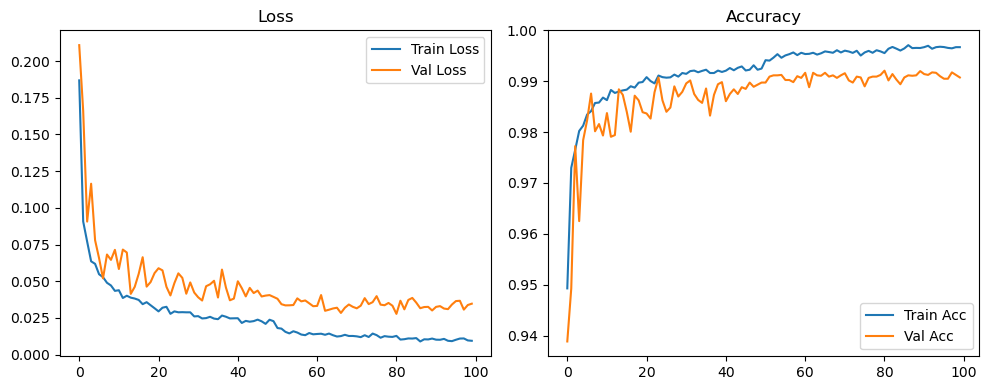

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1156, Acc: 0.9743 | Val Loss: 0.0468, Acc: 0.9858


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9890 | Val Loss: 0.0355, Acc: 0.9885


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9918 | Val Loss: 0.0354, Acc: 0.9892


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.0350, Acc: 0.9897


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.0366, Acc: 0.9895


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0364, Acc: 0.9901


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0330, Acc: 0.9908


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0361, Acc: 0.9896


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0410, Acc: 0.9881


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0314, Acc: 0.9910


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0388, Acc: 0.9903


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0346, Acc: 0.9906


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0401, Acc: 0.9892


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0412, Acc: 0.9905


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0318, Acc: 0.9918


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0365, Acc: 0.9916


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0373, Acc: 0.9920


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0344, Acc: 0.9914


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0346, Acc: 0.9928


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0409, Acc: 0.9922


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0401, Acc: 0.9920


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0383, Acc: 0.9911


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0381, Acc: 0.9919


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0388, Acc: 0.9916


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0399, Acc: 0.9918


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0343, Acc: 0.9917


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0406, Acc: 0.9918


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0357, Acc: 0.9922


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0350, Acc: 0.9928


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0368, Acc: 0.9922


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0326, Acc: 0.9921


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0383, Acc: 0.9913


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0357, Acc: 0.9930


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0399, Acc: 0.9915


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0420, Acc: 0.9909


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0355, Acc: 0.9928


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0383, Acc: 0.9928


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0393, Acc: 0.9925


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0466, Acc: 0.9914


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0352, Acc: 0.9935


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0417, Acc: 0.9923


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0465, Acc: 0.9917


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0430, Acc: 0.9928


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0393, Acc: 0.9933


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0440, Acc: 0.9926


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0420, Acc: 0.9926


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0388, Acc: 0.9936


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0412, Acc: 0.9916


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0458, Acc: 0.9917


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0361, Acc: 0.9932


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0380, Acc: 0.9933


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0390, Acc: 0.9932


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0412, Acc: 0.9931


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0430, Acc: 0.9930


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0498, Acc: 0.9908


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0444, Acc: 0.9918


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0395, Acc: 0.9926


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0377, Acc: 0.9930


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0463, Acc: 0.9918


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0464, Acc: 0.9918


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0431, Acc: 0.9924


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0396, Acc: 0.9938


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.0509, Acc: 0.9922


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0451, Acc: 0.9921


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0440, Acc: 0.9936


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0445, Acc: 0.9927


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0449, Acc: 0.9931


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0467, Acc: 0.9925


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0468, Acc: 0.9916


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0446, Acc: 0.9932


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0481, Acc: 0.9930


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0481, Acc: 0.9928


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0507, Acc: 0.9914


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0455, Acc: 0.9928


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0442, Acc: 0.9934


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0495, Acc: 0.9932


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0522, Acc: 0.9924


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0490, Acc: 0.9924


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0485, Acc: 0.9931


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0440, Acc: 0.9932


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0430, Acc: 0.9931


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0480, Acc: 0.9926


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0493, Acc: 0.9919


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0439, Acc: 0.9936


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0420, Acc: 0.9938


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0406, Acc: 0.9931


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0415, Acc: 0.9942


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0500, Acc: 0.9932


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0535, Acc: 0.9920


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0506, Acc: 0.9926


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0543, Acc: 0.9915


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0475, Acc: 0.9912


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0419, Acc: 0.9929


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0451, Acc: 0.9928


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0462, Acc: 0.9925


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0426, Acc: 0.9935


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0448, Acc: 0.9934


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0444, Acc: 0.9934


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0468, Acc: 0.9936


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0486, Acc: 0.9932


Final Test Loss: 0.0466 Accuracy: 0.9923


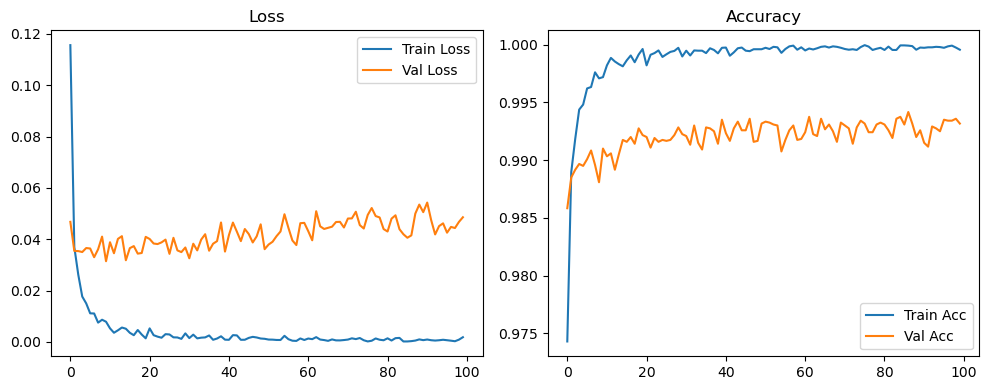

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1366, Acc: 0.9694 | Val Loss: 0.0629, Acc: 0.9819


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0500, Acc: 0.9846 | Val Loss: 0.0475, Acc: 0.9849


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9877 | Val Loss: 0.0397, Acc: 0.9884


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9909 | Val Loss: 0.0441, Acc: 0.9865


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.0333, Acc: 0.9901


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9927 | Val Loss: 0.0375, Acc: 0.9884


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9936 | Val Loss: 0.0363, Acc: 0.9892


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.0290, Acc: 0.9915


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.0344, Acc: 0.9896


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0318, Acc: 0.9908


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0324, Acc: 0.9909


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0300, Acc: 0.9921


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0336, Acc: 0.9903


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0289, Acc: 0.9932


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0287, Acc: 0.9922


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.0298, Acc: 0.9917


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0364, Acc: 0.9895


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0337, Acc: 0.9911


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0295, Acc: 0.9920


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9973 | Val Loss: 0.0350, Acc: 0.9915


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.0308, Acc: 0.9933


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0375, Acc: 0.9914


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0298, Acc: 0.9931


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0370, Acc: 0.9912


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0374, Acc: 0.9917


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0315, Acc: 0.9920


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0359, Acc: 0.9916


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0342, Acc: 0.9928


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0331, Acc: 0.9921


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0343, Acc: 0.9922


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0369, Acc: 0.9922


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0311, Acc: 0.9928


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0360, Acc: 0.9918


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0358, Acc: 0.9919


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0345, Acc: 0.9918


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0313, Acc: 0.9931


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0297, Acc: 0.9926


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0342, Acc: 0.9929


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0323, Acc: 0.9927


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0319, Acc: 0.9930


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0308, Acc: 0.9932


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.0299, Acc: 0.9935


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0344, Acc: 0.9922


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0279, Acc: 0.9932


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0325, Acc: 0.9925


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0349, Acc: 0.9931


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0320, Acc: 0.9932


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0311, Acc: 0.9933


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0343, Acc: 0.9929


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0384, Acc: 0.9918


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0397, Acc: 0.9910


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0401, Acc: 0.9916


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0319, Acc: 0.9931


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0328, Acc: 0.9923


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0331, Acc: 0.9928


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0335, Acc: 0.9928


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0381, Acc: 0.9923


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0320, Acc: 0.9929


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0357, Acc: 0.9931


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0330, Acc: 0.9925


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0312, Acc: 0.9929


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0381, Acc: 0.9920


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0329, Acc: 0.9926


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0353, Acc: 0.9927


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0387, Acc: 0.9919


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0384, Acc: 0.9925


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0365, Acc: 0.9926


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0364, Acc: 0.9930


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0312, Acc: 0.9938


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0332, Acc: 0.9938


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0357, Acc: 0.9935


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0389, Acc: 0.9928


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0378, Acc: 0.9929


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0407, Acc: 0.9922


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0396, Acc: 0.9920


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0317, Acc: 0.9940


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0331, Acc: 0.9936


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0351, Acc: 0.9928


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0367, Acc: 0.9928


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0336, Acc: 0.9935


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0307, Acc: 0.9938


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0337, Acc: 0.9936


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0411, Acc: 0.9932


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0401, Acc: 0.9923


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0348, Acc: 0.9931


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0322, Acc: 0.9938


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0299, Acc: 0.9941


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0319, Acc: 0.9935


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.0374, Acc: 0.9928


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0355, Acc: 0.9922


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0431, Acc: 0.9912


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0360, Acc: 0.9923


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0288, Acc: 0.9940


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0328, Acc: 0.9926


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0382, Acc: 0.9925


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0309, Acc: 0.9931


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0405, Acc: 0.9921


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0366, Acc: 0.9928


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0305, Acc: 0.9939


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0372, Acc: 0.9926


Final Test Loss: 0.0336 Accuracy: 0.9919


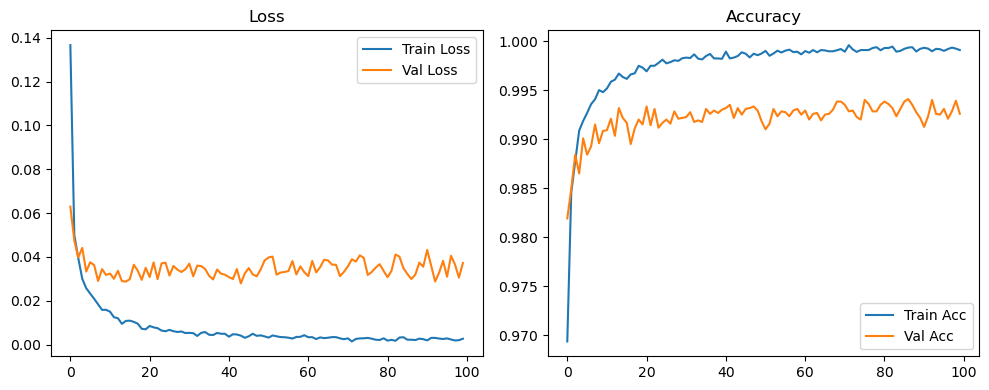

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2105, Acc: 0.9500 | Val Loss: 0.1533, Acc: 0.9671


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0893, Acc: 0.9741 | Val Loss: 0.1191, Acc: 0.9699


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0756, Acc: 0.9774 | Val Loss: 0.0831, Acc: 0.9812


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0619, Acc: 0.9809 | Val Loss: 0.0791, Acc: 0.9790


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0589, Acc: 0.9824 | Val Loss: 0.0622, Acc: 0.9847


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0545, Acc: 0.9835 | Val Loss: 0.0641, Acc: 0.9837


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0535, Acc: 0.9842 | Val Loss: 0.0511, Acc: 0.9871


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9861 | Val Loss: 0.0549, Acc: 0.9855


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9874 | Val Loss: 0.0551, Acc: 0.9852


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9875 | Val Loss: 0.0525, Acc: 0.9858


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9873 | Val Loss: 0.0479, Acc: 0.9873


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9886 | Val Loss: 0.0419, Acc: 0.9892


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9884 | Val Loss: 0.0432, Acc: 0.9886


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9891 | Val Loss: 0.0372, Acc: 0.9902


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9892 | Val Loss: 0.0371, Acc: 0.9895


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 0.0413, Acc: 0.9890


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9900 | Val Loss: 0.0549, Acc: 0.9838


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9897 | Val Loss: 0.0417, Acc: 0.9881


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9908 | Val Loss: 0.0422, Acc: 0.9879


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9912 | Val Loss: 0.0406, Acc: 0.9891


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9911 | Val Loss: 0.0440, Acc: 0.9875


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9908 | Val Loss: 0.0385, Acc: 0.9891


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9912 | Val Loss: 0.0432, Acc: 0.9874


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.0323, Acc: 0.9915


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9916 | Val Loss: 0.0410, Acc: 0.9885


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9911 | Val Loss: 0.0389, Acc: 0.9892


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.0397, Acc: 0.9890


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.0315, Acc: 0.9913


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9925 | Val Loss: 0.0356, Acc: 0.9892


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9924 | Val Loss: 0.0354, Acc: 0.9904


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.0391, Acc: 0.9888


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.0361, Acc: 0.9901


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9924 | Val Loss: 0.0398, Acc: 0.9882


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9920 | Val Loss: 0.0325, Acc: 0.9903


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9930 | Val Loss: 0.0340, Acc: 0.9902


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9925 | Val Loss: 0.0301, Acc: 0.9915


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.0349, Acc: 0.9897


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9923 | Val Loss: 0.0338, Acc: 0.9899


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9932 | Val Loss: 0.0358, Acc: 0.9895


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.0343, Acc: 0.9908


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.0338, Acc: 0.9908


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.0426, Acc: 0.9866


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9930 | Val Loss: 0.0337, Acc: 0.9899


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9939 | Val Loss: 0.0407, Acc: 0.9885


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.0382, Acc: 0.9898


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0332, Acc: 0.9909


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 0.0393, Acc: 0.9889


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0389, Acc: 0.9888


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.0379, Acc: 0.9902


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9934 | Val Loss: 0.0408, Acc: 0.9893


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0313, Acc: 0.9918


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.0316, Acc: 0.9908


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.0346, Acc: 0.9910


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0353, Acc: 0.9903


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9932 | Val Loss: 0.0328, Acc: 0.9910


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9942 | Val Loss: 0.0391, Acc: 0.9892


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9947 | Val Loss: 0.0312, Acc: 0.9917


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0304, Acc: 0.9918


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0341, Acc: 0.9902


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.0290, Acc: 0.9926


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.0331, Acc: 0.9906


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9943 | Val Loss: 0.0387, Acc: 0.9896


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0363, Acc: 0.9896


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0297, Acc: 0.9919


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9943 | Val Loss: 0.0269, Acc: 0.9926


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.0308, Acc: 0.9920


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0295, Acc: 0.9918


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.0314, Acc: 0.9914


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.0342, Acc: 0.9906


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9941 | Val Loss: 0.0343, Acc: 0.9908


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0362, Acc: 0.9902


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.0333, Acc: 0.9899


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.0365, Acc: 0.9896


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9947 | Val Loss: 0.0354, Acc: 0.9900


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9947 | Val Loss: 0.0284, Acc: 0.9918


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.0295, Acc: 0.9918


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0315, Acc: 0.9916


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0312, Acc: 0.9915


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9949 | Val Loss: 0.0273, Acc: 0.9920


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9941 | Val Loss: 0.0292, Acc: 0.9916


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.0247, Acc: 0.9933


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0266, Acc: 0.9932


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.0294, Acc: 0.9914


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0334, Acc: 0.9909


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.0323, Acc: 0.9913


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.0316, Acc: 0.9908


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.0305, Acc: 0.9918


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0339, Acc: 0.9911


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0335, Acc: 0.9908


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0288, Acc: 0.9918


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0330, Acc: 0.9909


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.0422, Acc: 0.9878


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.0309, Acc: 0.9914


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0287, Acc: 0.9928


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0334, Acc: 0.9911


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0308, Acc: 0.9919


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0354, Acc: 0.9912


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.0302, Acc: 0.9920


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.0316, Acc: 0.9918


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0288, Acc: 0.9922


Final Test Loss: 0.0239 Accuracy: 0.9931


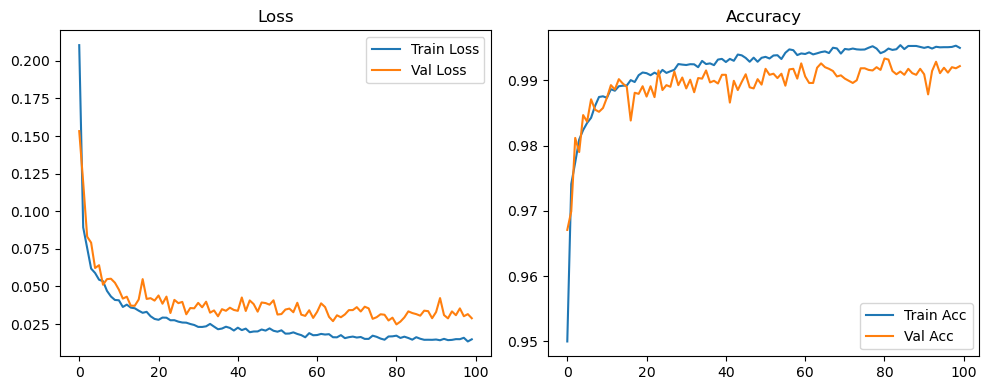

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1462, Acc: 0.9738 | Val Loss: 0.0496, Acc: 0.9853


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9893 | Val Loss: 0.0380, Acc: 0.9893


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9924 | Val Loss: 0.0368, Acc: 0.9889


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9949 | Val Loss: 0.0327, Acc: 0.9898


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0354, Acc: 0.9897


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0347, Acc: 0.9905


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0365, Acc: 0.9896


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.0314, Acc: 0.9909


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0410, Acc: 0.9892


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0341, Acc: 0.9908


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0359, Acc: 0.9899


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0349, Acc: 0.9910


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.0329, Acc: 0.9912


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0386, Acc: 0.9894


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0314, Acc: 0.9920


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0341, Acc: 0.9913


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0358, Acc: 0.9910


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0352, Acc: 0.9906


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0352, Acc: 0.9923


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0405, Acc: 0.9906


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0372, Acc: 0.9917


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0408, Acc: 0.9910


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0354, Acc: 0.9918


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0391, Acc: 0.9909


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0364, Acc: 0.9928


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0387, Acc: 0.9922


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0377, Acc: 0.9924


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0414, Acc: 0.9904


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0369, Acc: 0.9927


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0389, Acc: 0.9916


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0333, Acc: 0.9933


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0304, Acc: 0.9931


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0335, Acc: 0.9923


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0406, Acc: 0.9911


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0373, Acc: 0.9923


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0367, Acc: 0.9921


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0385, Acc: 0.9922


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0448, Acc: 0.9908


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0379, Acc: 0.9919


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0346, Acc: 0.9929


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0393, Acc: 0.9924


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0384, Acc: 0.9927


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0379, Acc: 0.9932


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0477, Acc: 0.9913


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0389, Acc: 0.9914


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0341, Acc: 0.9931


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0446, Acc: 0.9913


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0458, Acc: 0.9911


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0383, Acc: 0.9925


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0374, Acc: 0.9922


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0383, Acc: 0.9935


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0352, Acc: 0.9931


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9930


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0412, Acc: 0.9923


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0468, Acc: 0.9920


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0379, Acc: 0.9924


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9931


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0436, Acc: 0.9918


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0449, Acc: 0.9917


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0354, Acc: 0.9925


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0427, Acc: 0.9912


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0383, Acc: 0.9928


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0353, Acc: 0.9931


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0452, Acc: 0.9911


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0425, Acc: 0.9923


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0379, Acc: 0.9929


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0451, Acc: 0.9918


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0374, Acc: 0.9928


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0373, Acc: 0.9928


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9932


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0415, Acc: 0.9926


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0399, Acc: 0.9927


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9928


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0444, Acc: 0.9930


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0489, Acc: 0.9917


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0395, Acc: 0.9933


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0440, Acc: 0.9923


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0443, Acc: 0.9928


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0392, Acc: 0.9932


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0385, Acc: 0.9932


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0416, Acc: 0.9926


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0427, Acc: 0.9929


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0451, Acc: 0.9932


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0447, Acc: 0.9921


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0428, Acc: 0.9935


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0433, Acc: 0.9927


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0446, Acc: 0.9922


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0477, Acc: 0.9927


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0481, Acc: 0.9928


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0451, Acc: 0.9932


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0483, Acc: 0.9918


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0530, Acc: 0.9910


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0437, Acc: 0.9920


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0437, Acc: 0.9927


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0450, Acc: 0.9921


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0438, Acc: 0.9935


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9934


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9938


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0466, Acc: 0.9930


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0434, Acc: 0.9930


Final Test Loss: 0.0416 Accuracy: 0.9922


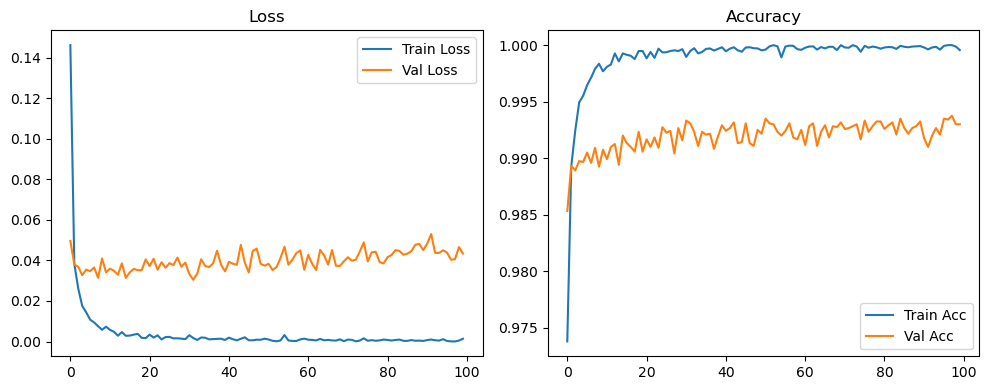

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1700, Acc: 0.9690 | Val Loss: 0.0740, Acc: 0.9810


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0519, Acc: 0.9853 | Val Loss: 0.0518, Acc: 0.9859


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9883 | Val Loss: 0.0429, Acc: 0.9878


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9909 | Val Loss: 0.0435, Acc: 0.9868


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9924 | Val Loss: 0.0331, Acc: 0.9896


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9926 | Val Loss: 0.0403, Acc: 0.9872


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0327, Acc: 0.9902


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.0281, Acc: 0.9912


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0299, Acc: 0.9912


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0287, Acc: 0.9912


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0305, Acc: 0.9904


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0273, Acc: 0.9922


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0321, Acc: 0.9912


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.0277, Acc: 0.9921


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0307, Acc: 0.9918


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.0285, Acc: 0.9925


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0332, Acc: 0.9907


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0316, Acc: 0.9904


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0295, Acc: 0.9924


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0312, Acc: 0.9923


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0335, Acc: 0.9917


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0322, Acc: 0.9920


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0291, Acc: 0.9922


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0300, Acc: 0.9923


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9978 | Val Loss: 0.0360, Acc: 0.9921


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0319, Acc: 0.9918


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0305, Acc: 0.9932


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0352, Acc: 0.9916


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0349, Acc: 0.9917


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0300, Acc: 0.9926


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0329, Acc: 0.9920


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0362, Acc: 0.9921


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0324, Acc: 0.9920


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0323, Acc: 0.9925


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0375, Acc: 0.9913


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0315, Acc: 0.9931


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0367, Acc: 0.9916


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0335, Acc: 0.9917


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0372, Acc: 0.9918


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0393, Acc: 0.9920


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0424, Acc: 0.9920


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0383, Acc: 0.9925


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0377, Acc: 0.9928


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0388, Acc: 0.9920


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0460, Acc: 0.9908


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0369, Acc: 0.9923


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0375, Acc: 0.9928


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0363, Acc: 0.9920


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0366, Acc: 0.9928


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0370, Acc: 0.9935


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0355, Acc: 0.9931


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0363, Acc: 0.9931


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0367, Acc: 0.9929


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0346, Acc: 0.9932


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0379, Acc: 0.9918


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0343, Acc: 0.9930


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0352, Acc: 0.9922


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0342, Acc: 0.9930


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0353, Acc: 0.9924


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0370, Acc: 0.9927


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0329, Acc: 0.9931


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0357, Acc: 0.9928


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0323, Acc: 0.9937


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0330, Acc: 0.9935


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0337, Acc: 0.9935


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0423, Acc: 0.9929


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0365, Acc: 0.9928


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0407, Acc: 0.9929


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0377, Acc: 0.9924


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0377, Acc: 0.9927


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0390, Acc: 0.9928


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9989 | Val Loss: 0.0388, Acc: 0.9928


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0424, Acc: 0.9921


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0421, Acc: 0.9926


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0393, Acc: 0.9926


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0425, Acc: 0.9928


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0435, Acc: 0.9931


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0409, Acc: 0.9932


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0411, Acc: 0.9927


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0395, Acc: 0.9937


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0385, Acc: 0.9937


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0434, Acc: 0.9923


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0390, Acc: 0.9935


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0365, Acc: 0.9931


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0354, Acc: 0.9938


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0425, Acc: 0.9922


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0372, Acc: 0.9930


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0419, Acc: 0.9928


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0409, Acc: 0.9927


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0432, Acc: 0.9926


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0357, Acc: 0.9935


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0440, Acc: 0.9923


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0377, Acc: 0.9937


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0394, Acc: 0.9930


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0452, Acc: 0.9919


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0395, Acc: 0.9928


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0419, Acc: 0.9927


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0383, Acc: 0.9928


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0372, Acc: 0.9938


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0368, Acc: 0.9940


Final Test Loss: 0.0280 Accuracy: 0.9943


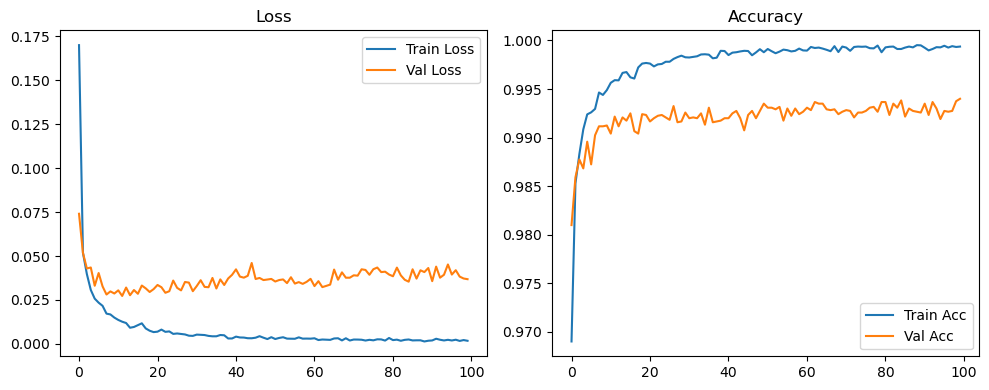

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2603, Acc: 0.9480 | Val Loss: 0.2117, Acc: 0.9596


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0956, Acc: 0.9730 | Val Loss: 0.1373, Acc: 0.9712


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0774, Acc: 0.9773 | Val Loss: 0.1094, Acc: 0.9765


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0654, Acc: 0.9797 | Val Loss: 0.0781, Acc: 0.9827


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0612, Acc: 0.9822 | Val Loss: 0.0716, Acc: 0.9824


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0558, Acc: 0.9835 | Val Loss: 0.0799, Acc: 0.9803


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0537, Acc: 0.9842 | Val Loss: 0.0652, Acc: 0.9859


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0481, Acc: 0.9853 | Val Loss: 0.0611, Acc: 0.9855


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0459, Acc: 0.9861 | Val Loss: 0.0628, Acc: 0.9846


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9867 | Val Loss: 0.0499, Acc: 0.9884


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9874 | Val Loss: 0.0518, Acc: 0.9878


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9884 | Val Loss: 0.0489, Acc: 0.9882


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9873 | Val Loss: 0.0476, Acc: 0.9892


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9891 | Val Loss: 0.0440, Acc: 0.9894


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9888 | Val Loss: 0.0413, Acc: 0.9904


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9896 | Val Loss: 0.0429, Acc: 0.9891


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9895 | Val Loss: 0.0459, Acc: 0.9878


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9905 | Val Loss: 0.0414, Acc: 0.9891


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9897 | Val Loss: 0.0421, Acc: 0.9892


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9908 | Val Loss: 0.0404, Acc: 0.9894


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9912 | Val Loss: 0.0451, Acc: 0.9876


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 0.0370, Acc: 0.9896


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9911 | Val Loss: 0.0411, Acc: 0.9881


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9914 | Val Loss: 0.0389, Acc: 0.9898


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9907 | Val Loss: 0.0400, Acc: 0.9891


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 0.0398, Acc: 0.9898


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9919 | Val Loss: 0.0409, Acc: 0.9878


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0355, Acc: 0.9905


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.0411, Acc: 0.9882


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9923 | Val Loss: 0.0403, Acc: 0.9887


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0356, Acc: 0.9901


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.0340, Acc: 0.9906


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9929 | Val Loss: 0.0338, Acc: 0.9909


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 0.0404, Acc: 0.9889


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.0422, Acc: 0.9872


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.0369, Acc: 0.9896


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0356, Acc: 0.9901


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.0398, Acc: 0.9885


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.0394, Acc: 0.9881


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0387, Acc: 0.9892


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9932 | Val Loss: 0.0325, Acc: 0.9906


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.0396, Acc: 0.9876


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0334, Acc: 0.9908


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.0356, Acc: 0.9896


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9941 | Val Loss: 0.0388, Acc: 0.9888


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.0323, Acc: 0.9906


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0330, Acc: 0.9903


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0369, Acc: 0.9895


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0311, Acc: 0.9920


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9945 | Val Loss: 0.0374, Acc: 0.9898


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.0341, Acc: 0.9909


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0293, Acc: 0.9918


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.0417, Acc: 0.9879


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9942 | Val Loss: 0.0340, Acc: 0.9908


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0317, Acc: 0.9918


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.0463, Acc: 0.9869


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0428, Acc: 0.9878


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0395, Acc: 0.9893


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0420, Acc: 0.9883


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.0412, Acc: 0.9883


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.0459, Acc: 0.9868


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0441, Acc: 0.9877


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0384, Acc: 0.9888


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0339, Acc: 0.9910


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0342, Acc: 0.9904


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9942 | Val Loss: 0.0387, Acc: 0.9892


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.0338, Acc: 0.9899


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0415, Acc: 0.9878


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0371, Acc: 0.9891


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.0391, Acc: 0.9892


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0392, Acc: 0.9888


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9951 | Val Loss: 0.0454, Acc: 0.9874


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0522, Acc: 0.9852


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9953 | Val Loss: 0.0384, Acc: 0.9893


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9953 | Val Loss: 0.0359, Acc: 0.9899


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0443, Acc: 0.9875


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0465, Acc: 0.9865


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0362, Acc: 0.9894


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.0369, Acc: 0.9892


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0364, Acc: 0.9898


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.0407, Acc: 0.9885


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.0387, Acc: 0.9891


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.0451, Acc: 0.9871


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.0496, Acc: 0.9856


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0470, Acc: 0.9877


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0521, Acc: 0.9861


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0411, Acc: 0.9890


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0536, Acc: 0.9862


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0477, Acc: 0.9872


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9958 | Val Loss: 0.0424, Acc: 0.9892


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.0461, Acc: 0.9874


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9947 | Val Loss: 0.0521, Acc: 0.9869


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0444, Acc: 0.9884


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9949 | Val Loss: 0.0394, Acc: 0.9898


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0488, Acc: 0.9877


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.0467, Acc: 0.9878


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.0469, Acc: 0.9875


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.0527, Acc: 0.9852


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0459, Acc: 0.9882


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0658, Acc: 0.9832


Final Test Loss: 0.0489 Accuracy: 0.9865


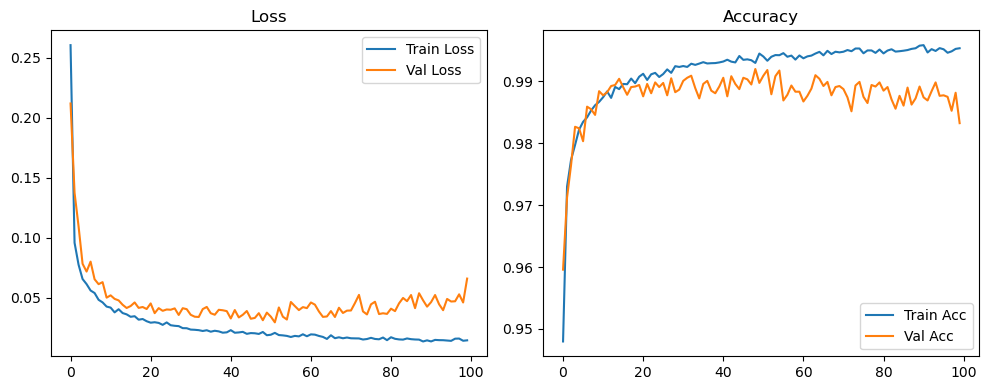

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1065, Acc: 0.9699 | Val Loss: 0.0525, Acc: 0.9840


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9875 | Val Loss: 0.0527, Acc: 0.9838


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9914 | Val Loss: 0.0418, Acc: 0.9881


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.0393, Acc: 0.9892


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.0415, Acc: 0.9885


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.0418, Acc: 0.9892


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0413, Acc: 0.9890


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0379, Acc: 0.9902


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0553, Acc: 0.9873


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0413, Acc: 0.9893


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0516, Acc: 0.9880


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0528, Acc: 0.9896


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0467, Acc: 0.9893


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0459, Acc: 0.9897


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0417, Acc: 0.9924


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0428, Acc: 0.9900


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0446, Acc: 0.9910


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0506, Acc: 0.9911


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0461, Acc: 0.9911


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0389, Acc: 0.9918


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0434, Acc: 0.9916


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0460, Acc: 0.9904


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0445, Acc: 0.9920


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0452, Acc: 0.9920


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0506, Acc: 0.9909


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0493, Acc: 0.9904


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0479, Acc: 0.9902


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0457, Acc: 0.9919


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0550, Acc: 0.9904


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0491, Acc: 0.9909


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0507, Acc: 0.9926


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0656, Acc: 0.9898


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0474, Acc: 0.9927


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0605, Acc: 0.9898


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0513, Acc: 0.9918


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0536, Acc: 0.9918


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0501, Acc: 0.9919


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0565, Acc: 0.9901


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.0761, Acc: 0.9894


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0904, Acc: 0.9862


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0621, Acc: 0.9918


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0531, Acc: 0.9915


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0573, Acc: 0.9908


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0676, Acc: 0.9907


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0608, Acc: 0.9908


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0588, Acc: 0.9909


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0542, Acc: 0.9918


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0445, Acc: 0.9932


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9938


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9985 | Val Loss: 0.0664, Acc: 0.9904


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0499, Acc: 0.9920


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0436, Acc: 0.9935


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0467, Acc: 0.9927


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0577, Acc: 0.9911


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0555, Acc: 0.9922


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0518, Acc: 0.9924


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0675, Acc: 0.9908


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0550, Acc: 0.9929


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0605, Acc: 0.9925


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0721, Acc: 0.9915


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9985 | Val Loss: 0.0698, Acc: 0.9909


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0650, Acc: 0.9914


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0528, Acc: 0.9930


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0729, Acc: 0.9912


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0654, Acc: 0.9923


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0750, Acc: 0.9918


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0695, Acc: 0.9922


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0646, Acc: 0.9911


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0700, Acc: 0.9910


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0648, Acc: 0.9928


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0779, Acc: 0.9911


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0598, Acc: 0.9919


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0683, Acc: 0.9917


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0622, Acc: 0.9916


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0618, Acc: 0.9927


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0732, Acc: 0.9910


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0731, Acc: 0.9908


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0711, Acc: 0.9912


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0683, Acc: 0.9917


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0894, Acc: 0.9908


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0696, Acc: 0.9917


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0803, Acc: 0.9913


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0739, Acc: 0.9918


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0740, Acc: 0.9907


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0756, Acc: 0.9912


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0852, Acc: 0.9914


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0786, Acc: 0.9922


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0737, Acc: 0.9923


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9997 | Val Loss: 0.0758, Acc: 0.9920


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0728, Acc: 0.9924


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0858, Acc: 0.9921


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0802, Acc: 0.9915


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0839, Acc: 0.9916


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0823, Acc: 0.9922


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1019, Acc: 0.9904


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0888, Acc: 0.9906


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0794, Acc: 0.9917


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0779, Acc: 0.9919


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0786, Acc: 0.9919


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0772, Acc: 0.9923


Final Test Loss: 0.0603 Accuracy: 0.9928


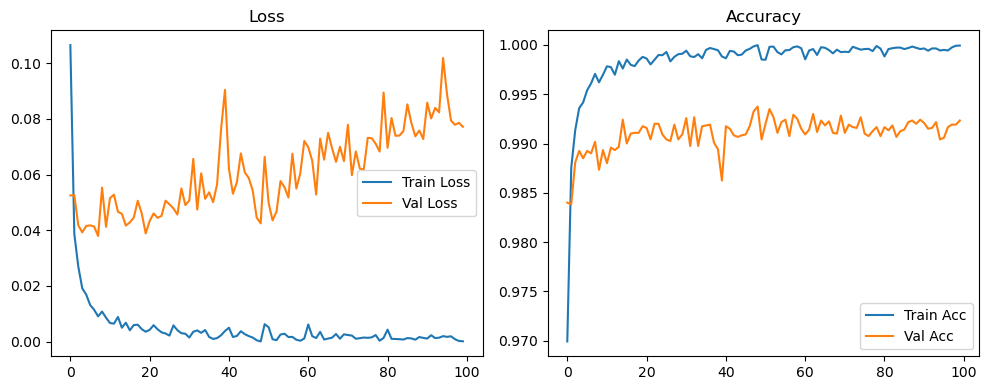

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1284, Acc: 0.9633 | Val Loss: 0.0909, Acc: 0.9722


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9826 | Val Loss: 0.0489, Acc: 0.9845


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9869 | Val Loss: 0.0446, Acc: 0.9855


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9898 | Val Loss: 0.0454, Acc: 0.9855


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9916 | Val Loss: 0.0368, Acc: 0.9888


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0385, Acc: 0.9879


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.0435, Acc: 0.9878


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9928 | Val Loss: 0.0344, Acc: 0.9894


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0426, Acc: 0.9882


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.0315, Acc: 0.9904


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9947 | Val Loss: 0.0358, Acc: 0.9903


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0379, Acc: 0.9897


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0290, Acc: 0.9922


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0306, Acc: 0.9911


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9956 | Val Loss: 0.0321, Acc: 0.9916


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0333, Acc: 0.9902


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0511, Acc: 0.9868


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0402, Acc: 0.9894


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.0346, Acc: 0.9908


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0324, Acc: 0.9918


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0290, Acc: 0.9924


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0435, Acc: 0.9906


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0322, Acc: 0.9917


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0408, Acc: 0.9904


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.0575, Acc: 0.9863


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0330, Acc: 0.9922


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0396, Acc: 0.9904


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0409, Acc: 0.9898


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0399, Acc: 0.9901


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0356, Acc: 0.9911


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0350, Acc: 0.9912


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0404, Acc: 0.9904


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0372, Acc: 0.9907


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0478, Acc: 0.9898


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0364, Acc: 0.9919


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0333, Acc: 0.9922


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0436, Acc: 0.9907


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0409, Acc: 0.9908


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0391, Acc: 0.9922


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0407, Acc: 0.9899


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0502, Acc: 0.9889


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0378, Acc: 0.9919


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0390, Acc: 0.9907


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0460, Acc: 0.9908


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0447, Acc: 0.9899


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0399, Acc: 0.9914


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0386, Acc: 0.9917


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0468, Acc: 0.9905


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0438, Acc: 0.9908


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0504, Acc: 0.9901


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0365, Acc: 0.9922


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0430, Acc: 0.9907


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0368, Acc: 0.9912


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0445, Acc: 0.9909


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0504, Acc: 0.9907


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0541, Acc: 0.9895


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0442, Acc: 0.9914


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0461, Acc: 0.9892


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0491, Acc: 0.9912


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0439, Acc: 0.9898


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0414, Acc: 0.9909


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0445, Acc: 0.9914


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0396, Acc: 0.9919


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0491, Acc: 0.9898


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0452, Acc: 0.9904


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0371, Acc: 0.9919


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0398, Acc: 0.9922


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0411, Acc: 0.9910


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0456, Acc: 0.9909


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0455, Acc: 0.9904


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0422, Acc: 0.9913


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0404, Acc: 0.9926


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0484, Acc: 0.9904


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0453, Acc: 0.9915


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0424, Acc: 0.9911


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0458, Acc: 0.9907


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0429, Acc: 0.9912


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0385, Acc: 0.9920


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0466, Acc: 0.9910


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0433, Acc: 0.9912


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0412, Acc: 0.9926


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0508, Acc: 0.9907


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0434, Acc: 0.9912


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0431, Acc: 0.9912


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0456, Acc: 0.9917


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0406, Acc: 0.9916


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0403, Acc: 0.9920


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0418, Acc: 0.9917


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0422, Acc: 0.9917


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0373, Acc: 0.9919


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0434, Acc: 0.9917


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0431, Acc: 0.9915


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0436, Acc: 0.9918


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0476, Acc: 0.9908


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0476, Acc: 0.9912


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0407, Acc: 0.9912


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0352, Acc: 0.9928


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0418, Acc: 0.9920


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0405, Acc: 0.9911


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.0413, Acc: 0.9920


Final Test Loss: 0.0317 Accuracy: 0.9921


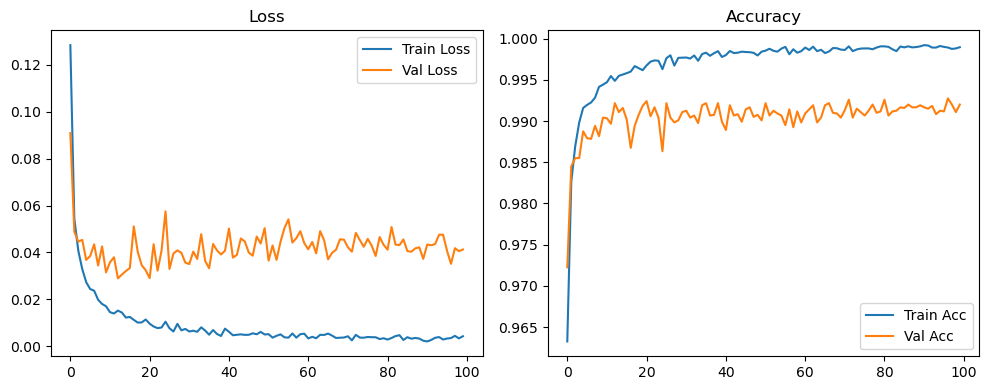

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1945, Acc: 0.9448 | Val Loss: 0.3376, Acc: 0.8908


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0929, Acc: 0.9716 | Val Loss: 0.1929, Acc: 0.9457


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9776 | Val Loss: 0.1003, Acc: 0.9738


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9797 | Val Loss: 0.0950, Acc: 0.9738


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9831 | Val Loss: 0.1313, Acc: 0.9581


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9828 | Val Loss: 0.1071, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9849 | Val Loss: 0.0944, Acc: 0.9702


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9851 | Val Loss: 0.0879, Acc: 0.9726


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9852 | Val Loss: 0.0761, Acc: 0.9769


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9864 | Val Loss: 0.0614, Acc: 0.9819


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9870 | Val Loss: 0.0735, Acc: 0.9772


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9868 | Val Loss: 0.0901, Acc: 0.9722


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9873 | Val Loss: 0.0667, Acc: 0.9792


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9879 | Val Loss: 0.0587, Acc: 0.9813


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9887 | Val Loss: 0.0469, Acc: 0.9854


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9876 | Val Loss: 0.0420, Acc: 0.9878


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9890 | Val Loss: 0.0956, Acc: 0.9688


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9891 | Val Loss: 0.0478, Acc: 0.9862


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9890 | Val Loss: 0.0516, Acc: 0.9846


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9901 | Val Loss: 0.0485, Acc: 0.9848


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9891 | Val Loss: 0.0494, Acc: 0.9847


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 0.0488, Acc: 0.9850


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9909 | Val Loss: 0.0600, Acc: 0.9822


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9907 | Val Loss: 0.0467, Acc: 0.9853


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9908 | Val Loss: 0.0507, Acc: 0.9845


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9911 | Val Loss: 0.0465, Acc: 0.9860


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9912 | Val Loss: 0.0336, Acc: 0.9901


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9918 | Val Loss: 0.0587, Acc: 0.9818


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9911 | Val Loss: 0.0341, Acc: 0.9899


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9911 | Val Loss: 0.0424, Acc: 0.9878


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9907 | Val Loss: 0.0422, Acc: 0.9870


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9911 | Val Loss: 0.0458, Acc: 0.9861


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0441, Acc: 0.9866


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9915 | Val Loss: 0.0427, Acc: 0.9877


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.0523, Acc: 0.9842


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9911 | Val Loss: 0.0349, Acc: 0.9888


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9920 | Val Loss: 0.0426, Acc: 0.9870


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.0338, Acc: 0.9895


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.0372, Acc: 0.9878


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.0348, Acc: 0.9898


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.0449, Acc: 0.9863


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9923 | Val Loss: 0.0386, Acc: 0.9881


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9922 | Val Loss: 0.0428, Acc: 0.9876


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9925 | Val Loss: 0.0394, Acc: 0.9884


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.0455, Acc: 0.9851


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0445, Acc: 0.9865


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0347, Acc: 0.9893


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.0283, Acc: 0.9916


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.0444, Acc: 0.9858


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.0537, Acc: 0.9832


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.0321, Acc: 0.9899


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9928 | Val Loss: 0.0460, Acc: 0.9860


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0388, Acc: 0.9879


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9937 | Val Loss: 0.0334, Acc: 0.9904


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0341, Acc: 0.9897


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0363, Acc: 0.9897


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0446, Acc: 0.9873


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 0.0375, Acc: 0.9886


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.0317, Acc: 0.9908


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.0387, Acc: 0.9879


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9934 | Val Loss: 0.0403, Acc: 0.9882


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0419, Acc: 0.9872


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.0362, Acc: 0.9886


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9937 | Val Loss: 0.0532, Acc: 0.9828


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.0348, Acc: 0.9884


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9947 | Val Loss: 0.0364, Acc: 0.9891


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.0457, Acc: 0.9857


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.0285, Acc: 0.9910


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9941 | Val Loss: 0.0442, Acc: 0.9874


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.0389, Acc: 0.9881


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.0415, Acc: 0.9871


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0374, Acc: 0.9888


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0418, Acc: 0.9871


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0345, Acc: 0.9885


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.0428, Acc: 0.9862


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0278, Acc: 0.9925


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0328, Acc: 0.9906


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9947 | Val Loss: 0.0327, Acc: 0.9906


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.0326, Acc: 0.9905


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0283, Acc: 0.9922


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9942 | Val Loss: 0.0291, Acc: 0.9917


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.0295, Acc: 0.9910


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.0329, Acc: 0.9901


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0442, Acc: 0.9871


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.0389, Acc: 0.9881


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9951 | Val Loss: 0.0342, Acc: 0.9896


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9945 | Val Loss: 0.0361, Acc: 0.9889


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.0370, Acc: 0.9882


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0373, Acc: 0.9892


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0430, Acc: 0.9870


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0372, Acc: 0.9898


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.0550, Acc: 0.9833


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0407, Acc: 0.9871


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0307, Acc: 0.9904


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.0385, Acc: 0.9881


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0387, Acc: 0.9887


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.0367, Acc: 0.9894


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.0367, Acc: 0.9888


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0325, Acc: 0.9905


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0364, Acc: 0.9886


Final Test Loss: 0.0306 Accuracy: 0.9905


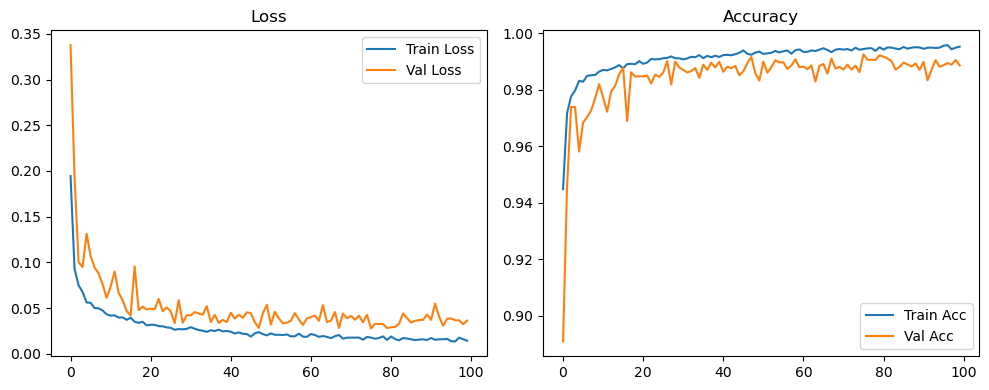

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1063, Acc: 0.9702 | Val Loss: 0.0569, Acc: 0.9824


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9878 | Val Loss: 0.0518, Acc: 0.9841


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.0371, Acc: 0.9899


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.0370, Acc: 0.9895


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9939 | Val Loss: 0.0426, Acc: 0.9882


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0391, Acc: 0.9902


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0348, Acc: 0.9915


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0486, Acc: 0.9865


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0450, Acc: 0.9892


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0416, Acc: 0.9897


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0463, Acc: 0.9901


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0414, Acc: 0.9901


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0450, Acc: 0.9900


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0505, Acc: 0.9899


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9976 | Val Loss: 0.0390, Acc: 0.9912


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0384, Acc: 0.9919


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0441, Acc: 0.9914


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0561, Acc: 0.9897


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0367, Acc: 0.9920


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0506, Acc: 0.9902


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0394, Acc: 0.9933


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0402, Acc: 0.9932


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0503, Acc: 0.9911


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0483, Acc: 0.9902


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0468, Acc: 0.9918


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0440, Acc: 0.9920


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0462, Acc: 0.9918


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0485, Acc: 0.9916


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0515, Acc: 0.9911


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0485, Acc: 0.9914


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0492, Acc: 0.9912


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0415, Acc: 0.9935


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0455, Acc: 0.9921


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0511, Acc: 0.9913


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0564, Acc: 0.9912


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0480, Acc: 0.9922


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0424, Acc: 0.9920


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0520, Acc: 0.9922


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0623, Acc: 0.9905


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0568, Acc: 0.9919


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0567, Acc: 0.9914


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0555, Acc: 0.9917


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0496, Acc: 0.9925


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0521, Acc: 0.9929


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0604, Acc: 0.9908


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0613, Acc: 0.9913


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0572, Acc: 0.9925


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0479, Acc: 0.9931


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0579, Acc: 0.9922


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0605, Acc: 0.9922


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0499, Acc: 0.9935


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0479, Acc: 0.9939


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0495, Acc: 0.9935


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9937


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9938


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0490, Acc: 0.9937


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0474, Acc: 0.9942


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9941


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9942


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9942


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9939


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0486, Acc: 0.9936


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0508, Acc: 0.9930


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.0515, Acc: 0.9935


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0515, Acc: 0.9932


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0529, Acc: 0.9934


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0520, Acc: 0.9935


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0547, Acc: 0.9931


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0568, Acc: 0.9928


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0677, Acc: 0.9915


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0602, Acc: 0.9925


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0612, Acc: 0.9924


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0574, Acc: 0.9935


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0561, Acc: 0.9934


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0613, Acc: 0.9932


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0666, Acc: 0.9919


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0646, Acc: 0.9920


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0625, Acc: 0.9929


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0606, Acc: 0.9938


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0609, Acc: 0.9931


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0593, Acc: 0.9932


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0632, Acc: 0.9929


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9931


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9932


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9935


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0603, Acc: 0.9933


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0592, Acc: 0.9931


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0596, Acc: 0.9933


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0598, Acc: 0.9934


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0606, Acc: 0.9936


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0588, Acc: 0.9932


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9931


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9930


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9932


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0629, Acc: 0.9932


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0615, Acc: 0.9931


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0592, Acc: 0.9931


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0580, Acc: 0.9937


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0636, Acc: 0.9931


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0619, Acc: 0.9932


Final Test Loss: 0.0570 Accuracy: 0.9927


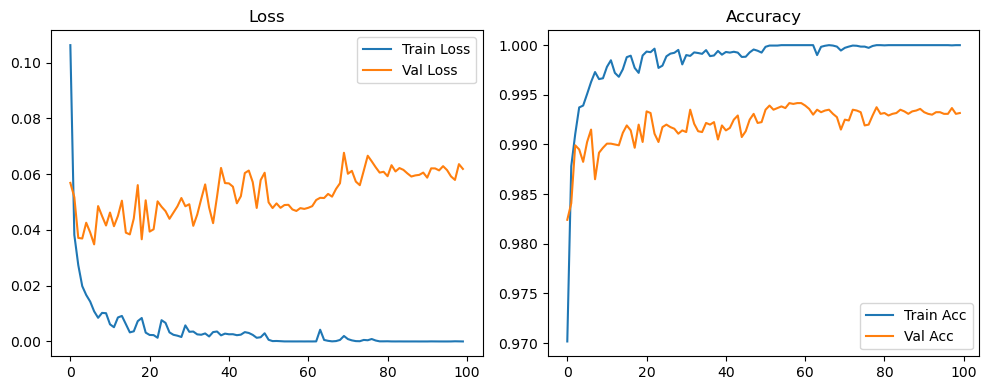

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1283, Acc: 0.9637 | Val Loss: 0.0873, Acc: 0.9732


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9833 | Val Loss: 0.0513, Acc: 0.9842


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9868 | Val Loss: 0.0443, Acc: 0.9861


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9899 | Val Loss: 0.0419, Acc: 0.9873


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 0.0383, Acc: 0.9879


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9926 | Val Loss: 0.0435, Acc: 0.9869


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.0476, Acc: 0.9848


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9935 | Val Loss: 0.0377, Acc: 0.9890


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9947 | Val Loss: 0.0372, Acc: 0.9885


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.0488, Acc: 0.9856


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.0427, Acc: 0.9888


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0416, Acc: 0.9882


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9947 | Val Loss: 0.0343, Acc: 0.9911


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0312, Acc: 0.9920


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.0342, Acc: 0.9912


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.0323, Acc: 0.9903


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0374, Acc: 0.9903


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0385, Acc: 0.9899


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.0342, Acc: 0.9903


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0364, Acc: 0.9899


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0314, Acc: 0.9913


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0364, Acc: 0.9904


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0388, Acc: 0.9908


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0384, Acc: 0.9906


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0501, Acc: 0.9878


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.0332, Acc: 0.9914


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0327, Acc: 0.9918


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0369, Acc: 0.9905


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0383, Acc: 0.9907


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0293, Acc: 0.9926


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0367, Acc: 0.9918


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.0384, Acc: 0.9907


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0306, Acc: 0.9928


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0325, Acc: 0.9920


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0412, Acc: 0.9910


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0404, Acc: 0.9906


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0436, Acc: 0.9900


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0316, Acc: 0.9921


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0360, Acc: 0.9918


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0349, Acc: 0.9919


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0339, Acc: 0.9925


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0310, Acc: 0.9929


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9979 | Val Loss: 0.0312, Acc: 0.9922


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0306, Acc: 0.9923


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0398, Acc: 0.9904


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0461, Acc: 0.9907


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0358, Acc: 0.9912


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0369, Acc: 0.9914


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0436, Acc: 0.9903


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0418, Acc: 0.9908


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0369, Acc: 0.9920


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0390, Acc: 0.9916


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0382, Acc: 0.9923


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0356, Acc: 0.9923


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0403, Acc: 0.9918


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0486, Acc: 0.9912


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0437, Acc: 0.9925


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0419, Acc: 0.9912


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0350, Acc: 0.9930


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0343, Acc: 0.9932


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0346, Acc: 0.9930


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0406, Acc: 0.9919


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0474, Acc: 0.9911


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0418, Acc: 0.9929


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0395, Acc: 0.9924


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0346, Acc: 0.9936


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0384, Acc: 0.9928


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0358, Acc: 0.9935


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0447, Acc: 0.9926


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0356, Acc: 0.9929


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0354, Acc: 0.9925


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0393, Acc: 0.9929


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0347, Acc: 0.9931


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0353, Acc: 0.9926


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0347, Acc: 0.9928


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0391, Acc: 0.9922


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0389, Acc: 0.9926


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0376, Acc: 0.9932


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0375, Acc: 0.9931


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0375, Acc: 0.9933


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0352, Acc: 0.9938


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0354, Acc: 0.9935


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0339, Acc: 0.9936


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0350, Acc: 0.9932


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0350, Acc: 0.9936


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0349, Acc: 0.9936


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0361, Acc: 0.9935


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0384, Acc: 0.9937


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0383, Acc: 0.9931


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0372, Acc: 0.9938


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0362, Acc: 0.9938


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0419, Acc: 0.9935


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0380, Acc: 0.9939


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0394, Acc: 0.9941


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0380, Acc: 0.9934


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0370, Acc: 0.9938


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0374, Acc: 0.9939


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0381, Acc: 0.9937


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0373, Acc: 0.9935


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0361, Acc: 0.9938


Final Test Loss: 0.0365 Accuracy: 0.9928


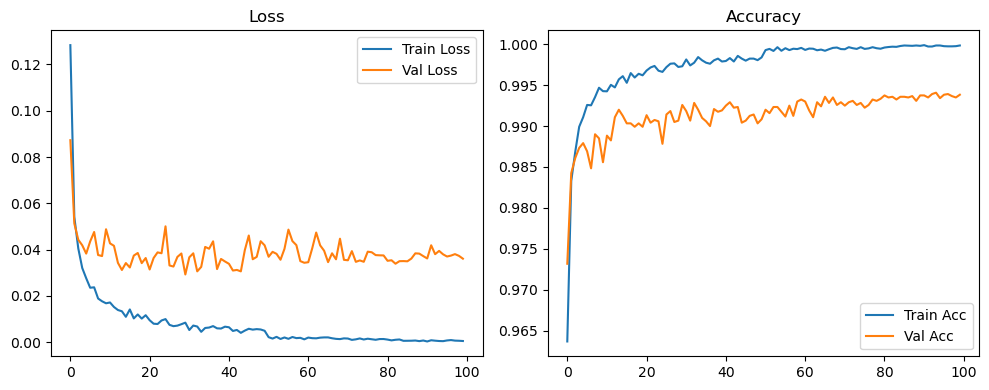

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1943, Acc: 0.9450 | Val Loss: 0.4819, Acc: 0.8366


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0928, Acc: 0.9717 | Val Loss: 0.2126, Acc: 0.9364


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0745, Acc: 0.9780 | Val Loss: 0.1233, Acc: 0.9652


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9791 | Val Loss: 0.0848, Acc: 0.9769


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0574, Acc: 0.9825 | Val Loss: 0.1304, Acc: 0.9595


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9831 | Val Loss: 0.0674, Acc: 0.9813


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9843 | Val Loss: 0.0764, Acc: 0.9755


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9850 | Val Loss: 0.0596, Acc: 0.9825


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9852 | Val Loss: 0.0589, Acc: 0.9842


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9861 | Val Loss: 0.0568, Acc: 0.9836


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9868 | Val Loss: 0.0472, Acc: 0.9865


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9867 | Val Loss: 0.0662, Acc: 0.9802


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9871 | Val Loss: 0.0607, Acc: 0.9805


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9885 | Val Loss: 0.0637, Acc: 0.9812


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9885 | Val Loss: 0.0404, Acc: 0.9882


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9881 | Val Loss: 0.0467, Acc: 0.9863


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9885 | Val Loss: 0.0734, Acc: 0.9781


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9893 | Val Loss: 0.0621, Acc: 0.9797


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9889 | Val Loss: 0.0674, Acc: 0.9798


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9900 | Val Loss: 0.0421, Acc: 0.9862


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9896 | Val Loss: 0.0555, Acc: 0.9839


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.0601, Acc: 0.9822


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9902 | Val Loss: 0.0566, Acc: 0.9833


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9901 | Val Loss: 0.0438, Acc: 0.9870


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9911 | Val Loss: 0.0588, Acc: 0.9832


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.0484, Acc: 0.9857


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9909 | Val Loss: 0.0356, Acc: 0.9892


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9914 | Val Loss: 0.0518, Acc: 0.9841


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9910 | Val Loss: 0.0395, Acc: 0.9882


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.0488, Acc: 0.9852


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9910 | Val Loss: 0.0560, Acc: 0.9822


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9911 | Val Loss: 0.0489, Acc: 0.9852


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9924 | Val Loss: 0.0411, Acc: 0.9877


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.0426, Acc: 0.9878


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9913 | Val Loss: 0.0426, Acc: 0.9871


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9914 | Val Loss: 0.0388, Acc: 0.9878


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9923 | Val Loss: 0.0559, Acc: 0.9839


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.0339, Acc: 0.9902


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9921 | Val Loss: 0.0393, Acc: 0.9882


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0512, Acc: 0.9841


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.0448, Acc: 0.9878


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.0355, Acc: 0.9891


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9924 | Val Loss: 0.0344, Acc: 0.9906


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9929 | Val Loss: 0.0382, Acc: 0.9895


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9925 | Val Loss: 0.0489, Acc: 0.9857


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0388, Acc: 0.9895


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 0.0340, Acc: 0.9902


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.0340, Acc: 0.9898


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0655, Acc: 0.9788


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.0510, Acc: 0.9851


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9946 | Val Loss: 0.0409, Acc: 0.9886


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0420, Acc: 0.9870


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0341, Acc: 0.9894


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0371, Acc: 0.9883


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0386, Acc: 0.9885


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0357, Acc: 0.9890


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0408, Acc: 0.9873


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0409, Acc: 0.9882


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0368, Acc: 0.9892


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0372, Acc: 0.9881


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0308, Acc: 0.9909


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.0383, Acc: 0.9889


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0313, Acc: 0.9912


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0343, Acc: 0.9893


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0369, Acc: 0.9892


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.0339, Acc: 0.9906


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.0417, Acc: 0.9881


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0367, Acc: 0.9896


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0403, Acc: 0.9874


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.0327, Acc: 0.9903


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0304, Acc: 0.9913


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.0326, Acc: 0.9905


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0300, Acc: 0.9910


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.0320, Acc: 0.9909


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0353, Acc: 0.9891


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0260, Acc: 0.9925


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0285, Acc: 0.9922


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0351, Acc: 0.9903


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0370, Acc: 0.9896


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0267, Acc: 0.9919


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0268, Acc: 0.9929


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0306, Acc: 0.9918


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0308, Acc: 0.9917


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.0361, Acc: 0.9898


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0292, Acc: 0.9920


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0298, Acc: 0.9918


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0285, Acc: 0.9917


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.0321, Acc: 0.9913


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9967 | Val Loss: 0.0319, Acc: 0.9911


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0289, Acc: 0.9922


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0290, Acc: 0.9920


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.0308, Acc: 0.9908


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0275, Acc: 0.9924


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0288, Acc: 0.9915


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0298, Acc: 0.9916


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0321, Acc: 0.9912


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0320, Acc: 0.9910


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.0269, Acc: 0.9931


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0274, Acc: 0.9920


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0263, Acc: 0.9928


Final Test Loss: 0.0223 Accuracy: 0.9932


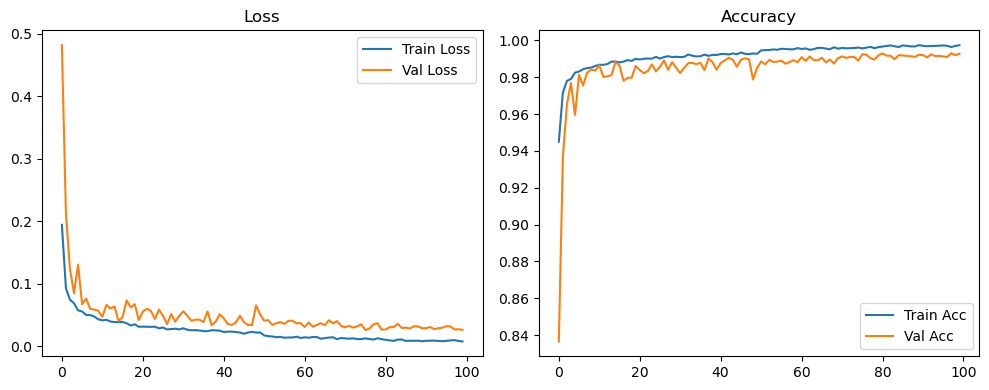

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1061, Acc: 0.9700 | Val Loss: 0.0565, Acc: 0.9827


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9879 | Val Loss: 0.0578, Acc: 0.9817


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.0383, Acc: 0.9891


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0396, Acc: 0.9892


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0415, Acc: 0.9878


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0337, Acc: 0.9908


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0406, Acc: 0.9893


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0454, Acc: 0.9882


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0398, Acc: 0.9900


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0500, Acc: 0.9889


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.0455, Acc: 0.9888


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0411, Acc: 0.9908


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0496, Acc: 0.9888


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0441, Acc: 0.9905


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0456, Acc: 0.9907


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0554, Acc: 0.9890


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0433, Acc: 0.9910


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0538, Acc: 0.9894


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0484, Acc: 0.9910


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0467, Acc: 0.9899


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0417, Acc: 0.9916


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0468, Acc: 0.9912


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0457, Acc: 0.9922


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0496, Acc: 0.9908


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0437, Acc: 0.9925


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0569, Acc: 0.9910


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0612, Acc: 0.9885


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0515, Acc: 0.9907


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0535, Acc: 0.9914


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0485, Acc: 0.9922


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0502, Acc: 0.9925


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0483, Acc: 0.9924


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0467, Acc: 0.9920


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0555, Acc: 0.9918


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0530, Acc: 0.9918


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0545, Acc: 0.9918


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0630, Acc: 0.9898


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0625, Acc: 0.9908


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0611, Acc: 0.9916


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0508, Acc: 0.9923


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0436, Acc: 0.9935


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0486, Acc: 0.9924


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0554, Acc: 0.9911


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0490, Acc: 0.9927


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0496, Acc: 0.9928


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0500, Acc: 0.9928


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0518, Acc: 0.9931


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0582, Acc: 0.9922


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.0666, Acc: 0.9898


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0633, Acc: 0.9918


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0507, Acc: 0.9934


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0499, Acc: 0.9933


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0505, Acc: 0.9938


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9934


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0527, Acc: 0.9935


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0502, Acc: 0.9937


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0503, Acc: 0.9934


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9934


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0509, Acc: 0.9940


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0510, Acc: 0.9937


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0530, Acc: 0.9932


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0593, Acc: 0.9929


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0577, Acc: 0.9928


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0653, Acc: 0.9920


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0685, Acc: 0.9918


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0573, Acc: 0.9928


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0565, Acc: 0.9928


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0582, Acc: 0.9920


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0631, Acc: 0.9917


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0510, Acc: 0.9934


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0529, Acc: 0.9935


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9937


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0640, Acc: 0.9926


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0599, Acc: 0.9929


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0594, Acc: 0.9929


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0639, Acc: 0.9920


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0656, Acc: 0.9923


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0682, Acc: 0.9917


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0639, Acc: 0.9923


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0624, Acc: 0.9931


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0625, Acc: 0.9929


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0635, Acc: 0.9928


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0620, Acc: 0.9931


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0626, Acc: 0.9931


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0608, Acc: 0.9928


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9929


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9928


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0606, Acc: 0.9929


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0609, Acc: 0.9931


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0605, Acc: 0.9928


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9929


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0608, Acc: 0.9928


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9932


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0585, Acc: 0.9933


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0592, Acc: 0.9931


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9927


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9927


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0599, Acc: 0.9931


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9931


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0584, Acc: 0.9932


Final Test Loss: 0.0463 Accuracy: 0.9935


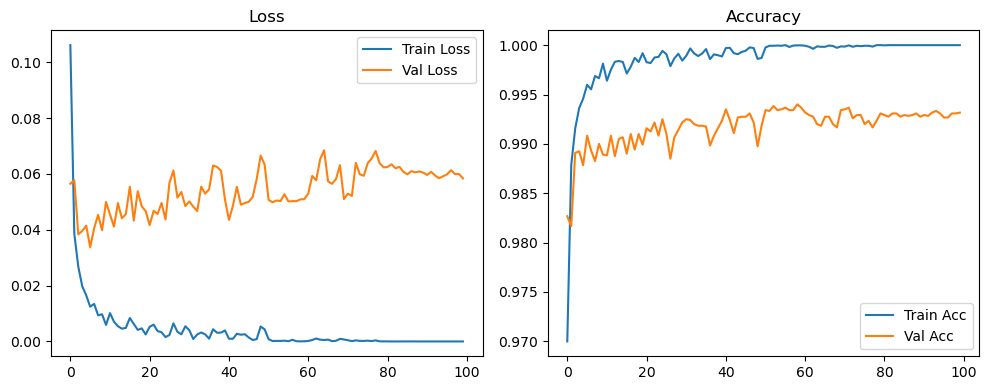

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1283, Acc: 0.9634 | Val Loss: 0.0888, Acc: 0.9728


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9826 | Val Loss: 0.0502, Acc: 0.9842


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9870 | Val Loss: 0.0432, Acc: 0.9863


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9894 | Val Loss: 0.0499, Acc: 0.9843


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.0385, Acc: 0.9882


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.0444, Acc: 0.9863


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9933 | Val Loss: 0.0477, Acc: 0.9851


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9933 | Val Loss: 0.0429, Acc: 0.9888


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0341, Acc: 0.9909


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9941 | Val Loss: 0.0295, Acc: 0.9913


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.0313, Acc: 0.9907


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0332, Acc: 0.9916


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0347, Acc: 0.9903


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0376, Acc: 0.9898


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0366, Acc: 0.9907


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9952 | Val Loss: 0.0325, Acc: 0.9919


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0353, Acc: 0.9902


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0464, Acc: 0.9884


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0341, Acc: 0.9902


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0305, Acc: 0.9910


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0316, Acc: 0.9920


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0393, Acc: 0.9898


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0387, Acc: 0.9902


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0425, Acc: 0.9890


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0388, Acc: 0.9901


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0335, Acc: 0.9916


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0367, Acc: 0.9912


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0381, Acc: 0.9902


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0378, Acc: 0.9919


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0426, Acc: 0.9885


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0364, Acc: 0.9911


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0378, Acc: 0.9921


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0344, Acc: 0.9920


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9977 | Val Loss: 0.0394, Acc: 0.9908


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0548, Acc: 0.9895


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0426, Acc: 0.9904


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0389, Acc: 0.9918


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0384, Acc: 0.9913


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9981 | Val Loss: 0.0420, Acc: 0.9909


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0417, Acc: 0.9910


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0374, Acc: 0.9914


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0302, Acc: 0.9918


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0349, Acc: 0.9913


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0334, Acc: 0.9919


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0377, Acc: 0.9912


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0329, Acc: 0.9925


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0341, Acc: 0.9925


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0401, Acc: 0.9911


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0457, Acc: 0.9913


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0435, Acc: 0.9904


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0357, Acc: 0.9922


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0378, Acc: 0.9921


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0381, Acc: 0.9921


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.0362, Acc: 0.9928


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0344, Acc: 0.9928


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0386, Acc: 0.9918


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0415, Acc: 0.9913


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0364, Acc: 0.9923


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0390, Acc: 0.9925


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0387, Acc: 0.9919


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0389, Acc: 0.9924


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0392, Acc: 0.9921


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0347, Acc: 0.9931


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0370, Acc: 0.9933


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0362, Acc: 0.9928


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0384, Acc: 0.9914


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0399, Acc: 0.9920


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0386, Acc: 0.9929


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0416, Acc: 0.9915


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0367, Acc: 0.9926


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0357, Acc: 0.9928


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0367, Acc: 0.9925


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0377, Acc: 0.9924


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9999 | Val Loss: 0.0353, Acc: 0.9932


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0396, Acc: 0.9927


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0431, Acc: 0.9923


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0364, Acc: 0.9934


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0325, Acc: 0.9933


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0375, Acc: 0.9920


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0350, Acc: 0.9935


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0327, Acc: 0.9942


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0349, Acc: 0.9934


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0321, Acc: 0.9945


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0340, Acc: 0.9934


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0340, Acc: 0.9938


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.0357, Acc: 0.9936


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0345, Acc: 0.9938


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0353, Acc: 0.9937


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0352, Acc: 0.9934


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0330, Acc: 0.9935


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0317, Acc: 0.9939


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0334, Acc: 0.9937


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0310, Acc: 0.9942


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0353, Acc: 0.9935


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0343, Acc: 0.9934


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0371, Acc: 0.9935


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0352, Acc: 0.9933


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0334, Acc: 0.9936


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0334, Acc: 0.9940


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0314, Acc: 0.9942


Final Test Loss: 0.0301 Accuracy: 0.9934


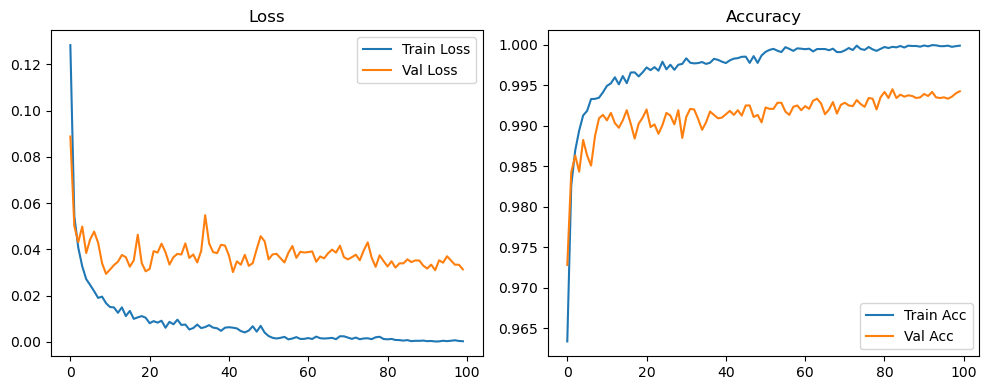

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1944, Acc: 0.9455 | Val Loss: 0.3605, Acc: 0.8802


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0935, Acc: 0.9720 | Val Loss: 0.1752, Acc: 0.9505


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0747, Acc: 0.9772 | Val Loss: 0.1197, Acc: 0.9655


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9798 | Val Loss: 0.0897, Acc: 0.9744


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9825 | Val Loss: 0.1067, Acc: 0.9667


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9834 | Val Loss: 0.0850, Acc: 0.9754


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9850 | Val Loss: 0.0847, Acc: 0.9744


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9850 | Val Loss: 0.0659, Acc: 0.9805


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9858 | Val Loss: 0.0818, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9863 | Val Loss: 0.0599, Acc: 0.9822


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9869 | Val Loss: 0.0596, Acc: 0.9828


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9867 | Val Loss: 0.0605, Acc: 0.9819


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9875 | Val Loss: 0.0473, Acc: 0.9852


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9876 | Val Loss: 0.0505, Acc: 0.9851


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9883 | Val Loss: 0.0426, Acc: 0.9889


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9882 | Val Loss: 0.0418, Acc: 0.9877


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9888 | Val Loss: 0.0826, Acc: 0.9743


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9887 | Val Loss: 0.0488, Acc: 0.9843


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9887 | Val Loss: 0.0521, Acc: 0.9843


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9905 | Val Loss: 0.0544, Acc: 0.9828


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9897 | Val Loss: 0.0529, Acc: 0.9834


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9898 | Val Loss: 0.0624, Acc: 0.9806


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9907 | Val Loss: 0.0593, Acc: 0.9811


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9906 | Val Loss: 0.0602, Acc: 0.9812


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.0428, Acc: 0.9872


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.0467, Acc: 0.9850


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9907 | Val Loss: 0.0382, Acc: 0.9883


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9913 | Val Loss: 0.0450, Acc: 0.9856


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9910 | Val Loss: 0.0399, Acc: 0.9876


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9910 | Val Loss: 0.0480, Acc: 0.9863


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9909 | Val Loss: 0.0505, Acc: 0.9844


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.0527, Acc: 0.9839


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9919 | Val Loss: 0.0423, Acc: 0.9868


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9913 | Val Loss: 0.0422, Acc: 0.9872


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9919 | Val Loss: 0.0610, Acc: 0.9810


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9920 | Val Loss: 0.0461, Acc: 0.9852


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9923 | Val Loss: 0.0432, Acc: 0.9868


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9921 | Val Loss: 0.0399, Acc: 0.9888


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9927 | Val Loss: 0.0373, Acc: 0.9885


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.0351, Acc: 0.9898


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9920 | Val Loss: 0.0384, Acc: 0.9879


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0534, Acc: 0.9841


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.0380, Acc: 0.9890


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.0433, Acc: 0.9869


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 0.0528, Acc: 0.9838


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.0560, Acc: 0.9825


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.0351, Acc: 0.9889


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9934 | Val Loss: 0.0324, Acc: 0.9902


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0538, Acc: 0.9820


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9934 | Val Loss: 0.0503, Acc: 0.9844


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0383, Acc: 0.9873


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.0336, Acc: 0.9898


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.0330, Acc: 0.9901


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.0338, Acc: 0.9894


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0332, Acc: 0.9903


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0374, Acc: 0.9882


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0409, Acc: 0.9872


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0386, Acc: 0.9888


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0331, Acc: 0.9899


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0406, Acc: 0.9876


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9954 | Val Loss: 0.0359, Acc: 0.9895


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0413, Acc: 0.9874


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.0351, Acc: 0.9897


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0320, Acc: 0.9902


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.0321, Acc: 0.9902


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.0398, Acc: 0.9876


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0428, Acc: 0.9866


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0365, Acc: 0.9882


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9956 | Val Loss: 0.0393, Acc: 0.9878


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0352, Acc: 0.9899


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.0345, Acc: 0.9889


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0301, Acc: 0.9914


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0373, Acc: 0.9878


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0314, Acc: 0.9901


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.0386, Acc: 0.9880


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0300, Acc: 0.9912


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0283, Acc: 0.9916


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.0326, Acc: 0.9910


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.0381, Acc: 0.9879


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0272, Acc: 0.9914


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0274, Acc: 0.9918


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0320, Acc: 0.9912


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0293, Acc: 0.9914


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0332, Acc: 0.9897


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.0298, Acc: 0.9915


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0328, Acc: 0.9902


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0292, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0318, Acc: 0.9909


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9967 | Val Loss: 0.0318, Acc: 0.9904


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9972 | Val Loss: 0.0315, Acc: 0.9909


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0293, Acc: 0.9917


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9967 | Val Loss: 0.0324, Acc: 0.9907


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0304, Acc: 0.9907


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0312, Acc: 0.9908


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0321, Acc: 0.9910


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0340, Acc: 0.9896


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0338, Acc: 0.9900


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0316, Acc: 0.9910


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9969 | Val Loss: 0.0329, Acc: 0.9904


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9973 | Val Loss: 0.0295, Acc: 0.9911


Final Test Loss: 0.0257 Accuracy: 0.9919


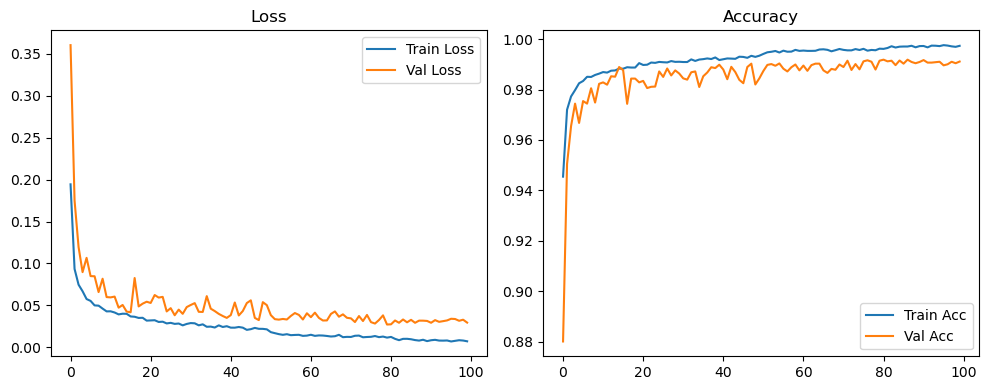

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1065, Acc: 0.9699 | Val Loss: 0.0556, Acc: 0.9828


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9875 | Val Loss: 0.0509, Acc: 0.9849


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9911 | Val Loss: 0.0440, Acc: 0.9882


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0411, Acc: 0.9881


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0375, Acc: 0.9887


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0466, Acc: 0.9891


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.0402, Acc: 0.9884


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9969 | Val Loss: 0.0426, Acc: 0.9894


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.0467, Acc: 0.9880


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9971 | Val Loss: 0.0527, Acc: 0.9863


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0499, Acc: 0.9887


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0449, Acc: 0.9892


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0491, Acc: 0.9898


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0481, Acc: 0.9898


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0453, Acc: 0.9904


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0436, Acc: 0.9910


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0371, Acc: 0.9928


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0475, Acc: 0.9912


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0803, Acc: 0.9836


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0476, Acc: 0.9908


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0445, Acc: 0.9917


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0403, Acc: 0.9922


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0476, Acc: 0.9908


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0412, Acc: 0.9918


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0416, Acc: 0.9922


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0557, Acc: 0.9892


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0501, Acc: 0.9902


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0495, Acc: 0.9918


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0505, Acc: 0.9918


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0508, Acc: 0.9913


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0475, Acc: 0.9922


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0616, Acc: 0.9902


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0506, Acc: 0.9915


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0504, Acc: 0.9918


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0535, Acc: 0.9919


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0465, Acc: 0.9926


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0571, Acc: 0.9912


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0711, Acc: 0.9892


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0566, Acc: 0.9916


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0548, Acc: 0.9921


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0610, Acc: 0.9922


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0616, Acc: 0.9912


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0574, Acc: 0.9908


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0529, Acc: 0.9922


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0658, Acc: 0.9908


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0672, Acc: 0.9903


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0588, Acc: 0.9918


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0608, Acc: 0.9927


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0504, Acc: 0.9921


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0665, Acc: 0.9907


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0561, Acc: 0.9926


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9925


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0559, Acc: 0.9928


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0539, Acc: 0.9926


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0540, Acc: 0.9927


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0546, Acc: 0.9929


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0548, Acc: 0.9928


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0531, Acc: 0.9932


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9933


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0529, Acc: 0.9930


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0533, Acc: 0.9931


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9929


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0534, Acc: 0.9936


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0542, Acc: 0.9932


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0536, Acc: 0.9934


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0539, Acc: 0.9930


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9934


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0520, Acc: 0.9932


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0518, Acc: 0.9933


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9934


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9938


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9939


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9941


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0500, Acc: 0.9939


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0541, Acc: 0.9932


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0564, Acc: 0.9932


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9934


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0561, Acc: 0.9936


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0565, Acc: 0.9933


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0578, Acc: 0.9934


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0572, Acc: 0.9936


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0568, Acc: 0.9938


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0573, Acc: 0.9939


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0567, Acc: 0.9938


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0555, Acc: 0.9939


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0566, Acc: 0.9937


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0571, Acc: 0.9939


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0567, Acc: 0.9939


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0561, Acc: 0.9942


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0559, Acc: 0.9942


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0553, Acc: 0.9943


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0579, Acc: 0.9942


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0570, Acc: 0.9942


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9937


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9938


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0596, Acc: 0.9935


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0598, Acc: 0.9932


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0605, Acc: 0.9933


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0590, Acc: 0.9934


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0607, Acc: 0.9932


Final Test Loss: 0.0498 Accuracy: 0.9940


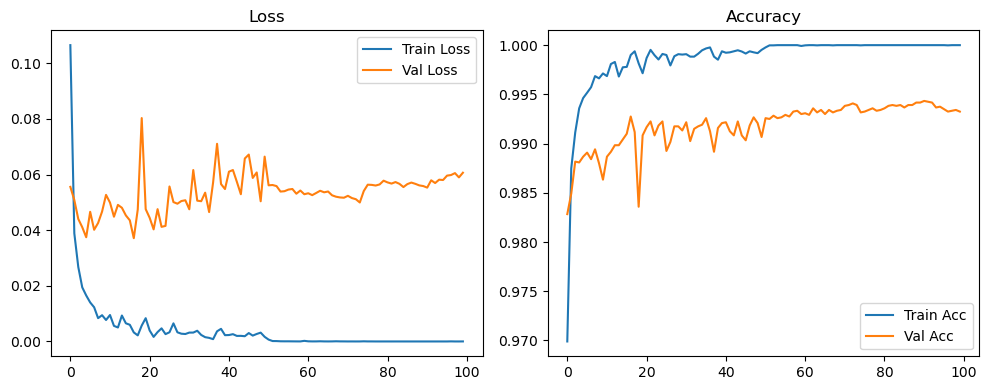

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1281, Acc: 0.9637 | Val Loss: 0.0893, Acc: 0.9717


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9830 | Val Loss: 0.0484, Acc: 0.9848


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9868 | Val Loss: 0.0442, Acc: 0.9858


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9890 | Val Loss: 0.0565, Acc: 0.9832


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.0379, Acc: 0.9890


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.0409, Acc: 0.9870


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.0611, Acc: 0.9826


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0415, Acc: 0.9882


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0396, Acc: 0.9884


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.0329, Acc: 0.9902


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.0374, Acc: 0.9890


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.0372, Acc: 0.9892


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9950 | Val Loss: 0.0331, Acc: 0.9904


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.0335, Acc: 0.9907


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.0320, Acc: 0.9926


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9955 | Val Loss: 0.0335, Acc: 0.9917


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9965 | Val Loss: 0.0353, Acc: 0.9913


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0526, Acc: 0.9872


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0326, Acc: 0.9917


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0342, Acc: 0.9919


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0388, Acc: 0.9898


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0364, Acc: 0.9911


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0398, Acc: 0.9907


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9968 | Val Loss: 0.0359, Acc: 0.9907


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.0449, Acc: 0.9906


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0385, Acc: 0.9911


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9976 | Val Loss: 0.0360, Acc: 0.9917


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.0357, Acc: 0.9905


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0353, Acc: 0.9912


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0387, Acc: 0.9903


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0308, Acc: 0.9928


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0326, Acc: 0.9911


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0361, Acc: 0.9907


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0407, Acc: 0.9902


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0499, Acc: 0.9893


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0401, Acc: 0.9911


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0462, Acc: 0.9887


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0329, Acc: 0.9927


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0350, Acc: 0.9925


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0345, Acc: 0.9921


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0448, Acc: 0.9906


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0362, Acc: 0.9918


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0395, Acc: 0.9912


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9980 | Val Loss: 0.0373, Acc: 0.9912


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0412, Acc: 0.9919


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0360, Acc: 0.9924


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0362, Acc: 0.9915


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0409, Acc: 0.9918


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0470, Acc: 0.9905


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0335, Acc: 0.9929


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0325, Acc: 0.9928


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0345, Acc: 0.9927


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0344, Acc: 0.9929


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0345, Acc: 0.9928


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0343, Acc: 0.9932


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0337, Acc: 0.9936


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0346, Acc: 0.9932


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0324, Acc: 0.9934


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0321, Acc: 0.9934


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0333, Acc: 0.9930


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0344, Acc: 0.9931


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0336, Acc: 0.9933


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0337, Acc: 0.9938


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0343, Acc: 0.9938


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0351, Acc: 0.9936


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0364, Acc: 0.9928


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0343, Acc: 0.9936


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0360, Acc: 0.9936


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0380, Acc: 0.9933


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0361, Acc: 0.9931


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0343, Acc: 0.9938


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0355, Acc: 0.9928


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0345, Acc: 0.9935


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0341, Acc: 0.9933


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0369, Acc: 0.9930


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0374, Acc: 0.9934


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0361, Acc: 0.9935


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0371, Acc: 0.9935


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0349, Acc: 0.9935


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0346, Acc: 0.9932


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0326, Acc: 0.9932


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0361, Acc: 0.9934


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0353, Acc: 0.9936


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0355, Acc: 0.9934


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0357, Acc: 0.9938


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0343, Acc: 0.9937


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0355, Acc: 0.9938


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0366, Acc: 0.9933


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0376, Acc: 0.9932


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0366, Acc: 0.9935


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0360, Acc: 0.9934


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0388, Acc: 0.9930


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0356, Acc: 0.9940


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0377, Acc: 0.9930


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0362, Acc: 0.9933


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0381, Acc: 0.9932


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0376, Acc: 0.9938


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0369, Acc: 0.9934


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0373, Acc: 0.9935


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0351, Acc: 0.9938


Final Test Loss: 0.0296 Accuracy: 0.9938


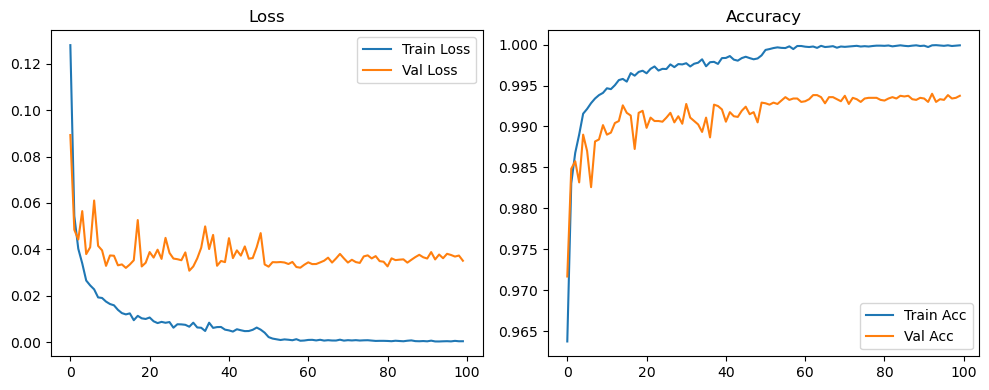

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1943, Acc: 0.9451 | Val Loss: 0.5096, Acc: 0.8298


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9715 | Val Loss: 0.1547, Acc: 0.9563


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0745, Acc: 0.9779 | Val Loss: 0.1268, Acc: 0.9617


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0665, Acc: 0.9805 | Val Loss: 0.0749, Acc: 0.9802


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9825 | Val Loss: 0.1084, Acc: 0.9667


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9829 | Val Loss: 0.0877, Acc: 0.9738


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9848 | Val Loss: 0.0672, Acc: 0.9800


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9849 | Val Loss: 0.0781, Acc: 0.9763


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9849 | Val Loss: 0.0590, Acc: 0.9837


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9865 | Val Loss: 0.0523, Acc: 0.9845


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9866 | Val Loss: 0.0532, Acc: 0.9849


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9871 | Val Loss: 0.0658, Acc: 0.9796


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9872 | Val Loss: 0.0573, Acc: 0.9836


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9875 | Val Loss: 0.0586, Acc: 0.9818


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9888 | Val Loss: 0.0478, Acc: 0.9853


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9878 | Val Loss: 0.0457, Acc: 0.9868


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9888 | Val Loss: 0.0939, Acc: 0.9718


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9892 | Val Loss: 0.0510, Acc: 0.9860


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.0560, Acc: 0.9837


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9904 | Val Loss: 0.0446, Acc: 0.9868


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.0455, Acc: 0.9855


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9903 | Val Loss: 0.0474, Acc: 0.9860


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9903 | Val Loss: 0.0420, Acc: 0.9875


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9901 | Val Loss: 0.0493, Acc: 0.9852


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9909 | Val Loss: 0.0531, Acc: 0.9853


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9910 | Val Loss: 0.0650, Acc: 0.9808


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9906 | Val Loss: 0.0339, Acc: 0.9898


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9909 | Val Loss: 0.0528, Acc: 0.9832


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0366, Acc: 0.9895


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9909 | Val Loss: 0.0469, Acc: 0.9872


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9907 | Val Loss: 0.0389, Acc: 0.9893


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9913 | Val Loss: 0.0486, Acc: 0.9868


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9921 | Val Loss: 0.0360, Acc: 0.9889


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9913 | Val Loss: 0.0475, Acc: 0.9855


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.0547, Acc: 0.9836


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.0379, Acc: 0.9880


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.0612, Acc: 0.9818


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9917 | Val Loss: 0.0435, Acc: 0.9858


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9920 | Val Loss: 0.0409, Acc: 0.9875


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.0374, Acc: 0.9879


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.0433, Acc: 0.9868


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9927 | Val Loss: 0.0464, Acc: 0.9858


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9923 | Val Loss: 0.0343, Acc: 0.9906


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9920 | Val Loss: 0.0567, Acc: 0.9834


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9924 | Val Loss: 0.0447, Acc: 0.9862


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9935 | Val Loss: 0.0554, Acc: 0.9835


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9927 | Val Loss: 0.0407, Acc: 0.9877


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0310, Acc: 0.9902


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0404, Acc: 0.9875


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.0534, Acc: 0.9842


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9939 | Val Loss: 0.0386, Acc: 0.9888


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0359, Acc: 0.9896


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0354, Acc: 0.9902


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0339, Acc: 0.9898


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9956 | Val Loss: 0.0351, Acc: 0.9902


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0359, Acc: 0.9902


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0378, Acc: 0.9893


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0401, Acc: 0.9878


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0338, Acc: 0.9902


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0334, Acc: 0.9901


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0294, Acc: 0.9911


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.0340, Acc: 0.9896


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0306, Acc: 0.9907


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0301, Acc: 0.9910


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0317, Acc: 0.9905


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0297, Acc: 0.9916


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0323, Acc: 0.9908


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0329, Acc: 0.9911


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0346, Acc: 0.9902


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0326, Acc: 0.9908


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.0306, Acc: 0.9912


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9962 | Val Loss: 0.0301, Acc: 0.9917


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.0299, Acc: 0.9913


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0282, Acc: 0.9915


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0314, Acc: 0.9906


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0274, Acc: 0.9917


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0277, Acc: 0.9916


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0300, Acc: 0.9910


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0332, Acc: 0.9906


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0305, Acc: 0.9906


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0269, Acc: 0.9924


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0323, Acc: 0.9907


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0300, Acc: 0.9915


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0340, Acc: 0.9907


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0308, Acc: 0.9913


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0312, Acc: 0.9908


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0289, Acc: 0.9916


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0345, Acc: 0.9905


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0313, Acc: 0.9910


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0306, Acc: 0.9915


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.0286, Acc: 0.9922


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0317, Acc: 0.9909


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9966 | Val Loss: 0.0297, Acc: 0.9915


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.0319, Acc: 0.9910


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0329, Acc: 0.9903


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0335, Acc: 0.9907


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0314, Acc: 0.9911


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0309, Acc: 0.9912


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0305, Acc: 0.9912


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.0279, Acc: 0.9918


Final Test Loss: 0.0221 Accuracy: 0.9931


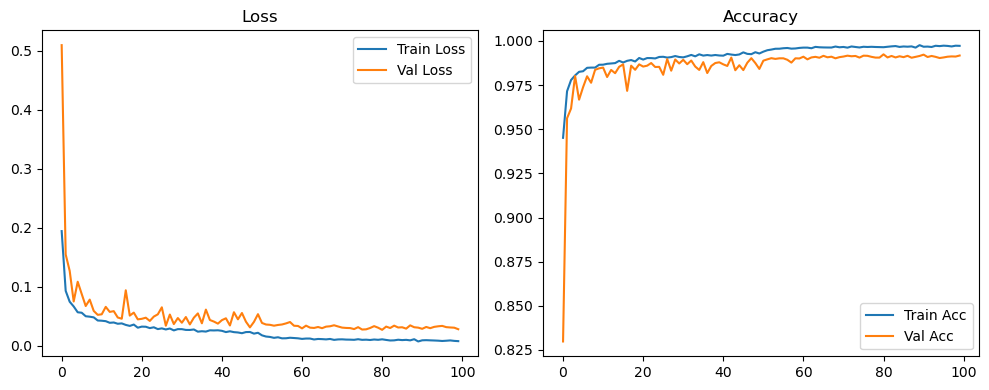

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1124, Acc: 0.9728 | Val Loss: 0.0463, Acc: 0.9852


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9889 | Val Loss: 0.0451, Acc: 0.9855


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9926 | Val Loss: 0.0349, Acc: 0.9902


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0394, Acc: 0.9891


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.0350, Acc: 0.9890


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.0368, Acc: 0.9898


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0436, Acc: 0.9880


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0486, Acc: 0.9875


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9967 | Val Loss: 0.0383, Acc: 0.9898


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0329, Acc: 0.9919


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0475, Acc: 0.9876


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0460, Acc: 0.9888


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0339, Acc: 0.9916


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0408, Acc: 0.9901


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0382, Acc: 0.9906


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0432, Acc: 0.9906


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0379, Acc: 0.9914


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0502, Acc: 0.9894


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0377, Acc: 0.9917


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0351, Acc: 0.9928


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0435, Acc: 0.9916


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0469, Acc: 0.9906


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0401, Acc: 0.9917


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0403, Acc: 0.9925


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0423, Acc: 0.9919


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0405, Acc: 0.9921


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0420, Acc: 0.9915


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0447, Acc: 0.9911


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0435, Acc: 0.9919


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0470, Acc: 0.9920


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0485, Acc: 0.9921


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0528, Acc: 0.9909


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.0430, Acc: 0.9925


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0540, Acc: 0.9902


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0421, Acc: 0.9922


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0461, Acc: 0.9929


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0449, Acc: 0.9922


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0518, Acc: 0.9918


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0517, Acc: 0.9919


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0456, Acc: 0.9916


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0448, Acc: 0.9921


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0393, Acc: 0.9929


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0395, Acc: 0.9937


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0501, Acc: 0.9919


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0508, Acc: 0.9902


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0476, Acc: 0.9920


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0438, Acc: 0.9927


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0437, Acc: 0.9925


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9942


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0474, Acc: 0.9924


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0584, Acc: 0.9908


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0405, Acc: 0.9934


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0451, Acc: 0.9918


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0389, Acc: 0.9938


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0433, Acc: 0.9925


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0510, Acc: 0.9915


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0443, Acc: 0.9924


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0463, Acc: 0.9924


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0492, Acc: 0.9924


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0415, Acc: 0.9934


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0491, Acc: 0.9932


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0650, Acc: 0.9899


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0463, Acc: 0.9927


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0450, Acc: 0.9928


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0495, Acc: 0.9932


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0524, Acc: 0.9928


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0450, Acc: 0.9933


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0469, Acc: 0.9932


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0492, Acc: 0.9918


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0481, Acc: 0.9930


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0546, Acc: 0.9916


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0481, Acc: 0.9930


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0548, Acc: 0.9925


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0484, Acc: 0.9938


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0632, Acc: 0.9916


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0495, Acc: 0.9929


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0579, Acc: 0.9915


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0576, Acc: 0.9920


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0575, Acc: 0.9922


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0683, Acc: 0.9922


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0576, Acc: 0.9921


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0586, Acc: 0.9924


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0566, Acc: 0.9928


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0531, Acc: 0.9922


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0545, Acc: 0.9912


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0609, Acc: 0.9923


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0557, Acc: 0.9925


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0483, Acc: 0.9936


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0543, Acc: 0.9932


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0493, Acc: 0.9937


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0485, Acc: 0.9932


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0525, Acc: 0.9932


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0549, Acc: 0.9921


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0537, Acc: 0.9932


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0525, Acc: 0.9937


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0544, Acc: 0.9928


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0562, Acc: 0.9928


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0565, Acc: 0.9928


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0741, Acc: 0.9907


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.0601, Acc: 0.9924


Final Test Loss: 0.0550 Accuracy: 0.9917


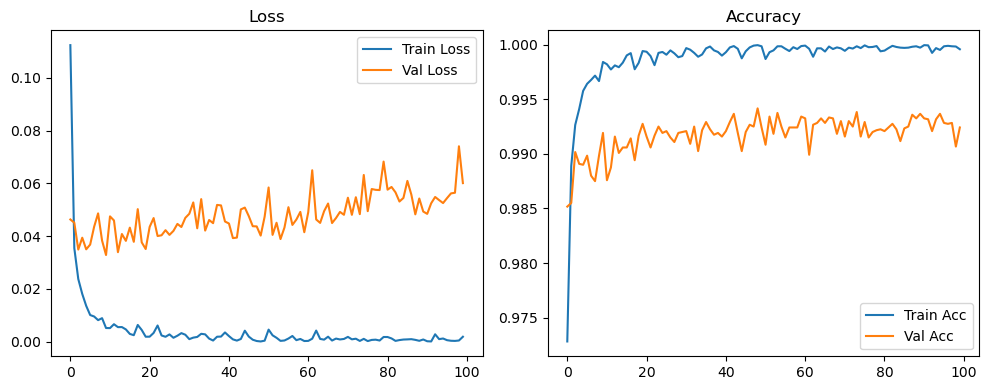

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1327, Acc: 0.9665 | Val Loss: 0.0720, Acc: 0.9779


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9844 | Val Loss: 0.0523, Acc: 0.9838


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9881 | Val Loss: 0.0439, Acc: 0.9867


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.0496, Acc: 0.9844


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 0.0348, Acc: 0.9892


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.0403, Acc: 0.9872


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.0376, Acc: 0.9887


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9943 | Val Loss: 0.0317, Acc: 0.9904


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.0302, Acc: 0.9915


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.0307, Acc: 0.9913


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0404, Acc: 0.9891


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.0352, Acc: 0.9896


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0279, Acc: 0.9926


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0363, Acc: 0.9903


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9960 | Val Loss: 0.0319, Acc: 0.9912


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0364, Acc: 0.9902


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0347, Acc: 0.9916


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0365, Acc: 0.9915


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0303, Acc: 0.9926


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0358, Acc: 0.9914


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0359, Acc: 0.9912


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0370, Acc: 0.9912


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0393, Acc: 0.9898


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0428, Acc: 0.9906


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9974 | Val Loss: 0.0414, Acc: 0.9907


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0312, Acc: 0.9930


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0332, Acc: 0.9915


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0359, Acc: 0.9913


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0356, Acc: 0.9920


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.0380, Acc: 0.9913


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0440, Acc: 0.9907


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0367, Acc: 0.9922


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0344, Acc: 0.9921


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0363, Acc: 0.9912


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0401, Acc: 0.9915


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0431, Acc: 0.9912


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0364, Acc: 0.9925


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0302, Acc: 0.9929


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0367, Acc: 0.9918


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0387, Acc: 0.9910


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0411, Acc: 0.9908


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0454, Acc: 0.9898


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0341, Acc: 0.9928


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0343, Acc: 0.9932


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0398, Acc: 0.9918


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0321, Acc: 0.9933


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0437, Acc: 0.9918


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0357, Acc: 0.9922


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0411, Acc: 0.9922


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0353, Acc: 0.9923


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0330, Acc: 0.9937


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0387, Acc: 0.9922


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0374, Acc: 0.9933


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0357, Acc: 0.9926


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0350, Acc: 0.9929


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0351, Acc: 0.9937


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0397, Acc: 0.9919


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0458, Acc: 0.9902


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9985 | Val Loss: 0.0435, Acc: 0.9919


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9986 | Val Loss: 0.0372, Acc: 0.9927


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0349, Acc: 0.9937


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0362, Acc: 0.9919


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0345, Acc: 0.9936


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0363, Acc: 0.9920


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0383, Acc: 0.9926


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0356, Acc: 0.9942


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0372, Acc: 0.9932


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0346, Acc: 0.9935


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0397, Acc: 0.9922


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0359, Acc: 0.9930


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0360, Acc: 0.9933


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0394, Acc: 0.9922


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0446, Acc: 0.9913


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0351, Acc: 0.9928


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0335, Acc: 0.9933


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0390, Acc: 0.9920


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0400, Acc: 0.9921


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0411, Acc: 0.9926


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0334, Acc: 0.9938


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0364, Acc: 0.9929


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0363, Acc: 0.9933


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0425, Acc: 0.9924


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0365, Acc: 0.9938


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0426, Acc: 0.9923


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0402, Acc: 0.9937


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.0444, Acc: 0.9919


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0439, Acc: 0.9920


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0445, Acc: 0.9927


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0486, Acc: 0.9923


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0391, Acc: 0.9936


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0430, Acc: 0.9927


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0436, Acc: 0.9920


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0452, Acc: 0.9923


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0417, Acc: 0.9930


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0368, Acc: 0.9934


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0434, Acc: 0.9925


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0414, Acc: 0.9932


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0342, Acc: 0.9941


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.0337, Acc: 0.9938


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0345, Acc: 0.9940


Final Test Loss: 0.0295 Accuracy: 0.9938


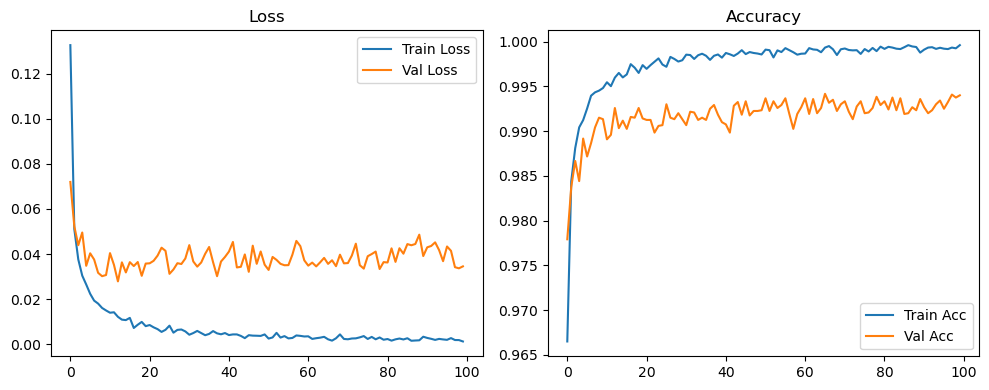

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2013, Acc: 0.9479 | Val Loss: 0.4088, Acc: 0.8603


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0900, Acc: 0.9737 | Val Loss: 0.1784, Acc: 0.9513


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0721, Acc: 0.9788 | Val Loss: 0.1159, Acc: 0.9705


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0634, Acc: 0.9812 | Val Loss: 0.0739, Acc: 0.9808


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9840 | Val Loss: 0.0982, Acc: 0.9700


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9839 | Val Loss: 0.0794, Acc: 0.9773


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9853 | Val Loss: 0.0792, Acc: 0.9763


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9864 | Val Loss: 0.0687, Acc: 0.9812


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9867 | Val Loss: 0.0740, Acc: 0.9786


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9872 | Val Loss: 0.0415, Acc: 0.9895


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9872 | Val Loss: 0.0501, Acc: 0.9872


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9882 | Val Loss: 0.0609, Acc: 0.9824


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9888 | Val Loss: 0.0490, Acc: 0.9862


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 0.0448, Acc: 0.9866


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9900 | Val Loss: 0.0441, Acc: 0.9868


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9890 | Val Loss: 0.0393, Acc: 0.9882


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9905 | Val Loss: 0.0553, Acc: 0.9833


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0521, Acc: 0.9848


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.0437, Acc: 0.9866


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.0377, Acc: 0.9892


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.0455, Acc: 0.9881


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0409, Acc: 0.9892


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9918 | Val Loss: 0.0465, Acc: 0.9871


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0417, Acc: 0.9886


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9915 | Val Loss: 0.0504, Acc: 0.9860


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9915 | Val Loss: 0.0441, Acc: 0.9872


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.0333, Acc: 0.9906


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9917 | Val Loss: 0.0449, Acc: 0.9882


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9928 | Val Loss: 0.0395, Acc: 0.9887


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.0441, Acc: 0.9873


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9916 | Val Loss: 0.0473, Acc: 0.9862


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9926 | Val Loss: 0.0480, Acc: 0.9859


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.0370, Acc: 0.9892


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.0350, Acc: 0.9903


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9933 | Val Loss: 0.0470, Acc: 0.9866


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9926 | Val Loss: 0.0509, Acc: 0.9850


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9927 | Val Loss: 0.0481, Acc: 0.9854


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9925 | Val Loss: 0.0407, Acc: 0.9885


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0442, Acc: 0.9879


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9933 | Val Loss: 0.0318, Acc: 0.9907


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0378, Acc: 0.9893


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.0362, Acc: 0.9898


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.0347, Acc: 0.9903


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9941 | Val Loss: 0.0355, Acc: 0.9898


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0443, Acc: 0.9872


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.0386, Acc: 0.9896


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9931 | Val Loss: 0.0472, Acc: 0.9862


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0396, Acc: 0.9891


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9942 | Val Loss: 0.0385, Acc: 0.9899


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.0535, Acc: 0.9854


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0606, Acc: 0.9833


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0439, Acc: 0.9882


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0311, Acc: 0.9911


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.0322, Acc: 0.9906


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9938 | Val Loss: 0.0387, Acc: 0.9890


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0502, Acc: 0.9860


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.0457, Acc: 0.9876


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.0353, Acc: 0.9908


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.0441, Acc: 0.9887


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0404, Acc: 0.9890


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.0504, Acc: 0.9863


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0534, Acc: 0.9858


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.0411, Acc: 0.9883


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0455, Acc: 0.9882


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0456, Acc: 0.9874


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0437, Acc: 0.9887


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.0471, Acc: 0.9874


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.0377, Acc: 0.9893


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9945 | Val Loss: 0.0449, Acc: 0.9886


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0510, Acc: 0.9859


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0568, Acc: 0.9848


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.0428, Acc: 0.9888


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.0424, Acc: 0.9888


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.0337, Acc: 0.9906


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0408, Acc: 0.9888


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0427, Acc: 0.9881


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.0344, Acc: 0.9908


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0343, Acc: 0.9908


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.0389, Acc: 0.9888


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0454, Acc: 0.9882


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0381, Acc: 0.9907


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9946 | Val Loss: 0.0343, Acc: 0.9911


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9952 | Val Loss: 0.0333, Acc: 0.9910


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9947 | Val Loss: 0.0386, Acc: 0.9892


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.0342, Acc: 0.9903


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.0387, Acc: 0.9899


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.0370, Acc: 0.9905


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0367, Acc: 0.9898


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9954 | Val Loss: 0.0378, Acc: 0.9899


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.0388, Acc: 0.9894


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0466, Acc: 0.9874


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0408, Acc: 0.9891


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9953 | Val Loss: 0.0344, Acc: 0.9908


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0366, Acc: 0.9900


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0370, Acc: 0.9901


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.0358, Acc: 0.9904


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0448, Acc: 0.9884


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0332, Acc: 0.9908


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0325, Acc: 0.9915


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0325, Acc: 0.9920


Final Test Loss: 0.0263 Accuracy: 0.9919


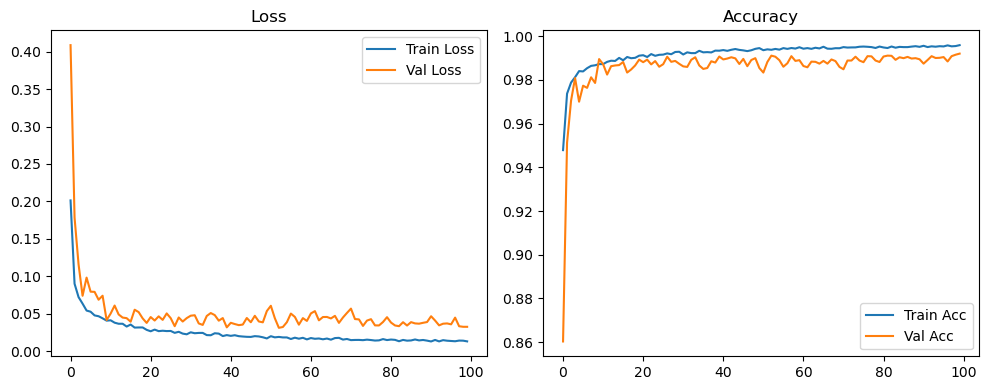

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1124, Acc: 0.9727 | Val Loss: 0.0462, Acc: 0.9846


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9889 | Val Loss: 0.0439, Acc: 0.9861


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9924 | Val Loss: 0.0355, Acc: 0.9894


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.0404, Acc: 0.9876


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0328, Acc: 0.9897


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0415, Acc: 0.9882


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0357, Acc: 0.9899


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0333, Acc: 0.9914


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0406, Acc: 0.9898


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0376, Acc: 0.9907


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0447, Acc: 0.9901


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0350, Acc: 0.9912


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0407, Acc: 0.9902


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0376, Acc: 0.9913


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0411, Acc: 0.9897


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0330, Acc: 0.9926


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0365, Acc: 0.9912


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0457, Acc: 0.9911


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0386, Acc: 0.9910


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0356, Acc: 0.9921


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0374, Acc: 0.9908


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0676, Acc: 0.9884


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0445, Acc: 0.9915


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0327, Acc: 0.9934


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0366, Acc: 0.9930


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0337, Acc: 0.9930


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0410, Acc: 0.9915


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0443, Acc: 0.9908


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0415, Acc: 0.9913


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0496, Acc: 0.9904


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0399, Acc: 0.9926


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0452, Acc: 0.9903


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0411, Acc: 0.9922


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0365, Acc: 0.9933


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0399, Acc: 0.9925


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0518, Acc: 0.9916


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0490, Acc: 0.9905


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0553, Acc: 0.9900


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0419, Acc: 0.9918


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0392, Acc: 0.9933


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0345, Acc: 0.9939


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9934


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9934


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9937


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0318, Acc: 0.9937


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9938


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9938


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0591, Acc: 0.9892


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0468, Acc: 0.9918


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0400, Acc: 0.9923


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.0370, Acc: 0.9927


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0366, Acc: 0.9922


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9929


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0359, Acc: 0.9929


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9932


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9933


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0360, Acc: 0.9934


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9938


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0366, Acc: 0.9937


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0379, Acc: 0.9930


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9923


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0402, Acc: 0.9924


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0394, Acc: 0.9923


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9926


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9928


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9927


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9925


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9924


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0453, Acc: 0.9918


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0425, Acc: 0.9925


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9931


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9934


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9932


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9934


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9931


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9927


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9924


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9924


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9930


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0538, Acc: 0.9903


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0458, Acc: 0.9925


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9922


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9922


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9922


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9923


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9926


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9926


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9922


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9927


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9924


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9927


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0481, Acc: 0.9922


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9929


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9928


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9930


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0466, Acc: 0.9926


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9930


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9926


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9927


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9930


Final Test Loss: 0.0341 Accuracy: 0.9942


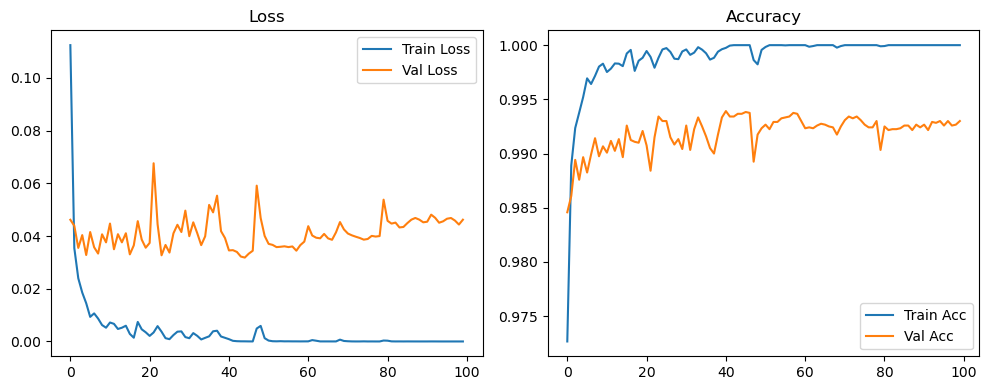

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1328, Acc: 0.9666 | Val Loss: 0.0701, Acc: 0.9792


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9845 | Val Loss: 0.0550, Acc: 0.9827


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9881 | Val Loss: 0.0479, Acc: 0.9857


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9910 | Val Loss: 0.0496, Acc: 0.9843


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.0339, Acc: 0.9898


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0377, Acc: 0.9878


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9938 | Val Loss: 0.0400, Acc: 0.9877


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0307, Acc: 0.9907


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.0304, Acc: 0.9908


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9946 | Val Loss: 0.0339, Acc: 0.9912


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9952 | Val Loss: 0.0425, Acc: 0.9882


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0339, Acc: 0.9902


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.0319, Acc: 0.9909


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9957 | Val Loss: 0.0362, Acc: 0.9903


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0353, Acc: 0.9915


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.0292, Acc: 0.9921


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0506, Acc: 0.9869


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0422, Acc: 0.9910


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0353, Acc: 0.9910


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9971 | Val Loss: 0.0376, Acc: 0.9907


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0428, Acc: 0.9885


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0432, Acc: 0.9907


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0364, Acc: 0.9909


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0340, Acc: 0.9923


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0482, Acc: 0.9886


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0360, Acc: 0.9917


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0322, Acc: 0.9915


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0325, Acc: 0.9918


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0395, Acc: 0.9908


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0396, Acc: 0.9902


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0412, Acc: 0.9907


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0368, Acc: 0.9918


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.0344, Acc: 0.9917


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0309, Acc: 0.9928


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0392, Acc: 0.9917


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0347, Acc: 0.9920


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0347, Acc: 0.9919


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0313, Acc: 0.9927


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0382, Acc: 0.9918


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0333, Acc: 0.9921


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0375, Acc: 0.9921


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0421, Acc: 0.9904


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0385, Acc: 0.9926


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0380, Acc: 0.9919


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0431, Acc: 0.9913


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0421, Acc: 0.9912


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0392, Acc: 0.9917


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0410, Acc: 0.9911


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0495, Acc: 0.9918


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0454, Acc: 0.9910


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0378, Acc: 0.9925


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0390, Acc: 0.9923


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0400, Acc: 0.9927


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0351, Acc: 0.9931


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0392, Acc: 0.9926


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0372, Acc: 0.9926


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0379, Acc: 0.9932


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0357, Acc: 0.9930


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0399, Acc: 0.9928


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0383, Acc: 0.9926


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0395, Acc: 0.9922


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.0414, Acc: 0.9924


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0373, Acc: 0.9926


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0395, Acc: 0.9937


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0413, Acc: 0.9932


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0404, Acc: 0.9934


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0408, Acc: 0.9922


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0395, Acc: 0.9928


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0414, Acc: 0.9926


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0370, Acc: 0.9934


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0390, Acc: 0.9930


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0370, Acc: 0.9931


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0373, Acc: 0.9940


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0352, Acc: 0.9939


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0384, Acc: 0.9936


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0405, Acc: 0.9931


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0407, Acc: 0.9929


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0396, Acc: 0.9932


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0396, Acc: 0.9927


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0432, Acc: 0.9922


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0409, Acc: 0.9922


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0398, Acc: 0.9932


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0398, Acc: 0.9931


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0396, Acc: 0.9927


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0406, Acc: 0.9925


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0384, Acc: 0.9935


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0375, Acc: 0.9938


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0404, Acc: 0.9931


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0422, Acc: 0.9931


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0398, Acc: 0.9933


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0381, Acc: 0.9933


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0409, Acc: 0.9936


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0422, Acc: 0.9932


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0446, Acc: 0.9929


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0454, Acc: 0.9931


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0449, Acc: 0.9930


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9933


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0435, Acc: 0.9935


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0412, Acc: 0.9933


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0410, Acc: 0.9938


Final Test Loss: 0.0327 Accuracy: 0.9934


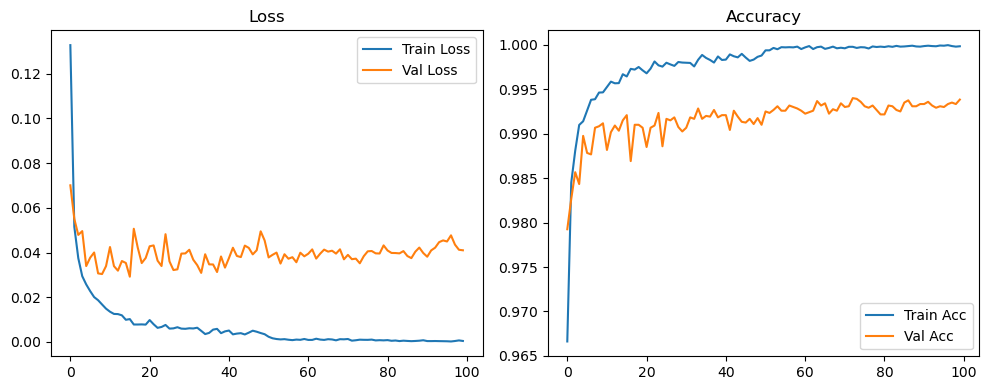

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2012, Acc: 0.9478 | Val Loss: 0.3589, Acc: 0.8818


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0904, Acc: 0.9741 | Val Loss: 0.1511, Acc: 0.9627


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9785 | Val Loss: 0.1137, Acc: 0.9701


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0636, Acc: 0.9811 | Val Loss: 0.0702, Acc: 0.9823


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0544, Acc: 0.9835 | Val Loss: 0.0750, Acc: 0.9783


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9840 | Val Loss: 0.0749, Acc: 0.9785


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9855 | Val Loss: 0.0625, Acc: 0.9815


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9864 | Val Loss: 0.0597, Acc: 0.9840


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9866 | Val Loss: 0.0659, Acc: 0.9821


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9870 | Val Loss: 0.0520, Acc: 0.9859


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9878 | Val Loss: 0.0570, Acc: 0.9849


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9877 | Val Loss: 0.0705, Acc: 0.9788


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9881 | Val Loss: 0.0548, Acc: 0.9841


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9884 | Val Loss: 0.0475, Acc: 0.9863


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9902 | Val Loss: 0.0401, Acc: 0.9889


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9887 | Val Loss: 0.0386, Acc: 0.9890


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9904 | Val Loss: 0.0688, Acc: 0.9798


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9896 | Val Loss: 0.0497, Acc: 0.9858


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9898 | Val Loss: 0.0439, Acc: 0.9872


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0392, Acc: 0.9881


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.0453, Acc: 0.9872


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.0391, Acc: 0.9882


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9916 | Val Loss: 0.0485, Acc: 0.9867


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9913 | Val Loss: 0.0452, Acc: 0.9872


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9913 | Val Loss: 0.0522, Acc: 0.9851


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9917 | Val Loss: 0.0357, Acc: 0.9888


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9923 | Val Loss: 0.0369, Acc: 0.9889


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0406, Acc: 0.9882


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9926 | Val Loss: 0.0346, Acc: 0.9898


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9930 | Val Loss: 0.0369, Acc: 0.9895


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9916 | Val Loss: 0.0406, Acc: 0.9881


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9926 | Val Loss: 0.0512, Acc: 0.9851


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.0367, Acc: 0.9890


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9927 | Val Loss: 0.0366, Acc: 0.9893


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0503, Acc: 0.9864


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.0410, Acc: 0.9886


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.0417, Acc: 0.9877


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9930 | Val Loss: 0.0351, Acc: 0.9900


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0417, Acc: 0.9882


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0318, Acc: 0.9902


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0499, Acc: 0.9862


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.0388, Acc: 0.9884


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0417, Acc: 0.9880


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.0386, Acc: 0.9890


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.0452, Acc: 0.9862


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0356, Acc: 0.9898


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.0448, Acc: 0.9876


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.0357, Acc: 0.9902


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0430, Acc: 0.9878


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.0540, Acc: 0.9849


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.0447, Acc: 0.9875


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9949 | Val Loss: 0.0363, Acc: 0.9903


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9952 | Val Loss: 0.0392, Acc: 0.9891


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.0378, Acc: 0.9893


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.0365, Acc: 0.9900


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0423, Acc: 0.9879


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0440, Acc: 0.9877


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.0365, Acc: 0.9902


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0418, Acc: 0.9888


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0368, Acc: 0.9902


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9955 | Val Loss: 0.0433, Acc: 0.9889


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0449, Acc: 0.9878


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0408, Acc: 0.9892


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0412, Acc: 0.9890


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0424, Acc: 0.9895


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0440, Acc: 0.9876


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0469, Acc: 0.9872


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9954 | Val Loss: 0.0403, Acc: 0.9891


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0458, Acc: 0.9876


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0458, Acc: 0.9877


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0418, Acc: 0.9889


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0389, Acc: 0.9889


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0404, Acc: 0.9888


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0361, Acc: 0.9900


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0392, Acc: 0.9890


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0387, Acc: 0.9892


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0395, Acc: 0.9892


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0363, Acc: 0.9900


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0385, Acc: 0.9900


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0391, Acc: 0.9892


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0346, Acc: 0.9910


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0391, Acc: 0.9896


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.0376, Acc: 0.9891


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0410, Acc: 0.9888


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0346, Acc: 0.9903


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0393, Acc: 0.9891


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0340, Acc: 0.9904


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0408, Acc: 0.9887


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9966 | Val Loss: 0.0393, Acc: 0.9889


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0368, Acc: 0.9895


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0347, Acc: 0.9907


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0360, Acc: 0.9902


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9970 | Val Loss: 0.0371, Acc: 0.9903


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0357, Acc: 0.9908


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0398, Acc: 0.9891


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0398, Acc: 0.9893


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0403, Acc: 0.9895


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0369, Acc: 0.9902


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0342, Acc: 0.9908


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0349, Acc: 0.9912


Final Test Loss: 0.0266 Accuracy: 0.9919


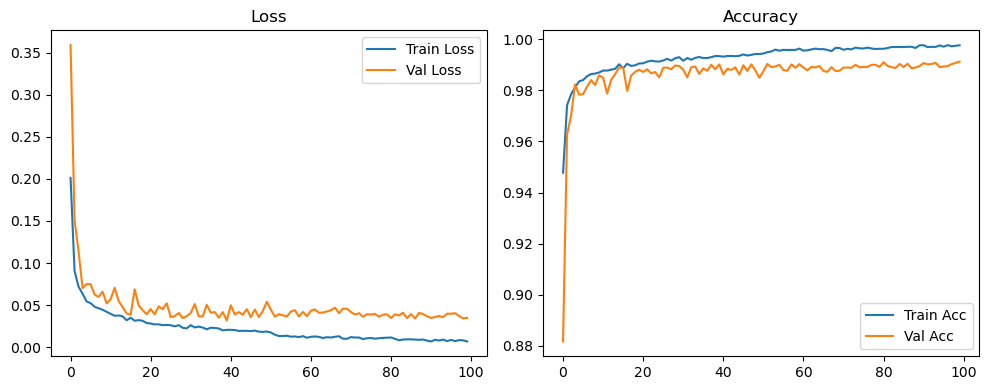

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1431, Acc: 0.9731 | Val Loss: 0.0511, Acc: 0.9842


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9896 | Val Loss: 0.0421, Acc: 0.9877


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9931 | Val Loss: 0.0375, Acc: 0.9896


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9957 | Val Loss: 0.0361, Acc: 0.9895


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0301, Acc: 0.9909


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0362, Acc: 0.9886


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.0331, Acc: 0.9904


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0331, Acc: 0.9907


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0410, Acc: 0.9886


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0314, Acc: 0.9910


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.0465, Acc: 0.9883


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0483, Acc: 0.9880


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0426, Acc: 0.9897


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0394, Acc: 0.9895


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0372, Acc: 0.9902


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0323, Acc: 0.9908


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0282, Acc: 0.9928


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0272, Acc: 0.9928


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0272, Acc: 0.9929


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0264, Acc: 0.9938


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0281, Acc: 0.9935


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0321, Acc: 0.9927


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.0447, Acc: 0.9885


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0329, Acc: 0.9919


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0296, Acc: 0.9928


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0308, Acc: 0.9924


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0304, Acc: 0.9928


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0331, Acc: 0.9913


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0387, Acc: 0.9909


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0393, Acc: 0.9899


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0276, Acc: 0.9933


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0326, Acc: 0.9927


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0274, Acc: 0.9934


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0282, Acc: 0.9939


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0292, Acc: 0.9937


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0302, Acc: 0.9939


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0312, Acc: 0.9934


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0308, Acc: 0.9932


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0308, Acc: 0.9932


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0298, Acc: 0.9934


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0845, Acc: 0.9843


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0343, Acc: 0.9921


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0311, Acc: 0.9932


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0328, Acc: 0.9927


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0308, Acc: 0.9929


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0291, Acc: 0.9936


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0289, Acc: 0.9940


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0301, Acc: 0.9932


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0301, Acc: 0.9934


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0517, Acc: 0.9901


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0303, Acc: 0.9924


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0353, Acc: 0.9922


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0328, Acc: 0.9924


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0348, Acc: 0.9926


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0359, Acc: 0.9920


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0336, Acc: 0.9922


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0356, Acc: 0.9923


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0318, Acc: 0.9932


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0337, Acc: 0.9928


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0364, Acc: 0.9920


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0324, Acc: 0.9923


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0397, Acc: 0.9915


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0337, Acc: 0.9928


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0299, Acc: 0.9935


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0343, Acc: 0.9934


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0311, Acc: 0.9933


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0318, Acc: 0.9934


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9938


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0315, Acc: 0.9936


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0310, Acc: 0.9938


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0314, Acc: 0.9939


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0311, Acc: 0.9938


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9933


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0316, Acc: 0.9933


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0467, Acc: 0.9909


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0405, Acc: 0.9922


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0361, Acc: 0.9939


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0358, Acc: 0.9934


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0344, Acc: 0.9932


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9933


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0336, Acc: 0.9938


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9942


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9941


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9942


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9943


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9943


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0452, Acc: 0.9912


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0449, Acc: 0.9919


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0393, Acc: 0.9920


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0401, Acc: 0.9930


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9936


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0441, Acc: 0.9928


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0382, Acc: 0.9925


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0359, Acc: 0.9935


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0401, Acc: 0.9927


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0370, Acc: 0.9935


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0393, Acc: 0.9931


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9934


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9938


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9942


Final Test Loss: 0.0304 Accuracy: 0.9941


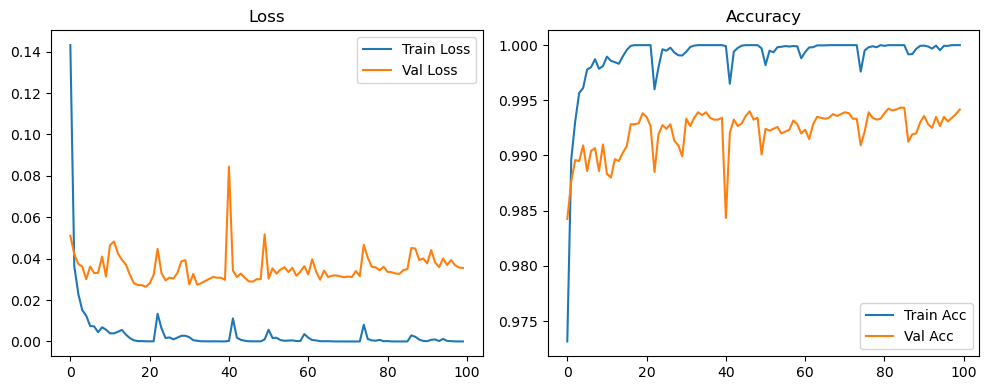

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1662, Acc: 0.9679 | Val Loss: 0.0796, Acc: 0.9785


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0514, Acc: 0.9848 | Val Loss: 0.0493, Acc: 0.9862


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9884 | Val Loss: 0.0401, Acc: 0.9880


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9914 | Val Loss: 0.0369, Acc: 0.9895


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.0371, Acc: 0.9886


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.0414, Acc: 0.9870


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0351, Acc: 0.9899


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.0298, Acc: 0.9913


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.0388, Acc: 0.9892


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0317, Acc: 0.9908


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.0370, Acc: 0.9898


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0291, Acc: 0.9920


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.0291, Acc: 0.9918


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.0313, Acc: 0.9921


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.0337, Acc: 0.9908


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0361, Acc: 0.9898


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0321, Acc: 0.9916


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0376, Acc: 0.9900


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0325, Acc: 0.9921


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0354, Acc: 0.9912


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0277, Acc: 0.9932


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0344, Acc: 0.9917


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0443, Acc: 0.9895


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0337, Acc: 0.9917


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0322, Acc: 0.9918


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0275, Acc: 0.9926


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0353, Acc: 0.9926


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0340, Acc: 0.9919


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0408, Acc: 0.9908


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0389, Acc: 0.9906


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0392, Acc: 0.9903


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0338, Acc: 0.9926


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0383, Acc: 0.9911


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0363, Acc: 0.9918


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0386, Acc: 0.9917


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0375, Acc: 0.9917


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0336, Acc: 0.9923


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0304, Acc: 0.9928


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0428, Acc: 0.9908


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0345, Acc: 0.9922


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0371, Acc: 0.9922


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0462, Acc: 0.9905


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0377, Acc: 0.9920


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0357, Acc: 0.9924


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0380, Acc: 0.9918


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0368, Acc: 0.9929


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0389, Acc: 0.9921


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0437, Acc: 0.9918


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0434, Acc: 0.9913


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9987 | Val Loss: 0.0515, Acc: 0.9896


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0372, Acc: 0.9932


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0387, Acc: 0.9923


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0434, Acc: 0.9909


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0345, Acc: 0.9918


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0400, Acc: 0.9915


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0444, Acc: 0.9914


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.0392, Acc: 0.9922


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0376, Acc: 0.9931


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0411, Acc: 0.9925


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0400, Acc: 0.9923


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0380, Acc: 0.9928


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0353, Acc: 0.9928


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0410, Acc: 0.9916


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0378, Acc: 0.9931


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0388, Acc: 0.9925


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0406, Acc: 0.9930


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0404, Acc: 0.9925


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0418, Acc: 0.9928


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0468, Acc: 0.9920


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0501, Acc: 0.9904


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0414, Acc: 0.9923


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0395, Acc: 0.9932


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0387, Acc: 0.9934


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0395, Acc: 0.9933


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0496, Acc: 0.9913


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0448, Acc: 0.9923


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0477, Acc: 0.9922


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0443, Acc: 0.9932


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0420, Acc: 0.9934


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0373, Acc: 0.9939


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0406, Acc: 0.9929


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0421, Acc: 0.9928


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0357, Acc: 0.9936


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0523, Acc: 0.9911


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0413, Acc: 0.9928


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0396, Acc: 0.9923


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0408, Acc: 0.9931


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0441, Acc: 0.9922


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0445, Acc: 0.9918


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0398, Acc: 0.9928


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0443, Acc: 0.9921


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0453, Acc: 0.9922


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0388, Acc: 0.9937


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0433, Acc: 0.9927


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0452, Acc: 0.9917


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0486, Acc: 0.9928


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0453, Acc: 0.9923


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0444, Acc: 0.9927


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0416, Acc: 0.9931


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0394, Acc: 0.9933


Final Test Loss: 0.0367 Accuracy: 0.9930


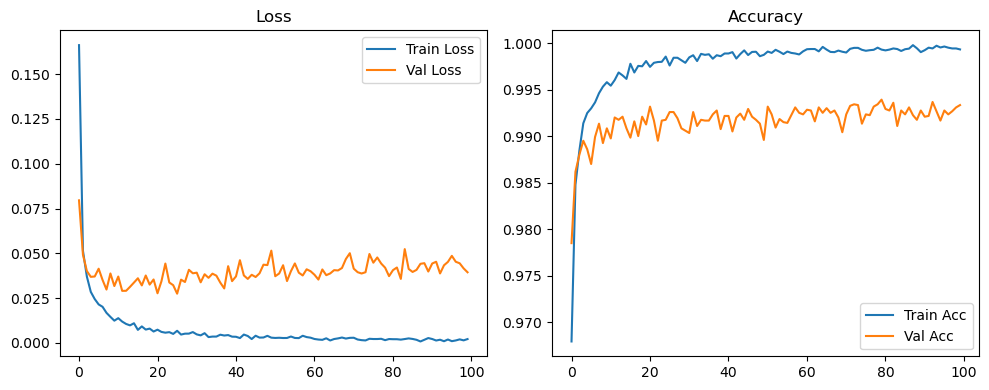

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2464, Acc: 0.9482 | Val Loss: 0.4021, Acc: 0.8673


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0906, Acc: 0.9750 | Val Loss: 0.1776, Acc: 0.9547


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0741, Acc: 0.9784 | Val Loss: 0.1184, Acc: 0.9710


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0621, Acc: 0.9822 | Val Loss: 0.0892, Acc: 0.9788


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0540, Acc: 0.9836 | Val Loss: 0.0644, Acc: 0.9838


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0517, Acc: 0.9843 | Val Loss: 0.0615, Acc: 0.9849


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9858 | Val Loss: 0.0536, Acc: 0.9863


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9861 | Val Loss: 0.0571, Acc: 0.9853


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9870 | Val Loss: 0.0520, Acc: 0.9862


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9879 | Val Loss: 0.0431, Acc: 0.9887


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9882 | Val Loss: 0.0451, Acc: 0.9885


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9885 | Val Loss: 0.0440, Acc: 0.9890


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9891 | Val Loss: 0.0479, Acc: 0.9867


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9898 | Val Loss: 0.0381, Acc: 0.9891


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9901 | Val Loss: 0.0354, Acc: 0.9906


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9893 | Val Loss: 0.0365, Acc: 0.9902


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9908 | Val Loss: 0.0387, Acc: 0.9888


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9911 | Val Loss: 0.0376, Acc: 0.9885


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.0420, Acc: 0.9876


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9912 | Val Loss: 0.0384, Acc: 0.9888


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9919 | Val Loss: 0.0393, Acc: 0.9883


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0363, Acc: 0.9897


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9922 | Val Loss: 0.0416, Acc: 0.9883


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9925 | Val Loss: 0.0403, Acc: 0.9889


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9922 | Val Loss: 0.0361, Acc: 0.9899


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9924 | Val Loss: 0.0405, Acc: 0.9878


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.0358, Acc: 0.9893


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9928 | Val Loss: 0.0366, Acc: 0.9903


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.0347, Acc: 0.9892


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.0410, Acc: 0.9882


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0333, Acc: 0.9897


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9930 | Val Loss: 0.0422, Acc: 0.9873


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9927 | Val Loss: 0.0351, Acc: 0.9892


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9934 | Val Loss: 0.0424, Acc: 0.9874


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.0439, Acc: 0.9875


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.0415, Acc: 0.9888


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9933 | Val Loss: 0.0473, Acc: 0.9866


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9936 | Val Loss: 0.0436, Acc: 0.9872


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.0434, Acc: 0.9878


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0351, Acc: 0.9901


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.0375, Acc: 0.9894


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9937 | Val Loss: 0.0444, Acc: 0.9874


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0366, Acc: 0.9898


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.0380, Acc: 0.9897


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9938 | Val Loss: 0.0396, Acc: 0.9888


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.0382, Acc: 0.9890


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.0443, Acc: 0.9878


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9936 | Val Loss: 0.0507, Acc: 0.9860


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0408, Acc: 0.9882


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.0392, Acc: 0.9891


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0417, Acc: 0.9885


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.0400, Acc: 0.9888


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0447, Acc: 0.9875


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0397, Acc: 0.9887


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0452, Acc: 0.9868


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0387, Acc: 0.9883


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.0440, Acc: 0.9878


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0509, Acc: 0.9863


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0481, Acc: 0.9859


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0407, Acc: 0.9888


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0467, Acc: 0.9868


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.0452, Acc: 0.9873


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0416, Acc: 0.9889


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9946 | Val Loss: 0.0380, Acc: 0.9891


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.0440, Acc: 0.9880


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9952 | Val Loss: 0.0539, Acc: 0.9852


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0486, Acc: 0.9867


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0419, Acc: 0.9882


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0590, Acc: 0.9845


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0526, Acc: 0.9858


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.0549, Acc: 0.9857


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0518, Acc: 0.9864


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.0573, Acc: 0.9848


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0365, Acc: 0.9906


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0382, Acc: 0.9898


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0443, Acc: 0.9884


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0513, Acc: 0.9882


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0544, Acc: 0.9861


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.0439, Acc: 0.9888


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0423, Acc: 0.9893


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9951 | Val Loss: 0.0448, Acc: 0.9879


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0476, Acc: 0.9874


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0599, Acc: 0.9843


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0503, Acc: 0.9872


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0469, Acc: 0.9883


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0480, Acc: 0.9877


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.0542, Acc: 0.9864


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0593, Acc: 0.9845


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0662, Acc: 0.9826


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0636, Acc: 0.9836


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0533, Acc: 0.9866


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9954 | Val Loss: 0.0585, Acc: 0.9852


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0591, Acc: 0.9854


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9954 | Val Loss: 0.0449, Acc: 0.9886


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0551, Acc: 0.9867


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0498, Acc: 0.9875


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0502, Acc: 0.9862


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0467, Acc: 0.9881


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0421, Acc: 0.9889


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0445, Acc: 0.9882


Final Test Loss: 0.0347 Accuracy: 0.9913


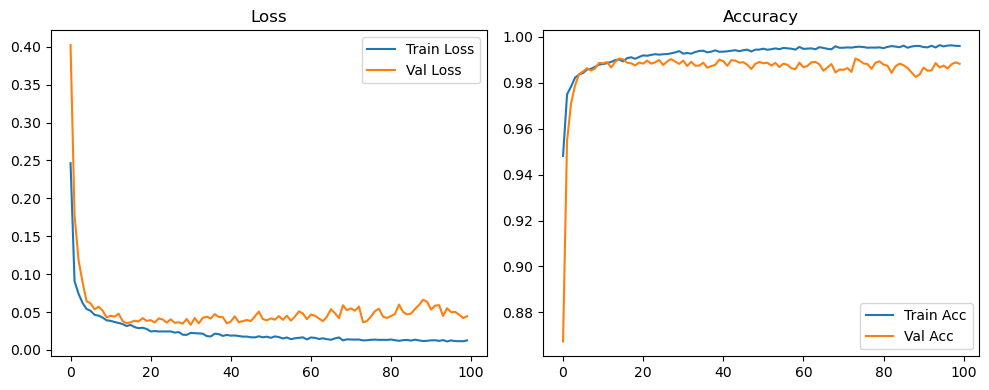

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1931, Acc: 0.9719 | Val Loss: 0.0607, Acc: 0.9839


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0410, Acc: 0.9898 | Val Loss: 0.0439, Acc: 0.9870


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9942 | Val Loss: 0.0428, Acc: 0.9876


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9958 | Val Loss: 0.0442, Acc: 0.9858


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9969 | Val Loss: 0.0328, Acc: 0.9900


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9979 | Val Loss: 0.0365, Acc: 0.9889


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.0292, Acc: 0.9908


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.0340, Acc: 0.9893


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.0350, Acc: 0.9895


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0385, Acc: 0.9888


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0391, Acc: 0.9894


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0323, Acc: 0.9907


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0369, Acc: 0.9907


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0351, Acc: 0.9917


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.0409, Acc: 0.9902


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.0420, Acc: 0.9897


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0318, Acc: 0.9921


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0386, Acc: 0.9907


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0350, Acc: 0.9915


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0404, Acc: 0.9906


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0310, Acc: 0.9925


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0363, Acc: 0.9904


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0375, Acc: 0.9902


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0331, Acc: 0.9920


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0338, Acc: 0.9918


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0311, Acc: 0.9923


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0323, Acc: 0.9924


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0303, Acc: 0.9933


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0302, Acc: 0.9937


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0302, Acc: 0.9936


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0301, Acc: 0.9938


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0290, Acc: 0.9940


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0299, Acc: 0.9941


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9936


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0309, Acc: 0.9936


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0314, Acc: 0.9935


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0311, Acc: 0.9934


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9931


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9932


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0315, Acc: 0.9939


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9960 | Val Loss: 0.0398, Acc: 0.9902


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0326, Acc: 0.9929


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0305, Acc: 0.9932


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0331, Acc: 0.9922


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0304, Acc: 0.9930


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9932


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0305, Acc: 0.9934


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0304, Acc: 0.9937


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0300, Acc: 0.9933


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0307, Acc: 0.9937


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0309, Acc: 0.9931


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0768, Acc: 0.9846


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0339, Acc: 0.9913


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0321, Acc: 0.9925


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0353, Acc: 0.9931


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9925


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9931


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0318, Acc: 0.9938


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9938


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9932


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0447, Acc: 0.9908


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0343, Acc: 0.9928


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0335, Acc: 0.9928


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9932


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0303, Acc: 0.9929


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0306, Acc: 0.9940


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0301, Acc: 0.9937


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9928


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0380, Acc: 0.9917


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0342, Acc: 0.9927


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0366, Acc: 0.9929


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9934


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9934


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9930


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9932


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9937


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9937


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9939


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9939


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0343, Acc: 0.9936


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9934


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9914


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0417, Acc: 0.9919


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0369, Acc: 0.9922


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0353, Acc: 0.9928


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0354, Acc: 0.9928


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0371, Acc: 0.9927


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9925


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0403, Acc: 0.9921


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0392, Acc: 0.9928


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0378, Acc: 0.9929


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9919


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0497, Acc: 0.9917


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0404, Acc: 0.9927


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0361, Acc: 0.9931


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9929


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9930


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9930


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9935


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9930


Final Test Loss: 0.0366 Accuracy: 0.9932


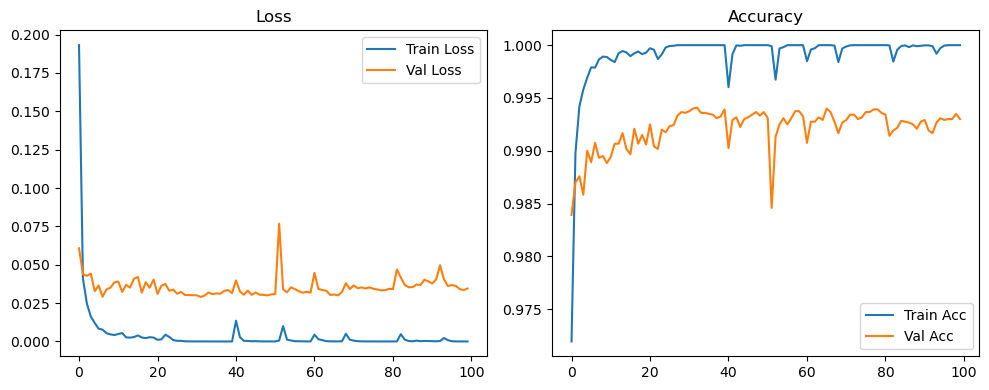

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2250, Acc: 0.9658 | Val Loss: 0.1123, Acc: 0.9749


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0568, Acc: 0.9855 | Val Loss: 0.0656, Acc: 0.9838


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9896 | Val Loss: 0.0520, Acc: 0.9862


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9920 | Val Loss: 0.0446, Acc: 0.9879


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9927 | Val Loss: 0.0414, Acc: 0.9890


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9934 | Val Loss: 0.0417, Acc: 0.9868


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9940 | Val Loss: 0.0334, Acc: 0.9901


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9953 | Val Loss: 0.0314, Acc: 0.9907


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9952 | Val Loss: 0.0321, Acc: 0.9913


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0338, Acc: 0.9901


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.0327, Acc: 0.9902


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0285, Acc: 0.9913


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0265, Acc: 0.9927


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0318, Acc: 0.9909


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0313, Acc: 0.9919


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0321, Acc: 0.9910


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.0327, Acc: 0.9912


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0361, Acc: 0.9902


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0291, Acc: 0.9913


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0317, Acc: 0.9912


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0257, Acc: 0.9931


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0308, Acc: 0.9920


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0311, Acc: 0.9919


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0300, Acc: 0.9924


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0280, Acc: 0.9926


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0283, Acc: 0.9920


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0278, Acc: 0.9925


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0280, Acc: 0.9925


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0319, Acc: 0.9916


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0344, Acc: 0.9925


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0321, Acc: 0.9917


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0311, Acc: 0.9923


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0345, Acc: 0.9915


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0324, Acc: 0.9919


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0325, Acc: 0.9915


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0334, Acc: 0.9921


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0288, Acc: 0.9933


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0326, Acc: 0.9920


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0329, Acc: 0.9919


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0293, Acc: 0.9928


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9985 | Val Loss: 0.0305, Acc: 0.9925


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0326, Acc: 0.9924


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0281, Acc: 0.9930


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0308, Acc: 0.9922


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0311, Acc: 0.9923


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0325, Acc: 0.9930


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0375, Acc: 0.9919


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0348, Acc: 0.9913


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0385, Acc: 0.9922


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0337, Acc: 0.9928


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0388, Acc: 0.9914


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0385, Acc: 0.9923


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0316, Acc: 0.9928


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0345, Acc: 0.9922


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0342, Acc: 0.9924


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0334, Acc: 0.9915


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0457, Acc: 0.9910


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0339, Acc: 0.9922


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0354, Acc: 0.9924


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0346, Acc: 0.9930


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0368, Acc: 0.9927


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0369, Acc: 0.9928


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0352, Acc: 0.9922


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0365, Acc: 0.9929


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0360, Acc: 0.9928


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0350, Acc: 0.9929


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0317, Acc: 0.9936


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0332, Acc: 0.9923


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0358, Acc: 0.9924


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0373, Acc: 0.9927


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0366, Acc: 0.9928


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0377, Acc: 0.9923


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0375, Acc: 0.9926


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0321, Acc: 0.9928


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0343, Acc: 0.9928


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0353, Acc: 0.9926


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0340, Acc: 0.9930


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0359, Acc: 0.9930


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0349, Acc: 0.9928


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0310, Acc: 0.9928


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0388, Acc: 0.9924


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0361, Acc: 0.9924


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0376, Acc: 0.9929


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0354, Acc: 0.9937


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.0359, Acc: 0.9933


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0330, Acc: 0.9938


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0346, Acc: 0.9928


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0357, Acc: 0.9922


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0392, Acc: 0.9927


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0373, Acc: 0.9932


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0347, Acc: 0.9927


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0367, Acc: 0.9927


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0374, Acc: 0.9923


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0381, Acc: 0.9927


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0369, Acc: 0.9929


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0357, Acc: 0.9932


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0377, Acc: 0.9932


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0359, Acc: 0.9937


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0383, Acc: 0.9935


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0404, Acc: 0.9932


Final Test Loss: 0.0385 Accuracy: 0.9917


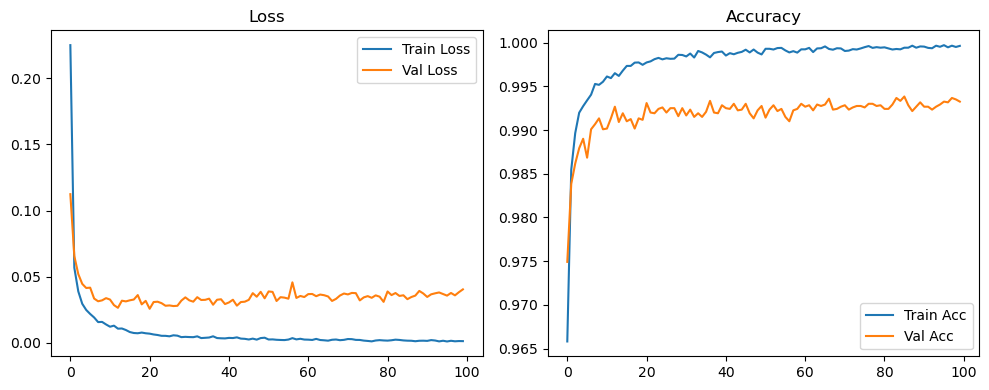

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3277, Acc: 0.9430 | Val Loss: 0.5807, Acc: 0.7890


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1029, Acc: 0.9742 | Val Loss: 0.2727, Acc: 0.9207


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0790, Acc: 0.9788 | Val Loss: 0.1567, Acc: 0.9672


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0662, Acc: 0.9817 | Val Loss: 0.1260, Acc: 0.9701


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0577, Acc: 0.9826 | Val Loss: 0.1145, Acc: 0.9725


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0555, Acc: 0.9832 | Val Loss: 0.0970, Acc: 0.9772


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0486, Acc: 0.9851 | Val Loss: 0.0936, Acc: 0.9769


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0473, Acc: 0.9859 | Val Loss: 0.0811, Acc: 0.9798


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9870 | Val Loss: 0.0670, Acc: 0.9838


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0413, Acc: 0.9878 | Val Loss: 0.0551, Acc: 0.9871


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9877 | Val Loss: 0.0593, Acc: 0.9868


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9875 | Val Loss: 0.0512, Acc: 0.9872


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9887 | Val Loss: 0.0643, Acc: 0.9834


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9896 | Val Loss: 0.0479, Acc: 0.9879


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.0476, Acc: 0.9889


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.0415, Acc: 0.9898


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9905 | Val Loss: 0.0469, Acc: 0.9879


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9901 | Val Loss: 0.0437, Acc: 0.9888


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.0451, Acc: 0.9872


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.0395, Acc: 0.9890


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9917 | Val Loss: 0.0390, Acc: 0.9895


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.0365, Acc: 0.9898


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9920 | Val Loss: 0.0340, Acc: 0.9906


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0347, Acc: 0.9912


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9922 | Val Loss: 0.0357, Acc: 0.9902


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9921 | Val Loss: 0.0358, Acc: 0.9906


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9921 | Val Loss: 0.0320, Acc: 0.9912


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0317, Acc: 0.9910


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.0318, Acc: 0.9906


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9932 | Val Loss: 0.0355, Acc: 0.9898


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0359, Acc: 0.9887


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.0371, Acc: 0.9890


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0346, Acc: 0.9898


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9934 | Val Loss: 0.0371, Acc: 0.9888


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9940 | Val Loss: 0.0396, Acc: 0.9878


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0356, Acc: 0.9896


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.0358, Acc: 0.9893


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9930 | Val Loss: 0.0311, Acc: 0.9911


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.0331, Acc: 0.9908


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.0318, Acc: 0.9906


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0344, Acc: 0.9901


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.0340, Acc: 0.9901


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.0308, Acc: 0.9912


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0338, Acc: 0.9903


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0375, Acc: 0.9881


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9944 | Val Loss: 0.0362, Acc: 0.9892


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.0350, Acc: 0.9903


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.0359, Acc: 0.9891


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0359, Acc: 0.9892


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.0408, Acc: 0.9875


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.0355, Acc: 0.9892


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0314, Acc: 0.9908


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0380, Acc: 0.9888


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0314, Acc: 0.9914


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.0399, Acc: 0.9886


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0356, Acc: 0.9893


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.0353, Acc: 0.9893


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0407, Acc: 0.9876


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9949 | Val Loss: 0.0358, Acc: 0.9890


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9956 | Val Loss: 0.0368, Acc: 0.9893


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.0392, Acc: 0.9882


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0411, Acc: 0.9880


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0355, Acc: 0.9902


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0362, Acc: 0.9899


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0372, Acc: 0.9895


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0386, Acc: 0.9881


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9946 | Val Loss: 0.0378, Acc: 0.9897


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0415, Acc: 0.9885


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9951 | Val Loss: 0.0497, Acc: 0.9861


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0388, Acc: 0.9889


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0426, Acc: 0.9882


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0463, Acc: 0.9865


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0402, Acc: 0.9884


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.0360, Acc: 0.9898


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9955 | Val Loss: 0.0386, Acc: 0.9887


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0394, Acc: 0.9888


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.0424, Acc: 0.9882


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0431, Acc: 0.9880


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0402, Acc: 0.9889


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.0445, Acc: 0.9877


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0424, Acc: 0.9878


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0420, Acc: 0.9876


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0452, Acc: 0.9868


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0445, Acc: 0.9875


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0390, Acc: 0.9897


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0518, Acc: 0.9848


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0488, Acc: 0.9875


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0490, Acc: 0.9866


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.0601, Acc: 0.9838


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0450, Acc: 0.9876


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.0451, Acc: 0.9876


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0500, Acc: 0.9868


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0496, Acc: 0.9870


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0424, Acc: 0.9886


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0472, Acc: 0.9872


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0461, Acc: 0.9871


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0503, Acc: 0.9867


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0450, Acc: 0.9874


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.0435, Acc: 0.9883


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0469, Acc: 0.9878


Final Test Loss: 0.0364 Accuracy: 0.9898


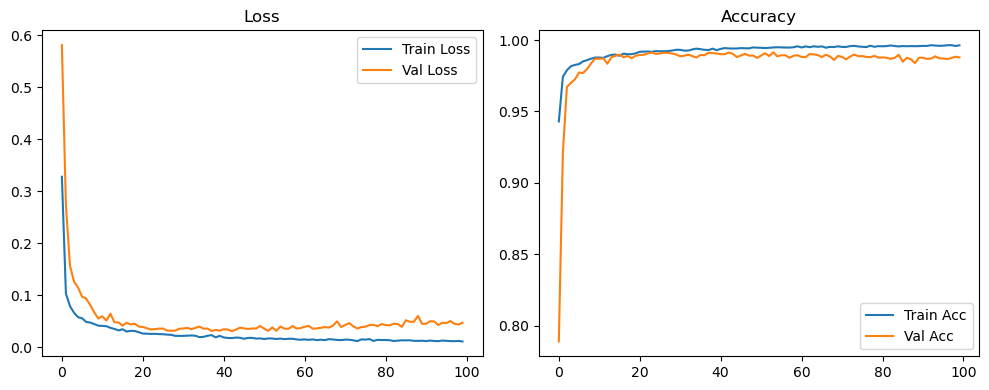

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1327, Acc: 0.9649 | Val Loss: 0.0482, Acc: 0.9858


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9884 | Val Loss: 0.0406, Acc: 0.9869


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9927 | Val Loss: 0.0398, Acc: 0.9868


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.0535, Acc: 0.9831


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.0363, Acc: 0.9892


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0368, Acc: 0.9891


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0319, Acc: 0.9904


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0390, Acc: 0.9895


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0457, Acc: 0.9885


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0410, Acc: 0.9902


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0632, Acc: 0.9843


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0429, Acc: 0.9894


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0456, Acc: 0.9891


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0454, Acc: 0.9898


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0478, Acc: 0.9902


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0401, Acc: 0.9911


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0528, Acc: 0.9889


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0513, Acc: 0.9894


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0442, Acc: 0.9907


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0436, Acc: 0.9906


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0390, Acc: 0.9922


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0387, Acc: 0.9921


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0369, Acc: 0.9922


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0452, Acc: 0.9914


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0555, Acc: 0.9893


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0554, Acc: 0.9889


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0415, Acc: 0.9917


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0381, Acc: 0.9925


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0362, Acc: 0.9928


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0380, Acc: 0.9926


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9930


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9931


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0376, Acc: 0.9928


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9924


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0384, Acc: 0.9929


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9932


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9929


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9932


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9931


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0384, Acc: 0.9933


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0380, Acc: 0.9933


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0387, Acc: 0.9933


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0380, Acc: 0.9933


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0385, Acc: 0.9932


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9932


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9931


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0388, Acc: 0.9932


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9932


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9933


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9932


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9934


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9934


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9934


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9933


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9932


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9934


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9934


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9932


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9933


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9919 | Val Loss: 0.0546, Acc: 0.9862


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0346, Acc: 0.9920


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0336, Acc: 0.9925


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0340, Acc: 0.9927


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9933


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9928


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9933


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0359, Acc: 0.9932


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9929


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9931


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9931


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0374, Acc: 0.9930


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9934


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9932


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9935


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9928


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9956 | Val Loss: 0.0480, Acc: 0.9892


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0384, Acc: 0.9917


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0390, Acc: 0.9923


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0371, Acc: 0.9932


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0436, Acc: 0.9912


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0409, Acc: 0.9920


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0517, Acc: 0.9908


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0553, Acc: 0.9908


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0587, Acc: 0.9908


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0494, Acc: 0.9921


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0517, Acc: 0.9911


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0410, Acc: 0.9922


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0452, Acc: 0.9925


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0420, Acc: 0.9932


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0417, Acc: 0.9922


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9930


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0528, Acc: 0.9914


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0586, Acc: 0.9906


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0503, Acc: 0.9904


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0552, Acc: 0.9912


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0460, Acc: 0.9926


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0397, Acc: 0.9933


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0449, Acc: 0.9929


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0554, Acc: 0.9910


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0500, Acc: 0.9916


Final Test Loss: 0.0448 Accuracy: 0.9911


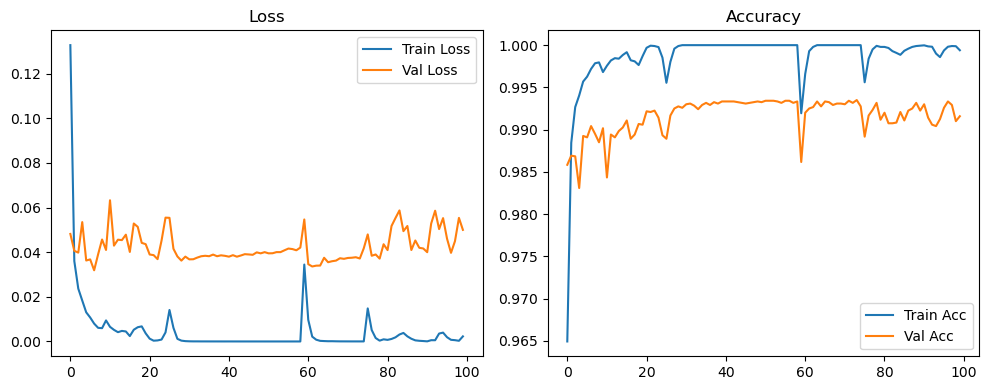

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1519, Acc: 0.9598 | Val Loss: 0.0876, Acc: 0.9742


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9847 | Val Loss: 0.0483, Acc: 0.9858


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9878 | Val Loss: 0.0440, Acc: 0.9868


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9901 | Val Loss: 0.0418, Acc: 0.9876


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9921 | Val Loss: 0.0436, Acc: 0.9865


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.0432, Acc: 0.9863


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0385, Acc: 0.9882


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.0401, Acc: 0.9885


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.0408, Acc: 0.9888


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0307, Acc: 0.9915


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0357, Acc: 0.9899


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.0441, Acc: 0.9876


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0315, Acc: 0.9917


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0288, Acc: 0.9915


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.0293, Acc: 0.9912


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0297, Acc: 0.9918


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9972 | Val Loss: 0.0348, Acc: 0.9910


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0495, Acc: 0.9884


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0351, Acc: 0.9912


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0352, Acc: 0.9915


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0283, Acc: 0.9934


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0335, Acc: 0.9921


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0348, Acc: 0.9912


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9974 | Val Loss: 0.0357, Acc: 0.9920


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0336, Acc: 0.9917


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.0385, Acc: 0.9908


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0331, Acc: 0.9925


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0425, Acc: 0.9908


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0356, Acc: 0.9918


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0291, Acc: 0.9939


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0321, Acc: 0.9918


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0366, Acc: 0.9914


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0312, Acc: 0.9933


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0352, Acc: 0.9912


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0354, Acc: 0.9926


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.0361, Acc: 0.9918


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0318, Acc: 0.9928


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0341, Acc: 0.9928


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9981 | Val Loss: 0.0346, Acc: 0.9928


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0342, Acc: 0.9930


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0333, Acc: 0.9932


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0384, Acc: 0.9914


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0318, Acc: 0.9929


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0398, Acc: 0.9921


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0382, Acc: 0.9928


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9982 | Val Loss: 0.0436, Acc: 0.9908


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0442, Acc: 0.9909


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0353, Acc: 0.9924


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.0376, Acc: 0.9927


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0420, Acc: 0.9915


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.0364, Acc: 0.9924


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0397, Acc: 0.9922


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0420, Acc: 0.9922


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0402, Acc: 0.9912


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0400, Acc: 0.9922


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0409, Acc: 0.9918


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0434, Acc: 0.9910


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0395, Acc: 0.9925


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0370, Acc: 0.9926


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0394, Acc: 0.9919


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0392, Acc: 0.9925


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0336, Acc: 0.9932


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0381, Acc: 0.9922


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0368, Acc: 0.9926


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0319, Acc: 0.9934


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9988 | Val Loss: 0.0363, Acc: 0.9925


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0396, Acc: 0.9923


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0386, Acc: 0.9930


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0423, Acc: 0.9909


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0355, Acc: 0.9926


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0342, Acc: 0.9937


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0402, Acc: 0.9911


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0334, Acc: 0.9925


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0345, Acc: 0.9930


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0345, Acc: 0.9929


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0396, Acc: 0.9934


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0360, Acc: 0.9925


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0321, Acc: 0.9928


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0380, Acc: 0.9925


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0415, Acc: 0.9918


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0372, Acc: 0.9912


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0385, Acc: 0.9918


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0363, Acc: 0.9924


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0395, Acc: 0.9921


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0361, Acc: 0.9925


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0436, Acc: 0.9921


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0385, Acc: 0.9916


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9990 | Val Loss: 0.0407, Acc: 0.9924


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0374, Acc: 0.9924


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0390, Acc: 0.9934


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0352, Acc: 0.9923


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0420, Acc: 0.9925


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0386, Acc: 0.9928


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0367, Acc: 0.9928


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0396, Acc: 0.9928


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0330, Acc: 0.9931


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0354, Acc: 0.9933


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0325, Acc: 0.9932


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0340, Acc: 0.9937


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0329, Acc: 0.9936


Final Test Loss: 0.0305 Accuracy: 0.9936


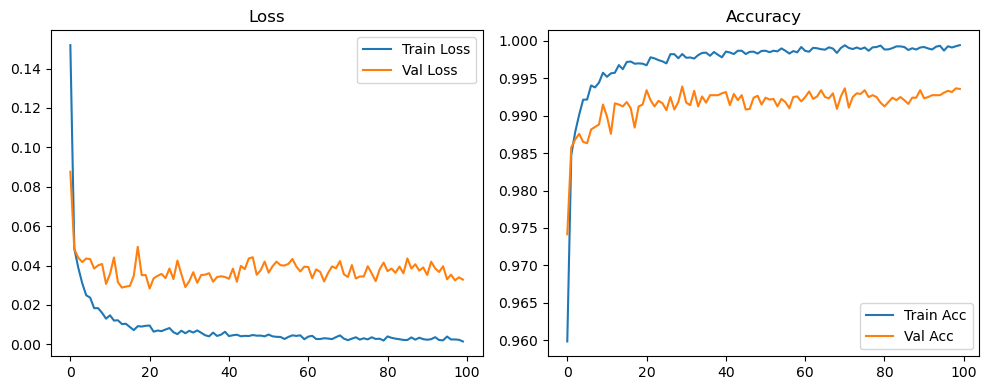

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2160, Acc: 0.9412 | Val Loss: 0.3253, Acc: 0.8932


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9735 | Val Loss: 0.0980, Acc: 0.9762


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9788 | Val Loss: 0.0912, Acc: 0.9777


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9807 | Val Loss: 0.0911, Acc: 0.9759


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9829 | Val Loss: 0.0768, Acc: 0.9814


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9846 | Val Loss: 0.0495, Acc: 0.9878


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9848 | Val Loss: 0.0532, Acc: 0.9851


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9866 | Val Loss: 0.0548, Acc: 0.9840


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9874 | Val Loss: 0.0522, Acc: 0.9857


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9886 | Val Loss: 0.0391, Acc: 0.9892


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9876 | Val Loss: 0.0526, Acc: 0.9846


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9887 | Val Loss: 0.0515, Acc: 0.9839


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9895 | Val Loss: 0.0460, Acc: 0.9871


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9891 | Val Loss: 0.0421, Acc: 0.9878


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9889 | Val Loss: 0.0373, Acc: 0.9892


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.0401, Acc: 0.9882


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.0331, Acc: 0.9906


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9900 | Val Loss: 0.0499, Acc: 0.9842


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9910 | Val Loss: 0.0336, Acc: 0.9898


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.0379, Acc: 0.9891


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9906 | Val Loss: 0.0430, Acc: 0.9869


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9920 | Val Loss: 0.0383, Acc: 0.9891


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9919 | Val Loss: 0.0372, Acc: 0.9890


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9910 | Val Loss: 0.0352, Acc: 0.9894


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.0329, Acc: 0.9907


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.0337, Acc: 0.9902


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9918 | Val Loss: 0.0345, Acc: 0.9895


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9917 | Val Loss: 0.0327, Acc: 0.9908


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0279, Acc: 0.9917


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9919 | Val Loss: 0.0369, Acc: 0.9894


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9924 | Val Loss: 0.0360, Acc: 0.9886


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9923 | Val Loss: 0.0372, Acc: 0.9882


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9926 | Val Loss: 0.0314, Acc: 0.9903


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.0303, Acc: 0.9910


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.0371, Acc: 0.9894


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.0312, Acc: 0.9904


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0354, Acc: 0.9898


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.0326, Acc: 0.9908


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.0357, Acc: 0.9899


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9930 | Val Loss: 0.0288, Acc: 0.9919


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0421, Acc: 0.9881


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.0283, Acc: 0.9918


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.0344, Acc: 0.9906


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9932 | Val Loss: 0.0363, Acc: 0.9898


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.0347, Acc: 0.9901


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.0352, Acc: 0.9893


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9926 | Val Loss: 0.0337, Acc: 0.9902


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9937 | Val Loss: 0.0457, Acc: 0.9880


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.0319, Acc: 0.9908


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0290, Acc: 0.9918


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0267, Acc: 0.9916


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9937 | Val Loss: 0.0427, Acc: 0.9880


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9937 | Val Loss: 0.0284, Acc: 0.9924


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.0371, Acc: 0.9899


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0350, Acc: 0.9903


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0335, Acc: 0.9902


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.0323, Acc: 0.9906


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.0351, Acc: 0.9906


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.0354, Acc: 0.9908


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.0392, Acc: 0.9888


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9943 | Val Loss: 0.0360, Acc: 0.9901


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9944 | Val Loss: 0.0426, Acc: 0.9872


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.0386, Acc: 0.9894


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.0382, Acc: 0.9894


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.0366, Acc: 0.9892


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0349, Acc: 0.9898


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9948 | Val Loss: 0.0414, Acc: 0.9888


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.0420, Acc: 0.9878


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.0476, Acc: 0.9872


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9947 | Val Loss: 0.0307, Acc: 0.9914


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0310, Acc: 0.9912


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0280, Acc: 0.9915


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9948 | Val Loss: 0.0332, Acc: 0.9902


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.0285, Acc: 0.9919


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9953 | Val Loss: 0.0322, Acc: 0.9908


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.0301, Acc: 0.9918


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.0377, Acc: 0.9900


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0321, Acc: 0.9906


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0361, Acc: 0.9898


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0376, Acc: 0.9899


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.0352, Acc: 0.9903


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.0445, Acc: 0.9880


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.0381, Acc: 0.9898


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0377, Acc: 0.9906


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0432, Acc: 0.9892


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.0323, Acc: 0.9906


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0255, Acc: 0.9931


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0342, Acc: 0.9908


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0452, Acc: 0.9882


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0364, Acc: 0.9902


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0270, Acc: 0.9920


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 0.0402, Acc: 0.9884


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9954 | Val Loss: 0.0317, Acc: 0.9904


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.0346, Acc: 0.9898


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0341, Acc: 0.9901


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0319, Acc: 0.9909


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.0248, Acc: 0.9928


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0277, Acc: 0.9918


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0334, Acc: 0.9910


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0304, Acc: 0.9914


Final Test Loss: 0.0256 Accuracy: 0.9929


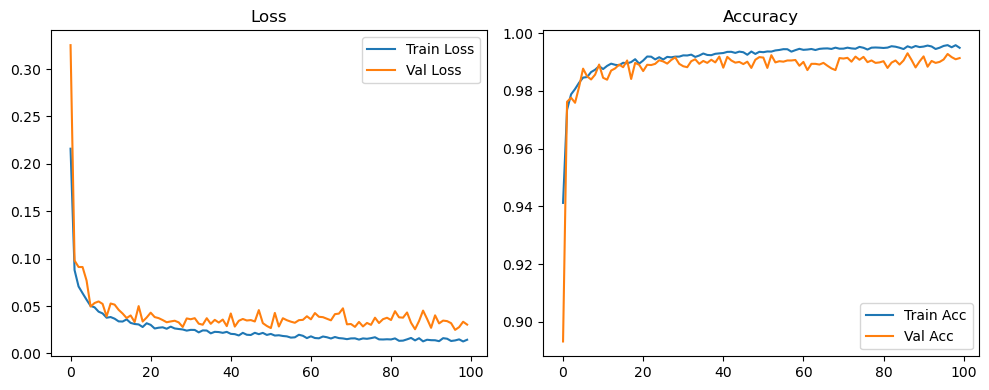

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1328, Acc: 0.9648 | Val Loss: 0.0478, Acc: 0.9860


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9882 | Val Loss: 0.0415, Acc: 0.9869


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9928 | Val Loss: 0.0446, Acc: 0.9857


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0458, Acc: 0.9860


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.0385, Acc: 0.9889


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.0364, Acc: 0.9899


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0378, Acc: 0.9901


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0387, Acc: 0.9898


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0500, Acc: 0.9876


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0449, Acc: 0.9886


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0545, Acc: 0.9871


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9980 | Val Loss: 0.0348, Acc: 0.9912


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0338, Acc: 0.9924


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.0411, Acc: 0.9908


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9977 | Val Loss: 0.0556, Acc: 0.9888


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.0484, Acc: 0.9891


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0465, Acc: 0.9897


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9983 | Val Loss: 0.0415, Acc: 0.9908


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0388, Acc: 0.9918


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0403, Acc: 0.9911


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0445, Acc: 0.9907


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0421, Acc: 0.9922


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0415, Acc: 0.9919


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0427, Acc: 0.9920


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0480, Acc: 0.9911


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0539, Acc: 0.9886


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0531, Acc: 0.9899


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0423, Acc: 0.9914


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0466, Acc: 0.9908


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0461, Acc: 0.9914


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0408, Acc: 0.9922


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0370, Acc: 0.9922


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0349, Acc: 0.9932


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9930


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0363, Acc: 0.9930


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0366, Acc: 0.9927


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9928


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0364, Acc: 0.9928


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9930


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9930


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9933


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9930


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9932


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0364, Acc: 0.9932


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9932


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9928


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0374, Acc: 0.9929


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0379, Acc: 0.9931


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9932


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0385, Acc: 0.9931


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0376, Acc: 0.9932


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9930


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9933


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9930


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0388, Acc: 0.9932


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9929


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9935


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9930


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9929


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9929


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9927


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9928


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9973 | Val Loss: 0.0597, Acc: 0.9884


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0399, Acc: 0.9924


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0412, Acc: 0.9928


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9928


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9929


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9934


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9928


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9931


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9932


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9929


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9929


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9934


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0403, Acc: 0.9932


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9927


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9928


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9925


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9929


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9929


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9928


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9929


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9928


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9930


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9929


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9928


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9932


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9930


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9929


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9929


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9931


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9931


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9934


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9931


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9928


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9932


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9934


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9932


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9931


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9934


Final Test Loss: 0.0374 Accuracy: 0.9937


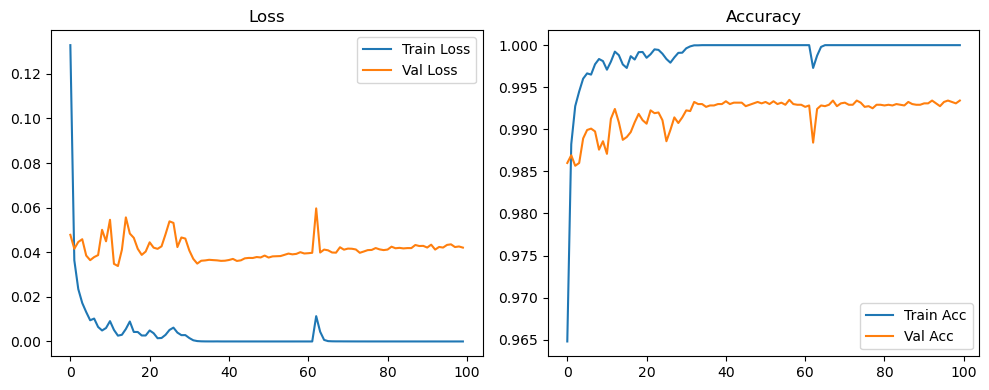

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1519, Acc: 0.9594 | Val Loss: 0.0811, Acc: 0.9762


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9845 | Val Loss: 0.0486, Acc: 0.9856


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9881 | Val Loss: 0.0410, Acc: 0.9882


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9904 | Val Loss: 0.0430, Acc: 0.9874


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9922 | Val Loss: 0.0416, Acc: 0.9868


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.0379, Acc: 0.9873


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.0340, Acc: 0.9892


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.0409, Acc: 0.9882


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.0466, Acc: 0.9869


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0293, Acc: 0.9909


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.0314, Acc: 0.9908


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0396, Acc: 0.9885


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0385, Acc: 0.9899


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0329, Acc: 0.9907


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0330, Acc: 0.9908


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0343, Acc: 0.9910


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.0346, Acc: 0.9904


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9959 | Val Loss: 0.0401, Acc: 0.9898


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0280, Acc: 0.9925


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0347, Acc: 0.9906


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0353, Acc: 0.9917


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0366, Acc: 0.9908


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0429, Acc: 0.9898


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.0475, Acc: 0.9889


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0361, Acc: 0.9915


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0363, Acc: 0.9921


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0357, Acc: 0.9912


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0353, Acc: 0.9922


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0340, Acc: 0.9923


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0290, Acc: 0.9926


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0336, Acc: 0.9925


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0333, Acc: 0.9933


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0443, Acc: 0.9912


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0334, Acc: 0.9925


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0389, Acc: 0.9916


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9980 | Val Loss: 0.0356, Acc: 0.9923


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0345, Acc: 0.9927


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0335, Acc: 0.9924


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0412, Acc: 0.9903


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.0310, Acc: 0.9930


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0342, Acc: 0.9914


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0338, Acc: 0.9922


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0380, Acc: 0.9921


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0394, Acc: 0.9909


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0328, Acc: 0.9932


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0395, Acc: 0.9915


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0327, Acc: 0.9932


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0322, Acc: 0.9927


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0457, Acc: 0.9912


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0428, Acc: 0.9911


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0335, Acc: 0.9933


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0311, Acc: 0.9940


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.0323, Acc: 0.9931


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0301, Acc: 0.9942


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0329, Acc: 0.9941


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0348, Acc: 0.9937


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0351, Acc: 0.9937


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0309, Acc: 0.9942


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0313, Acc: 0.9946


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0305, Acc: 0.9947


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0332, Acc: 0.9941


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0334, Acc: 0.9942


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0309, Acc: 0.9942


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0355, Acc: 0.9939


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0340, Acc: 0.9940


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0349, Acc: 0.9942


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0401, Acc: 0.9931


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0382, Acc: 0.9937


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0386, Acc: 0.9932


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0407, Acc: 0.9924


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0345, Acc: 0.9928


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0357, Acc: 0.9931


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0346, Acc: 0.9932


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0353, Acc: 0.9927


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0405, Acc: 0.9925


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0356, Acc: 0.9940


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0347, Acc: 0.9938


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0353, Acc: 0.9928


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.0359, Acc: 0.9933


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0359, Acc: 0.9928


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.0349, Acc: 0.9938


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0376, Acc: 0.9932


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0354, Acc: 0.9938


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0365, Acc: 0.9934


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0348, Acc: 0.9934


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0346, Acc: 0.9936


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0350, Acc: 0.9941


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0340, Acc: 0.9939


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0347, Acc: 0.9938


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0342, Acc: 0.9939


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0326, Acc: 0.9940


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0319, Acc: 0.9940


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0310, Acc: 0.9943


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9942


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0337, Acc: 0.9941


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0329, Acc: 0.9948


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0342, Acc: 0.9938


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9940


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0347, Acc: 0.9939


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0352, Acc: 0.9941


Final Test Loss: 0.0262 Accuracy: 0.9941


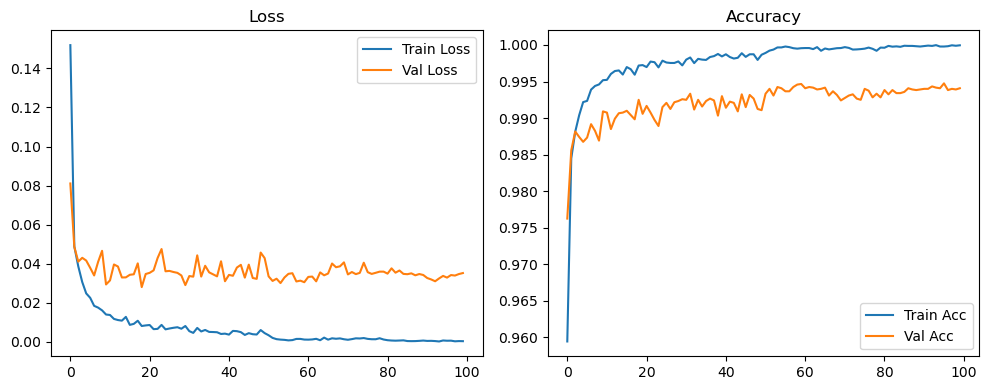

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2162, Acc: 0.9413 | Val Loss: 0.3410, Acc: 0.8878


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0870, Acc: 0.9743 | Val Loss: 0.0919, Acc: 0.9785


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9787 | Val Loss: 0.0983, Acc: 0.9753


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9812 | Val Loss: 0.0989, Acc: 0.9732


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9828 | Val Loss: 0.0797, Acc: 0.9788


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9849 | Val Loss: 0.0531, Acc: 0.9866


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9850 | Val Loss: 0.0548, Acc: 0.9851


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9865 | Val Loss: 0.0630, Acc: 0.9815


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9872 | Val Loss: 0.0512, Acc: 0.9865


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9882 | Val Loss: 0.0413, Acc: 0.9895


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9881 | Val Loss: 0.0562, Acc: 0.9842


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.0777, Acc: 0.9758


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 0.0419, Acc: 0.9879


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9887 | Val Loss: 0.0440, Acc: 0.9866


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9886 | Val Loss: 0.0383, Acc: 0.9887


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.0389, Acc: 0.9879


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9898 | Val Loss: 0.0388, Acc: 0.9887


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.0656, Acc: 0.9789


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.0407, Acc: 0.9880


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9906 | Val Loss: 0.0443, Acc: 0.9868


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.0390, Acc: 0.9893


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.0434, Acc: 0.9876


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.0391, Acc: 0.9897


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9906 | Val Loss: 0.0327, Acc: 0.9908


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9917 | Val Loss: 0.0417, Acc: 0.9879


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9908 | Val Loss: 0.0370, Acc: 0.9902


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9910 | Val Loss: 0.0348, Acc: 0.9899


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0369, Acc: 0.9897


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0324, Acc: 0.9902


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9923 | Val Loss: 0.0333, Acc: 0.9903


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0379, Acc: 0.9887


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9926 | Val Loss: 0.0361, Acc: 0.9895


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.0465, Acc: 0.9868


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.0355, Acc: 0.9897


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.0365, Acc: 0.9893


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 0.0365, Acc: 0.9892


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0333, Acc: 0.9908


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.0320, Acc: 0.9917


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.0411, Acc: 0.9878


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.0271, Acc: 0.9913


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9937 | Val Loss: 0.0373, Acc: 0.9892


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9937 | Val Loss: 0.0340, Acc: 0.9906


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.0313, Acc: 0.9912


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9940 | Val Loss: 0.0399, Acc: 0.9890


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0379, Acc: 0.9897


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0334, Acc: 0.9910


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.0283, Acc: 0.9914


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.0334, Acc: 0.9900


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0327, Acc: 0.9906


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0283, Acc: 0.9922


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.0297, Acc: 0.9914


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0301, Acc: 0.9922


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0328, Acc: 0.9908


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.0305, Acc: 0.9910


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0328, Acc: 0.9908


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0320, Acc: 0.9912


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0332, Acc: 0.9912


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9954 | Val Loss: 0.0310, Acc: 0.9919


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.0292, Acc: 0.9919


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0307, Acc: 0.9919


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0303, Acc: 0.9920


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0336, Acc: 0.9910


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0307, Acc: 0.9914


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0310, Acc: 0.9911


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0284, Acc: 0.9921


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0288, Acc: 0.9926


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0319, Acc: 0.9911


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0291, Acc: 0.9923


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0271, Acc: 0.9928


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0261, Acc: 0.9926


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0281, Acc: 0.9925


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0290, Acc: 0.9922


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0292, Acc: 0.9921


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0279, Acc: 0.9922


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0312, Acc: 0.9906


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0299, Acc: 0.9915


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0274, Acc: 0.9922


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0281, Acc: 0.9929


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0316, Acc: 0.9922


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0324, Acc: 0.9915


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0314, Acc: 0.9922


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0349, Acc: 0.9913


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0317, Acc: 0.9914


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0318, Acc: 0.9922


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0317, Acc: 0.9920


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0316, Acc: 0.9915


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.0297, Acc: 0.9924


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0314, Acc: 0.9919


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0311, Acc: 0.9918


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0308, Acc: 0.9918


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0289, Acc: 0.9924


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0320, Acc: 0.9918


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9970 | Val Loss: 0.0303, Acc: 0.9922


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0310, Acc: 0.9918


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0314, Acc: 0.9914


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0343, Acc: 0.9911


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0313, Acc: 0.9918


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0281, Acc: 0.9924


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0313, Acc: 0.9918


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0286, Acc: 0.9922


Final Test Loss: 0.0197 Accuracy: 0.9942


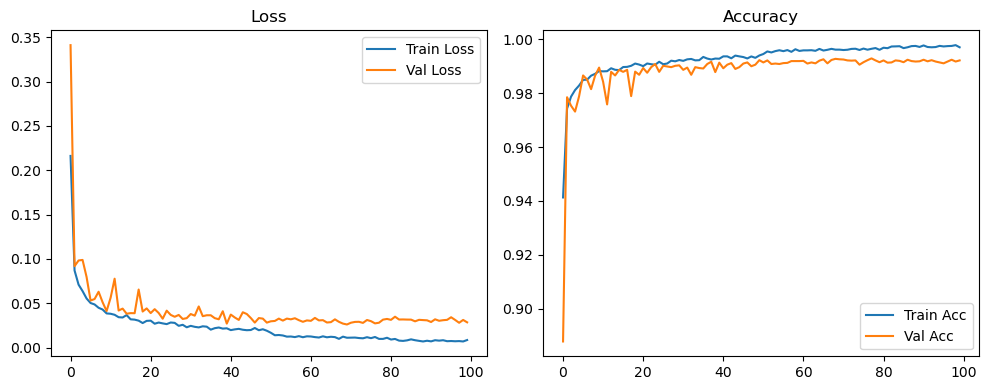

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1329, Acc: 0.9647 | Val Loss: 0.0477, Acc: 0.9862


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9885 | Val Loss: 0.0405, Acc: 0.9872


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9926 | Val Loss: 0.0393, Acc: 0.9875


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0622, Acc: 0.9815


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0374, Acc: 0.9889


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0441, Acc: 0.9882


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0368, Acc: 0.9902


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9967 | Val Loss: 0.0439, Acc: 0.9882


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0579, Acc: 0.9852


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0386, Acc: 0.9902


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0371, Acc: 0.9905


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0391, Acc: 0.9910


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0682, Acc: 0.9848


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0528, Acc: 0.9870


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0412, Acc: 0.9908


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0392, Acc: 0.9908


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0372, Acc: 0.9912


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0468, Acc: 0.9899


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0484, Acc: 0.9898


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0423, Acc: 0.9906


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0474, Acc: 0.9906


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0380, Acc: 0.9922


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0441, Acc: 0.9911


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0447, Acc: 0.9918


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0414, Acc: 0.9921


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0596, Acc: 0.9876


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0607, Acc: 0.9868


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0382, Acc: 0.9926


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0480, Acc: 0.9905


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0431, Acc: 0.9925


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0411, Acc: 0.9930


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0436, Acc: 0.9922


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.0583, Acc: 0.9892


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0532, Acc: 0.9896


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0445, Acc: 0.9915


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0441, Acc: 0.9918


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0372, Acc: 0.9928


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0421, Acc: 0.9929


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0403, Acc: 0.9928


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9932


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9937


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9936


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9941


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9938


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9939


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9936


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9939


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9937


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9942


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9938


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9940


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9938


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9939


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0385, Acc: 0.9939


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9942


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9938


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9941


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0385, Acc: 0.9938


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9936


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9939


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9938


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9939


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9940


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9938


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9935


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9935


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9942


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9939


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9939


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9939


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9938


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9939


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9940


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9939


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9939


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9938


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9938


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9937


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9937


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9934


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0417, Acc: 0.9938


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9938


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9939


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9938


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9935


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9937


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9938


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9939


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9937


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9938


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9938


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9939


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9940


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9938


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9939


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9940


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9942


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9937


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9940


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9938


Final Test Loss: 0.0351 Accuracy: 0.9936


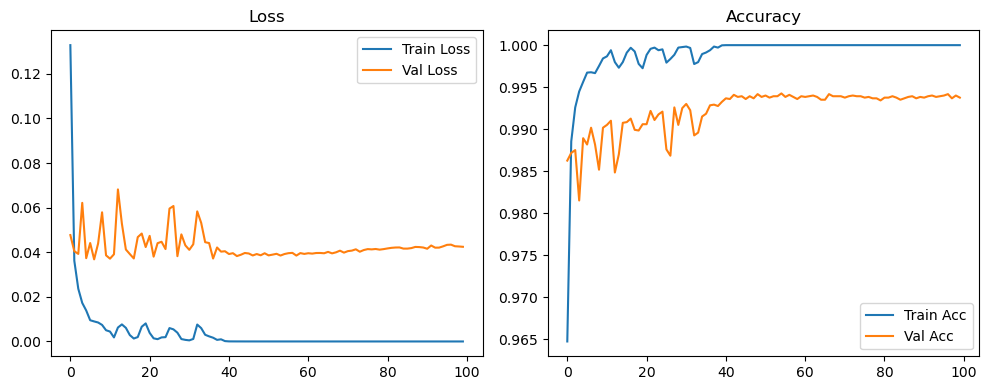

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1522, Acc: 0.9595 | Val Loss: 0.1002, Acc: 0.9702


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9849 | Val Loss: 0.0527, Acc: 0.9835


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9880 | Val Loss: 0.0512, Acc: 0.9857


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9901 | Val Loss: 0.0438, Acc: 0.9868


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9917 | Val Loss: 0.0433, Acc: 0.9864


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.0391, Acc: 0.9882


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.0368, Acc: 0.9896


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9942 | Val Loss: 0.0398, Acc: 0.9887


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0410, Acc: 0.9888


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9950 | Val Loss: 0.0317, Acc: 0.9916


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9956 | Val Loss: 0.0347, Acc: 0.9900


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.0371, Acc: 0.9893


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0338, Acc: 0.9913


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0349, Acc: 0.9910


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0307, Acc: 0.9911


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0319, Acc: 0.9917


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0388, Acc: 0.9903


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0453, Acc: 0.9892


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0325, Acc: 0.9922


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0466, Acc: 0.9882


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0313, Acc: 0.9922


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0485, Acc: 0.9888


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0310, Acc: 0.9915


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0483, Acc: 0.9881


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0383, Acc: 0.9910


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0375, Acc: 0.9914


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9970 | Val Loss: 0.0463, Acc: 0.9905


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0382, Acc: 0.9909


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0325, Acc: 0.9923


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0346, Acc: 0.9922


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0378, Acc: 0.9916


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0301, Acc: 0.9932


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0324, Acc: 0.9926


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0321, Acc: 0.9928


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0350, Acc: 0.9911


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0371, Acc: 0.9913


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0370, Acc: 0.9918


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0303, Acc: 0.9923


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0440, Acc: 0.9920


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0354, Acc: 0.9927


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0352, Acc: 0.9936


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0361, Acc: 0.9923


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0350, Acc: 0.9922


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0387, Acc: 0.9922


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0453, Acc: 0.9908


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0359, Acc: 0.9919


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0446, Acc: 0.9902


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0406, Acc: 0.9923


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0360, Acc: 0.9924


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0376, Acc: 0.9921


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0348, Acc: 0.9938


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0318, Acc: 0.9942


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0357, Acc: 0.9936


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0358, Acc: 0.9943


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0364, Acc: 0.9936


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0377, Acc: 0.9936


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0402, Acc: 0.9938


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0402, Acc: 0.9926


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0412, Acc: 0.9931


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0399, Acc: 0.9928


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0366, Acc: 0.9932


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0398, Acc: 0.9925


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0398, Acc: 0.9931


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0361, Acc: 0.9940


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0416, Acc: 0.9933


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0363, Acc: 0.9932


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0397, Acc: 0.9927


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0421, Acc: 0.9922


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0420, Acc: 0.9928


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0396, Acc: 0.9938


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0354, Acc: 0.9938


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0412, Acc: 0.9928


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0365, Acc: 0.9932


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0373, Acc: 0.9924


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0404, Acc: 0.9926


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0415, Acc: 0.9927


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0393, Acc: 0.9939


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0420, Acc: 0.9922


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0392, Acc: 0.9931


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0405, Acc: 0.9932


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0365, Acc: 0.9942


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0384, Acc: 0.9937


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0361, Acc: 0.9942


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0367, Acc: 0.9936


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0367, Acc: 0.9938


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0362, Acc: 0.9938


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0365, Acc: 0.9939


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0374, Acc: 0.9939


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0365, Acc: 0.9938


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9941


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0347, Acc: 0.9944


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0371, Acc: 0.9943


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9946


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0359, Acc: 0.9942


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0353, Acc: 0.9942


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9946


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0344, Acc: 0.9942


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0345, Acc: 0.9943


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9944


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0352, Acc: 0.9942


Final Test Loss: 0.0274 Accuracy: 0.9936


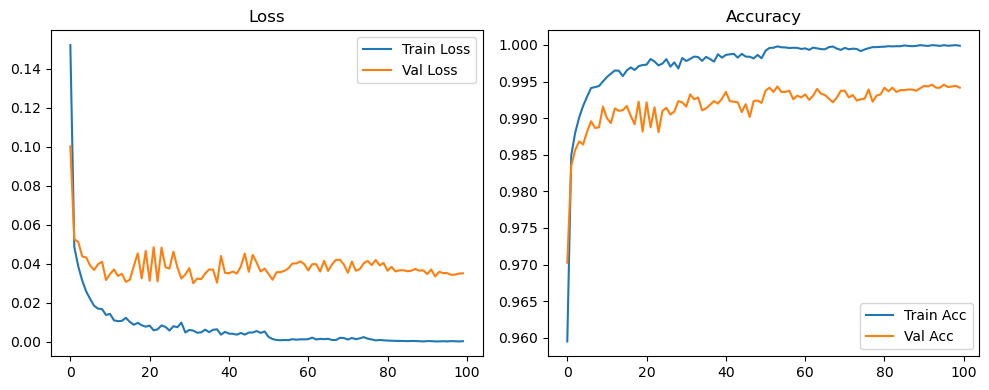

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2166, Acc: 0.9410 | Val Loss: 0.3548, Acc: 0.8830


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0876, Acc: 0.9739 | Val Loss: 0.0997, Acc: 0.9766


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9782 | Val Loss: 0.0950, Acc: 0.9768


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9816 | Val Loss: 0.0986, Acc: 0.9735


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9832 | Val Loss: 0.0758, Acc: 0.9806


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9845 | Val Loss: 0.0573, Acc: 0.9855


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9851 | Val Loss: 0.0522, Acc: 0.9858


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9860 | Val Loss: 0.0525, Acc: 0.9847


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9868 | Val Loss: 0.0516, Acc: 0.9859


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9885 | Val Loss: 0.0437, Acc: 0.9884


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9874 | Val Loss: 0.0486, Acc: 0.9866


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9892 | Val Loss: 0.0627, Acc: 0.9801


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9894 | Val Loss: 0.0396, Acc: 0.9886


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.0403, Acc: 0.9880


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9889 | Val Loss: 0.0424, Acc: 0.9874


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9900 | Val Loss: 0.0527, Acc: 0.9833


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9896 | Val Loss: 0.0392, Acc: 0.9881


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9900 | Val Loss: 0.0572, Acc: 0.9824


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.0370, Acc: 0.9892


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9903 | Val Loss: 0.0389, Acc: 0.9880


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9909 | Val Loss: 0.0386, Acc: 0.9886


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.0383, Acc: 0.9889


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9916 | Val Loss: 0.0377, Acc: 0.9892


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9914 | Val Loss: 0.0342, Acc: 0.9897


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.0366, Acc: 0.9897


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9912 | Val Loss: 0.0354, Acc: 0.9892


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9916 | Val Loss: 0.0355, Acc: 0.9893


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.0311, Acc: 0.9908


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9919 | Val Loss: 0.0267, Acc: 0.9923


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.0299, Acc: 0.9915


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.0325, Acc: 0.9896


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0352, Acc: 0.9895


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0390, Acc: 0.9883


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9914 | Val Loss: 0.0287, Acc: 0.9918


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.0363, Acc: 0.9894


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9925 | Val Loss: 0.0323, Acc: 0.9910


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.0323, Acc: 0.9912


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9926 | Val Loss: 0.0274, Acc: 0.9922


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9928 | Val Loss: 0.0387, Acc: 0.9894


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.0277, Acc: 0.9917


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9935 | Val Loss: 0.0373, Acc: 0.9890


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.0297, Acc: 0.9909


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0290, Acc: 0.9915


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9928 | Val Loss: 0.0411, Acc: 0.9878


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0345, Acc: 0.9898


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0369, Acc: 0.9897


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0302, Acc: 0.9915


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.0381, Acc: 0.9894


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0349, Acc: 0.9898


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0316, Acc: 0.9911


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.0300, Acc: 0.9908


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0291, Acc: 0.9913


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9949 | Val Loss: 0.0306, Acc: 0.9907


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0292, Acc: 0.9909


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0298, Acc: 0.9919


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0284, Acc: 0.9916


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9953 | Val Loss: 0.0269, Acc: 0.9920


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9949 | Val Loss: 0.0315, Acc: 0.9913


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.0267, Acc: 0.9923


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0272, Acc: 0.9920


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0266, Acc: 0.9921


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0295, Acc: 0.9912


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9957 | Val Loss: 0.0316, Acc: 0.9913


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0304, Acc: 0.9912


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0296, Acc: 0.9915


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0281, Acc: 0.9922


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0300, Acc: 0.9911


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0273, Acc: 0.9921


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0299, Acc: 0.9917


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0281, Acc: 0.9921


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9961 | Val Loss: 0.0252, Acc: 0.9926


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0285, Acc: 0.9922


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0275, Acc: 0.9924


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.0253, Acc: 0.9929


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0336, Acc: 0.9906


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0257, Acc: 0.9923


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0271, Acc: 0.9926


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0262, Acc: 0.9930


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0302, Acc: 0.9920


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0267, Acc: 0.9928


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9964 | Val Loss: 0.0277, Acc: 0.9922


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0297, Acc: 0.9919


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.0279, Acc: 0.9926


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0273, Acc: 0.9927


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0265, Acc: 0.9928


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0265, Acc: 0.9928


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.0262, Acc: 0.9928


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0282, Acc: 0.9923


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0276, Acc: 0.9925


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0264, Acc: 0.9926


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0258, Acc: 0.9928


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0275, Acc: 0.9925


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0261, Acc: 0.9928


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0278, Acc: 0.9924


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.0272, Acc: 0.9928


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9972 | Val Loss: 0.0286, Acc: 0.9922


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0275, Acc: 0.9928


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0261, Acc: 0.9930


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0270, Acc: 0.9926


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0268, Acc: 0.9923


Final Test Loss: 0.0182 Accuracy: 0.9944


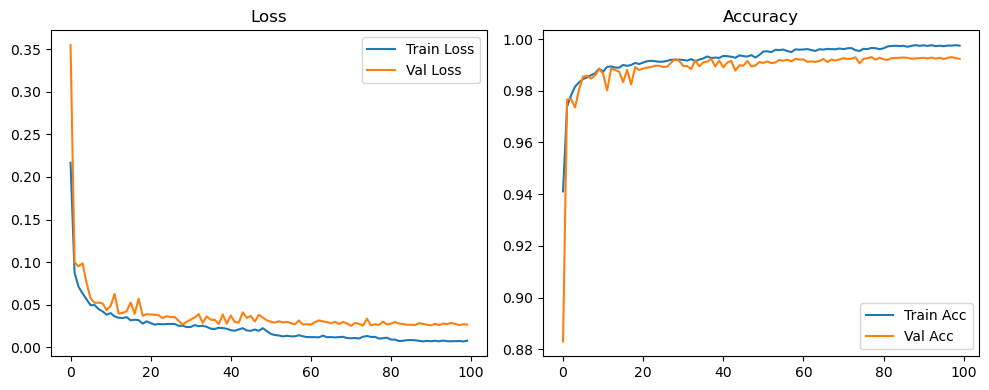

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1328, Acc: 0.9651 | Val Loss: 0.0466, Acc: 0.9865


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9884 | Val Loss: 0.0405, Acc: 0.9872


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.0436, Acc: 0.9862


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0544, Acc: 0.9845


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.0346, Acc: 0.9898


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0411, Acc: 0.9876


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0352, Acc: 0.9903


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0382, Acc: 0.9894


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0562, Acc: 0.9872


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0404, Acc: 0.9877


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0361, Acc: 0.9905


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0384, Acc: 0.9911


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0528, Acc: 0.9878


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0449, Acc: 0.9902


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0426, Acc: 0.9919


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0446, Acc: 0.9901


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0602, Acc: 0.9869


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0474, Acc: 0.9892


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0376, Acc: 0.9918


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0362, Acc: 0.9922


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0389, Acc: 0.9922


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0382, Acc: 0.9924


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0560, Acc: 0.9899


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0551, Acc: 0.9890


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0498, Acc: 0.9898


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0389, Acc: 0.9914


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0483, Acc: 0.9906


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0390, Acc: 0.9923


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0394, Acc: 0.9924


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9926


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0435, Acc: 0.9920


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0583, Acc: 0.9892


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0507, Acc: 0.9902


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0548, Acc: 0.9894


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0455, Acc: 0.9915


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0382, Acc: 0.9931


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9927


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0479, Acc: 0.9922


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0615, Acc: 0.9894


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0609, Acc: 0.9899


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0451, Acc: 0.9922


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0403, Acc: 0.9928


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0494, Acc: 0.9917


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0507, Acc: 0.9918


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0444, Acc: 0.9928


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0458, Acc: 0.9930


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0476, Acc: 0.9932


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9928


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9931


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9932


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9928


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9933


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9930


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9929


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9931


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9932


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9932


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9933


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9932


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9931


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9931


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9932


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9932


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9932


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9933


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9933


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9932


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9939


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9936


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9940


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0433, Acc: 0.9938


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9936


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9936


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9938


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9938


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9938


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9938


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9938


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9938


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9938


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9938


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9938


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9942


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9938


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9936


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9938


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9938


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9938


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9939


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9938


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9938


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9939


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9939


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9941


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9938


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9940


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9941


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9938


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9940


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9940


Final Test Loss: 0.0370 Accuracy: 0.9929


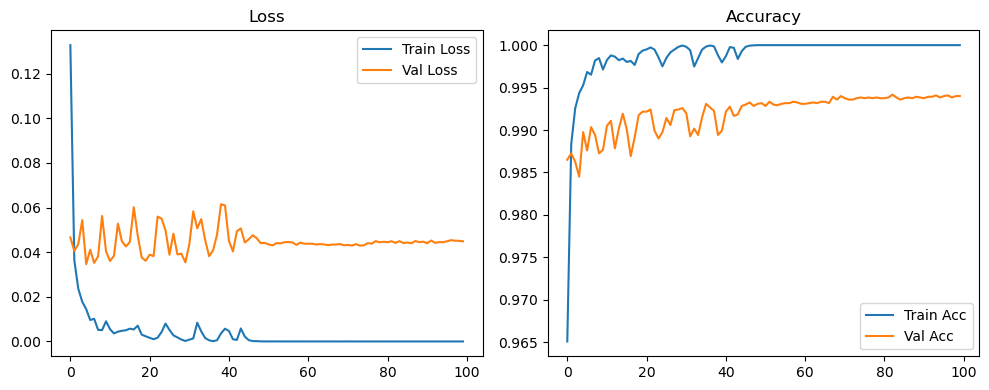

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1520, Acc: 0.9594 | Val Loss: 0.0930, Acc: 0.9724


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9850 | Val Loss: 0.0552, Acc: 0.9832


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9879 | Val Loss: 0.0467, Acc: 0.9868


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.0475, Acc: 0.9860


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9920 | Val Loss: 0.0424, Acc: 0.9873


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.0434, Acc: 0.9868


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.0387, Acc: 0.9889


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9935 | Val Loss: 0.0490, Acc: 0.9862


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0367, Acc: 0.9900


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9951 | Val Loss: 0.0310, Acc: 0.9915


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0328, Acc: 0.9904


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0361, Acc: 0.9911


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0360, Acc: 0.9917


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0345, Acc: 0.9904


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0328, Acc: 0.9910


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0333, Acc: 0.9918


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0364, Acc: 0.9902


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0553, Acc: 0.9875


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0478, Acc: 0.9881


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0326, Acc: 0.9914


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0391, Acc: 0.9903


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0411, Acc: 0.9905


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0359, Acc: 0.9910


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0487, Acc: 0.9881


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.0382, Acc: 0.9907


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0357, Acc: 0.9922


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0366, Acc: 0.9928


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9981 | Val Loss: 0.0377, Acc: 0.9927


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0339, Acc: 0.9916


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0350, Acc: 0.9918


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0360, Acc: 0.9924


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0375, Acc: 0.9914


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0371, Acc: 0.9915


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0407, Acc: 0.9910


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0325, Acc: 0.9926


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0366, Acc: 0.9919


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0368, Acc: 0.9913


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0313, Acc: 0.9927


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0386, Acc: 0.9922


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0326, Acc: 0.9933


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0352, Acc: 0.9920


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0374, Acc: 0.9914


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0410, Acc: 0.9915


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0370, Acc: 0.9915


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0354, Acc: 0.9922


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0409, Acc: 0.9910


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0387, Acc: 0.9922


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0396, Acc: 0.9919


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0382, Acc: 0.9923


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0434, Acc: 0.9921


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0358, Acc: 0.9928


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0349, Acc: 0.9932


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0356, Acc: 0.9930


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0350, Acc: 0.9932


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0359, Acc: 0.9931


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0355, Acc: 0.9930


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0357, Acc: 0.9930


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0346, Acc: 0.9934


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0360, Acc: 0.9932


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0360, Acc: 0.9935


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0350, Acc: 0.9937


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0361, Acc: 0.9931


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0352, Acc: 0.9937


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0357, Acc: 0.9936


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0362, Acc: 0.9935


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0351, Acc: 0.9938


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0353, Acc: 0.9939


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0357, Acc: 0.9938


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0352, Acc: 0.9938


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0383, Acc: 0.9934


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0347, Acc: 0.9938


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0373, Acc: 0.9937


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0351, Acc: 0.9938


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0382, Acc: 0.9937


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0385, Acc: 0.9930


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0387, Acc: 0.9934


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0356, Acc: 0.9940


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0358, Acc: 0.9939


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0356, Acc: 0.9941


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0353, Acc: 0.9936


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0359, Acc: 0.9938


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0377, Acc: 0.9937


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0366, Acc: 0.9939


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0383, Acc: 0.9933


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0355, Acc: 0.9936


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0352, Acc: 0.9941


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0354, Acc: 0.9942


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0356, Acc: 0.9947


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0367, Acc: 0.9939


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0368, Acc: 0.9937


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9942


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0368, Acc: 0.9942


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0344, Acc: 0.9941


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9938


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0366, Acc: 0.9934


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0371, Acc: 0.9940


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0374, Acc: 0.9937


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0361, Acc: 0.9941


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9938


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0350, Acc: 0.9943


Final Test Loss: 0.0278 Accuracy: 0.9938


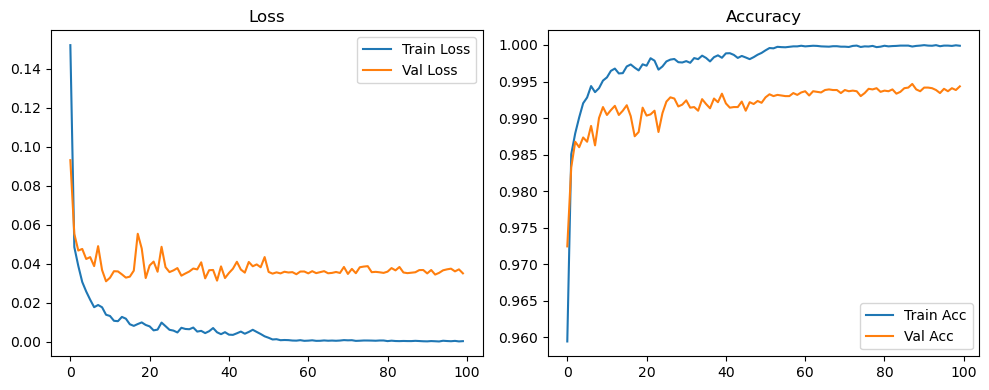

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2161, Acc: 0.9412 | Val Loss: 0.3053, Acc: 0.9018


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0876, Acc: 0.9738 | Val Loss: 0.0983, Acc: 0.9768


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9785 | Val Loss: 0.1009, Acc: 0.9747


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9814 | Val Loss: 0.0840, Acc: 0.9792


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9834 | Val Loss: 0.0740, Acc: 0.9810


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9844 | Val Loss: 0.0548, Acc: 0.9859


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9850 | Val Loss: 0.0517, Acc: 0.9868


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9864 | Val Loss: 0.0449, Acc: 0.9884


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9873 | Val Loss: 0.0497, Acc: 0.9861


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9885 | Val Loss: 0.0410, Acc: 0.9896


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9874 | Val Loss: 0.0444, Acc: 0.9885


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9884 | Val Loss: 0.0484, Acc: 0.9866


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9893 | Val Loss: 0.0383, Acc: 0.9893


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9891 | Val Loss: 0.0435, Acc: 0.9872


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9889 | Val Loss: 0.0368, Acc: 0.9889


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.0459, Acc: 0.9866


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9892 | Val Loss: 0.0336, Acc: 0.9908


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9905 | Val Loss: 0.0506, Acc: 0.9851


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.0357, Acc: 0.9898


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0378, Acc: 0.9883


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 0.0375, Acc: 0.9892


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.0368, Acc: 0.9896


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9916 | Val Loss: 0.0384, Acc: 0.9884


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9906 | Val Loss: 0.0290, Acc: 0.9918


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.0418, Acc: 0.9891


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9913 | Val Loss: 0.0313, Acc: 0.9917


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.0333, Acc: 0.9903


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.0328, Acc: 0.9904


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9922 | Val Loss: 0.0278, Acc: 0.9922


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.0366, Acc: 0.9882


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.0344, Acc: 0.9901


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9920 | Val Loss: 0.0357, Acc: 0.9899


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.0410, Acc: 0.9875


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.0362, Acc: 0.9893


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.0418, Acc: 0.9888


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.0330, Acc: 0.9906


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.0329, Acc: 0.9910


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.0325, Acc: 0.9907


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0324, Acc: 0.9902


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9930 | Val Loss: 0.0257, Acc: 0.9928


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0328, Acc: 0.9907


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9937 | Val Loss: 0.0278, Acc: 0.9922


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0300, Acc: 0.9922


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9937 | Val Loss: 0.0340, Acc: 0.9908


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.0322, Acc: 0.9908


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.0334, Acc: 0.9906


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.0360, Acc: 0.9893


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.0366, Acc: 0.9902


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9936 | Val Loss: 0.0342, Acc: 0.9907


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.0315, Acc: 0.9912


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.0282, Acc: 0.9923


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0274, Acc: 0.9922


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0271, Acc: 0.9925


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0279, Acc: 0.9923


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.0290, Acc: 0.9923


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0304, Acc: 0.9916


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0278, Acc: 0.9928


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0278, Acc: 0.9928


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0285, Acc: 0.9923


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0273, Acc: 0.9930


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0279, Acc: 0.9923


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9964 | Val Loss: 0.0265, Acc: 0.9928


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.0295, Acc: 0.9920


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0278, Acc: 0.9925


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0263, Acc: 0.9932


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0266, Acc: 0.9930


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0292, Acc: 0.9922


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0256, Acc: 0.9933


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0274, Acc: 0.9930


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0267, Acc: 0.9928


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.0267, Acc: 0.9932


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9966 | Val Loss: 0.0273, Acc: 0.9928


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0287, Acc: 0.9928


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0296, Acc: 0.9918


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0309, Acc: 0.9923


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0293, Acc: 0.9924


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0310, Acc: 0.9916


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0303, Acc: 0.9915


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0294, Acc: 0.9923


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0304, Acc: 0.9918


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0319, Acc: 0.9915


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0327, Acc: 0.9918


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0321, Acc: 0.9916


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0332, Acc: 0.9918


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0319, Acc: 0.9918


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0303, Acc: 0.9919


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0295, Acc: 0.9922


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0324, Acc: 0.9915


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0316, Acc: 0.9918


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 0.0296, Acc: 0.9924


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0291, Acc: 0.9923


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0317, Acc: 0.9925


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0295, Acc: 0.9922


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.0294, Acc: 0.9923


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0300, Acc: 0.9926


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0302, Acc: 0.9924


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0304, Acc: 0.9922


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0289, Acc: 0.9925


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.0301, Acc: 0.9926


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0282, Acc: 0.9927


Final Test Loss: 0.0196 Accuracy: 0.9937


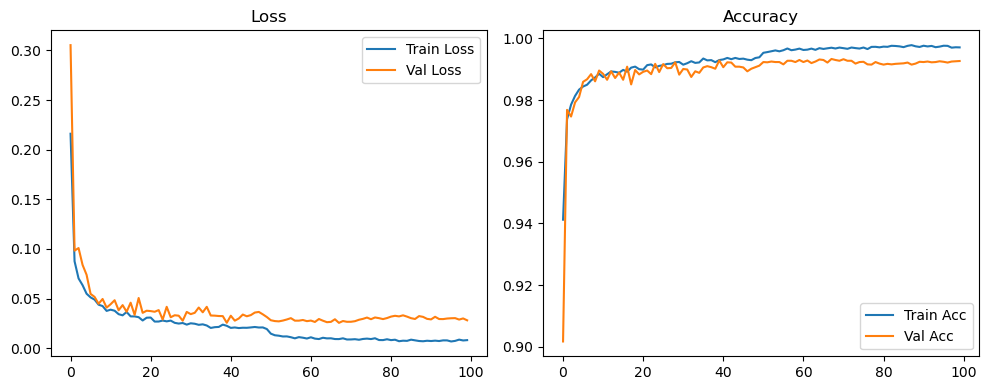

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1461, Acc: 0.9680 | Val Loss: 0.0468, Acc: 0.9862


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9896 | Val Loss: 0.0383, Acc: 0.9878


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9934 | Val Loss: 0.0382, Acc: 0.9881


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9959 | Val Loss: 0.0406, Acc: 0.9879


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.0384, Acc: 0.9886


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0360, Acc: 0.9887


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0345, Acc: 0.9902


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.0339, Acc: 0.9908


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0536, Acc: 0.9858


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0458, Acc: 0.9878


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0442, Acc: 0.9881


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0349, Acc: 0.9907


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0331, Acc: 0.9910


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0294, Acc: 0.9928


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9926


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0317, Acc: 0.9928


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0688, Acc: 0.9858


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.0582, Acc: 0.9861


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0460, Acc: 0.9898


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0360, Acc: 0.9916


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0358, Acc: 0.9918


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0310, Acc: 0.9934


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0308, Acc: 0.9934


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0317, Acc: 0.9932


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0311, Acc: 0.9932


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9932


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9933


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0318, Acc: 0.9932


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0318, Acc: 0.9934


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9934


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9936


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0325, Acc: 0.9937


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9938


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9934


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9934


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9935


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9935


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9932


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9934


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9934


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9937


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9934


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9935


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9936


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0359, Acc: 0.9932


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0360, Acc: 0.9934


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0359, Acc: 0.9932


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9928


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9898 | Val Loss: 0.0384, Acc: 0.9896


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0341, Acc: 0.9910


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0312, Acc: 0.9923


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0321, Acc: 0.9915


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0339, Acc: 0.9916


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0311, Acc: 0.9914


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9917


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0326, Acc: 0.9924


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9920


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0326, Acc: 0.9922


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9922


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9925


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9920


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9922


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9922


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9923


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0354, Acc: 0.9926


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0356, Acc: 0.9923


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0360, Acc: 0.9926


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9924


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9922


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9927


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9927


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9925


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0376, Acc: 0.9924


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9924


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9928


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9941 | Val Loss: 0.0565, Acc: 0.9863


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0439, Acc: 0.9906


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.0329, Acc: 0.9918


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0313, Acc: 0.9925


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9919


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9925


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9922


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0326, Acc: 0.9926


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9926


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0332, Acc: 0.9923


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9929


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9930


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0428, Acc: 0.9921


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.0571, Acc: 0.9892


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.0492, Acc: 0.9914


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9988 | Val Loss: 0.0394, Acc: 0.9922


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0478, Acc: 0.9912


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0397, Acc: 0.9929


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9929


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9934


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9922


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0466, Acc: 0.9912


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9926


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9931


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0378, Acc: 0.9932


Final Test Loss: 0.0328 Accuracy: 0.9926


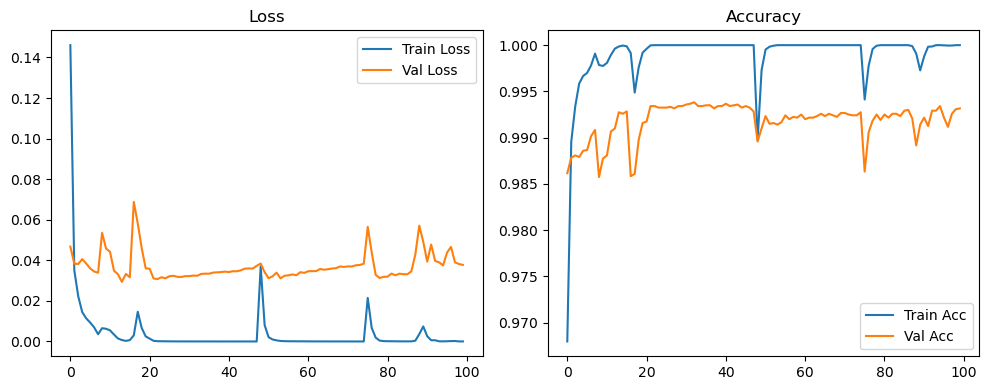

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1664, Acc: 0.9626 | Val Loss: 0.0745, Acc: 0.9795


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9863 | Val Loss: 0.0467, Acc: 0.9860


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9885 | Val Loss: 0.0448, Acc: 0.9865


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9910 | Val Loss: 0.0405, Acc: 0.9882


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.0387, Acc: 0.9881


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.0366, Acc: 0.9882


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0488, Acc: 0.9860


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0392, Acc: 0.9883


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0416, Acc: 0.9888


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0290, Acc: 0.9924


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0410, Acc: 0.9882


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0345, Acc: 0.9909


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0311, Acc: 0.9917


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9961 | Val Loss: 0.0273, Acc: 0.9931


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0289, Acc: 0.9921


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0311, Acc: 0.9922


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0317, Acc: 0.9913


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0361, Acc: 0.9908


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9971 | Val Loss: 0.0317, Acc: 0.9926


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0355, Acc: 0.9910


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0391, Acc: 0.9903


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0393, Acc: 0.9913


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0376, Acc: 0.9903


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0349, Acc: 0.9916


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0430, Acc: 0.9898


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0400, Acc: 0.9898


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0369, Acc: 0.9902


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0351, Acc: 0.9915


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0454, Acc: 0.9894


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0349, Acc: 0.9912


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0359, Acc: 0.9917


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0391, Acc: 0.9898


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0302, Acc: 0.9928


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0368, Acc: 0.9916


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0414, Acc: 0.9905


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0336, Acc: 0.9932


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0403, Acc: 0.9913


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0347, Acc: 0.9919


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0357, Acc: 0.9921


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0393, Acc: 0.9921


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0425, Acc: 0.9914


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9983 | Val Loss: 0.0343, Acc: 0.9923


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0312, Acc: 0.9943


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0345, Acc: 0.9934


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0360, Acc: 0.9930


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0376, Acc: 0.9920


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0379, Acc: 0.9927


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0379, Acc: 0.9924


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0407, Acc: 0.9908


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0459, Acc: 0.9908


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0398, Acc: 0.9929


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0373, Acc: 0.9925


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.0380, Acc: 0.9922


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0371, Acc: 0.9926


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0429, Acc: 0.9912


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0413, Acc: 0.9919


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0419, Acc: 0.9920


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0369, Acc: 0.9931


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0405, Acc: 0.9927


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0373, Acc: 0.9935


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0407, Acc: 0.9927


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0403, Acc: 0.9922


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0373, Acc: 0.9928


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0365, Acc: 0.9934


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0373, Acc: 0.9927


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0368, Acc: 0.9928


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0378, Acc: 0.9936


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0416, Acc: 0.9923


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0455, Acc: 0.9919


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0381, Acc: 0.9928


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0437, Acc: 0.9923


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0426, Acc: 0.9920


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0481, Acc: 0.9911


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0415, Acc: 0.9932


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0443, Acc: 0.9917


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0459, Acc: 0.9921


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0449, Acc: 0.9920


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0420, Acc: 0.9918


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0398, Acc: 0.9933


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0354, Acc: 0.9926


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0402, Acc: 0.9924


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0423, Acc: 0.9922


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0433, Acc: 0.9918


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0412, Acc: 0.9918


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0443, Acc: 0.9921


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0407, Acc: 0.9922


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0365, Acc: 0.9932


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0376, Acc: 0.9928


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0361, Acc: 0.9928


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0355, Acc: 0.9930


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0364, Acc: 0.9938


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0349, Acc: 0.9938


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0379, Acc: 0.9932


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0390, Acc: 0.9921


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0428, Acc: 0.9922


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0371, Acc: 0.9936


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0378, Acc: 0.9941


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0340, Acc: 0.9939


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0370, Acc: 0.9939


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0425, Acc: 0.9921


Final Test Loss: 0.0380 Accuracy: 0.9915


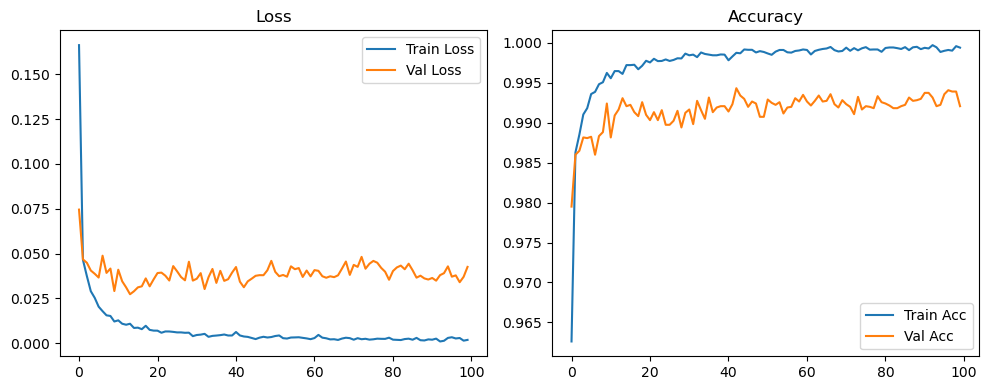

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2361, Acc: 0.9444 | Val Loss: 0.3110, Acc: 0.9022


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0868, Acc: 0.9754 | Val Loss: 0.1212, Acc: 0.9717


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0729, Acc: 0.9785 | Val Loss: 0.0953, Acc: 0.9783


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0625, Acc: 0.9817 | Val Loss: 0.0868, Acc: 0.9788


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9828 | Val Loss: 0.0719, Acc: 0.9819


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9846 | Val Loss: 0.0499, Acc: 0.9893


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9857 | Val Loss: 0.0520, Acc: 0.9865


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9868 | Val Loss: 0.0580, Acc: 0.9839


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9880 | Val Loss: 0.0533, Acc: 0.9848


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9881 | Val Loss: 0.0413, Acc: 0.9892


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.0507, Acc: 0.9862


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9890 | Val Loss: 0.0417, Acc: 0.9888


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9899 | Val Loss: 0.0381, Acc: 0.9902


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9902 | Val Loss: 0.0347, Acc: 0.9906


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9904 | Val Loss: 0.0401, Acc: 0.9883


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9905 | Val Loss: 0.0443, Acc: 0.9875


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9901 | Val Loss: 0.0429, Acc: 0.9884


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9910 | Val Loss: 0.0401, Acc: 0.9888


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0381, Acc: 0.9885


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.0348, Acc: 0.9898


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9914 | Val Loss: 0.0361, Acc: 0.9899


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.0359, Acc: 0.9894


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.0370, Acc: 0.9893


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.0322, Acc: 0.9909


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9925 | Val Loss: 0.0387, Acc: 0.9906


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.0315, Acc: 0.9910


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.0346, Acc: 0.9898


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.0401, Acc: 0.9888


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9928 | Val Loss: 0.0370, Acc: 0.9895


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.0377, Acc: 0.9892


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.0431, Acc: 0.9874


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.0378, Acc: 0.9890


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9932 | Val Loss: 0.0312, Acc: 0.9919


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9935 | Val Loss: 0.0335, Acc: 0.9915


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0388, Acc: 0.9888


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0298, Acc: 0.9908


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.0379, Acc: 0.9897


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0308, Acc: 0.9908


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.0386, Acc: 0.9890


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.0287, Acc: 0.9924


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.0322, Acc: 0.9915


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.0278, Acc: 0.9920


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.0331, Acc: 0.9899


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.0329, Acc: 0.9910


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9936 | Val Loss: 0.0351, Acc: 0.9902


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0367, Acc: 0.9898


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0363, Acc: 0.9886


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0350, Acc: 0.9908


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.0341, Acc: 0.9911


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0419, Acc: 0.9887


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9937 | Val Loss: 0.0340, Acc: 0.9896


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.0300, Acc: 0.9920


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.0345, Acc: 0.9906


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0300, Acc: 0.9912


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0362, Acc: 0.9906


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.0344, Acc: 0.9907


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0372, Acc: 0.9904


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9945 | Val Loss: 0.0351, Acc: 0.9912


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9948 | Val Loss: 0.0362, Acc: 0.9905


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9946 | Val Loss: 0.0370, Acc: 0.9898


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0315, Acc: 0.9918


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0367, Acc: 0.9902


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0374, Acc: 0.9892


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0337, Acc: 0.9906


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.0340, Acc: 0.9904


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0317, Acc: 0.9916


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.0344, Acc: 0.9910


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0373, Acc: 0.9904


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0309, Acc: 0.9915


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0365, Acc: 0.9905


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0308, Acc: 0.9928


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0292, Acc: 0.9925


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0289, Acc: 0.9928


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0334, Acc: 0.9906


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.0335, Acc: 0.9911


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0293, Acc: 0.9925


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0351, Acc: 0.9909


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0323, Acc: 0.9918


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0340, Acc: 0.9915


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0300, Acc: 0.9922


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0386, Acc: 0.9908


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.0361, Acc: 0.9907


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0350, Acc: 0.9906


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0339, Acc: 0.9921


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0359, Acc: 0.9912


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9957 | Val Loss: 0.0420, Acc: 0.9892


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0295, Acc: 0.9922


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.0325, Acc: 0.9916


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9960 | Val Loss: 0.0362, Acc: 0.9908


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0325, Acc: 0.9910


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.0286, Acc: 0.9925


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0342, Acc: 0.9918


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.0308, Acc: 0.9914


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0306, Acc: 0.9916


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0317, Acc: 0.9911


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0337, Acc: 0.9912


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0271, Acc: 0.9924


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.0292, Acc: 0.9923


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0310, Acc: 0.9920


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0309, Acc: 0.9918


Final Test Loss: 0.0249 Accuracy: 0.9927


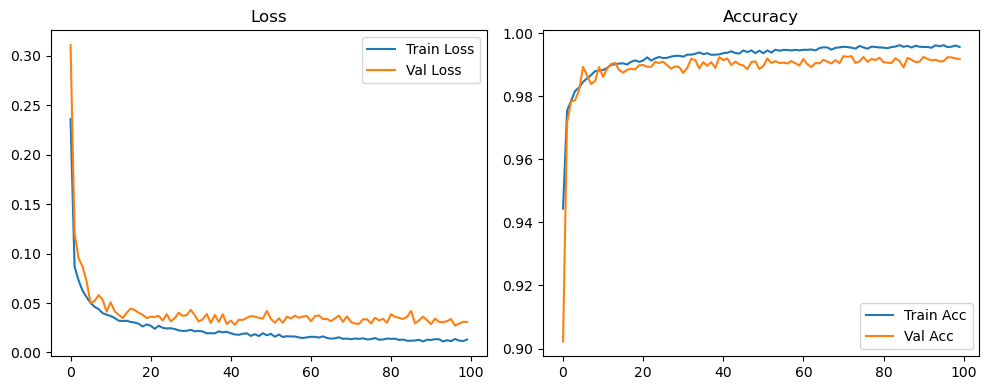

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1462, Acc: 0.9677 | Val Loss: 0.0500, Acc: 0.9853


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9895 | Val Loss: 0.0388, Acc: 0.9882


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9932 | Val Loss: 0.0367, Acc: 0.9888


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9958 | Val Loss: 0.0399, Acc: 0.9882


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.0381, Acc: 0.9888


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0374, Acc: 0.9885


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0334, Acc: 0.9899


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0450, Acc: 0.9885


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0375, Acc: 0.9900


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0353, Acc: 0.9899


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0363, Acc: 0.9908


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0363, Acc: 0.9901


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0442, Acc: 0.9888


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0416, Acc: 0.9895


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.0373, Acc: 0.9908


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0368, Acc: 0.9917


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0323, Acc: 0.9927


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0325, Acc: 0.9928


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0317, Acc: 0.9932


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0311, Acc: 0.9926


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0372, Acc: 0.9912


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0890, Acc: 0.9811


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0416, Acc: 0.9908


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0343, Acc: 0.9917


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0321, Acc: 0.9929


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0325, Acc: 0.9922


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0343, Acc: 0.9930


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0309, Acc: 0.9936


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0303, Acc: 0.9934


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0304, Acc: 0.9938


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0307, Acc: 0.9937


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0307, Acc: 0.9934


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0309, Acc: 0.9931


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0313, Acc: 0.9937


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0316, Acc: 0.9934


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0314, Acc: 0.9935


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9935


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9938


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0320, Acc: 0.9931


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9938


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0320, Acc: 0.9935


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9929


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0323, Acc: 0.9935


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9932


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9932


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9933


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9935


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9930


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9935


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9935


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9933


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0343, Acc: 0.9932


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9934


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0343, Acc: 0.9935


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9932


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0354, Acc: 0.9931


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9932


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9934


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0354, Acc: 0.9932


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9932


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9932


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9931


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.0500, Acc: 0.9899


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0409, Acc: 0.9925


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0425, Acc: 0.9923


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9930


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9928


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9931


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0402, Acc: 0.9931


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9935


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9937


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9937


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0384, Acc: 0.9934


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9933


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9935


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9933


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0388, Acc: 0.9934


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9932


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9936


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9930


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9932


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9932


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9932


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9935


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9930


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9932


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9931


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9933


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9932


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9932


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9933


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9932


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9932


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9935


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9929


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9935


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9934


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9935


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9941


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9932


Final Test Loss: 0.0325 Accuracy: 0.9936


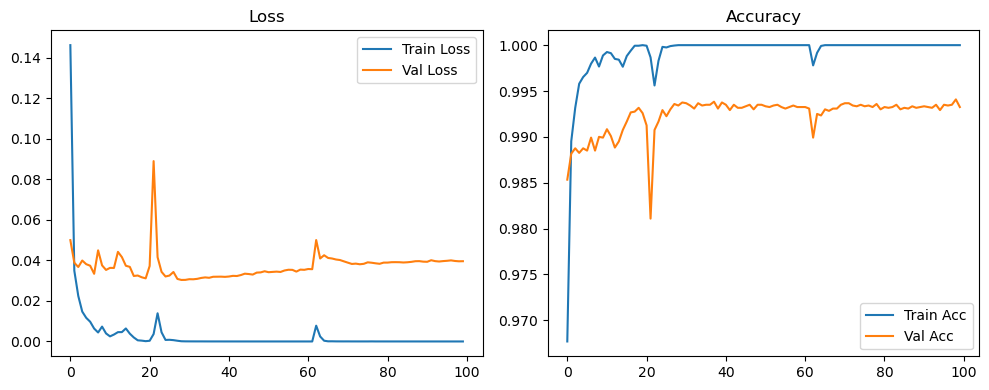

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1663, Acc: 0.9626 | Val Loss: 0.0761, Acc: 0.9790


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9861 | Val Loss: 0.0498, Acc: 0.9857


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9887 | Val Loss: 0.0435, Acc: 0.9876


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9911 | Val Loss: 0.0392, Acc: 0.9888


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9919 | Val Loss: 0.0365, Acc: 0.9889


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.0345, Acc: 0.9891


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9947 | Val Loss: 0.0402, Acc: 0.9888


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.0427, Acc: 0.9876


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0309, Acc: 0.9910


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0275, Acc: 0.9919


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0386, Acc: 0.9888


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0299, Acc: 0.9917


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0322, Acc: 0.9910


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0280, Acc: 0.9923


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0321, Acc: 0.9910


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0299, Acc: 0.9918


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.0309, Acc: 0.9915


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0356, Acc: 0.9902


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0345, Acc: 0.9912


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0332, Acc: 0.9915


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0284, Acc: 0.9918


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0340, Acc: 0.9918


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0359, Acc: 0.9908


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0356, Acc: 0.9918


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0384, Acc: 0.9900


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0355, Acc: 0.9914


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0351, Acc: 0.9916


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0367, Acc: 0.9916


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9981 | Val Loss: 0.0403, Acc: 0.9907


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0292, Acc: 0.9931


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0300, Acc: 0.9934


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0341, Acc: 0.9923


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0326, Acc: 0.9922


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0329, Acc: 0.9927


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0350, Acc: 0.9924


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0370, Acc: 0.9919


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0398, Acc: 0.9919


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0347, Acc: 0.9921


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9980 | Val Loss: 0.0393, Acc: 0.9911


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0333, Acc: 0.9930


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0352, Acc: 0.9919


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0466, Acc: 0.9900


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0325, Acc: 0.9932


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0417, Acc: 0.9921


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0412, Acc: 0.9915


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0352, Acc: 0.9922


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0345, Acc: 0.9931


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0456, Acc: 0.9914


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0380, Acc: 0.9927


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0418, Acc: 0.9914


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0362, Acc: 0.9922


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0360, Acc: 0.9928


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0374, Acc: 0.9924


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0356, Acc: 0.9932


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0338, Acc: 0.9928


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0353, Acc: 0.9923


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0385, Acc: 0.9930


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0338, Acc: 0.9934


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0366, Acc: 0.9932


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0352, Acc: 0.9931


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0370, Acc: 0.9932


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0382, Acc: 0.9929


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0394, Acc: 0.9922


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0372, Acc: 0.9929


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0378, Acc: 0.9925


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0365, Acc: 0.9927


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0417, Acc: 0.9922


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0416, Acc: 0.9923


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0405, Acc: 0.9930


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0413, Acc: 0.9924


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0407, Acc: 0.9925


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0367, Acc: 0.9932


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0374, Acc: 0.9932


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0400, Acc: 0.9932


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0425, Acc: 0.9928


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0391, Acc: 0.9934


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0388, Acc: 0.9933


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0395, Acc: 0.9931


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0380, Acc: 0.9932


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0396, Acc: 0.9922


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0390, Acc: 0.9930


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0403, Acc: 0.9929


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0392, Acc: 0.9922


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0397, Acc: 0.9926


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0384, Acc: 0.9931


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0394, Acc: 0.9932


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0415, Acc: 0.9928


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9928


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0399, Acc: 0.9932


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0405, Acc: 0.9928


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0381, Acc: 0.9935


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0424, Acc: 0.9932


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0369, Acc: 0.9937


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0423, Acc: 0.9920


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0423, Acc: 0.9923


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0409, Acc: 0.9929


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0421, Acc: 0.9932


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0431, Acc: 0.9931


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0418, Acc: 0.9935


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0408, Acc: 0.9935


Final Test Loss: 0.0280 Accuracy: 0.9934


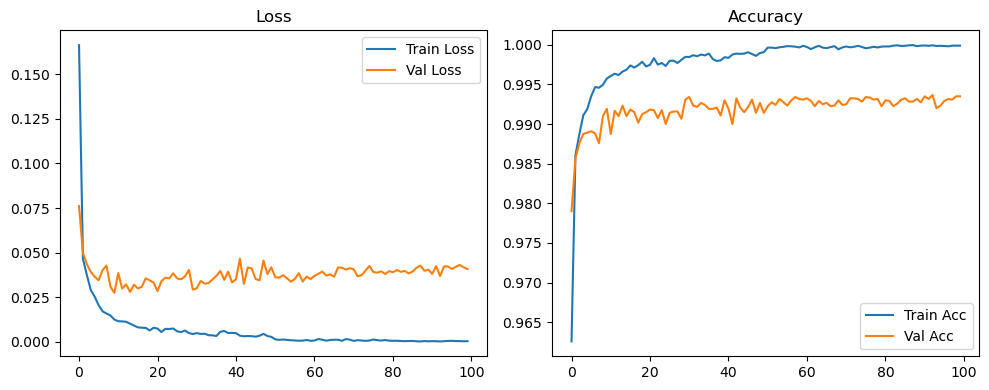

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2361, Acc: 0.9445 | Val Loss: 0.3395, Acc: 0.8882


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0868, Acc: 0.9749 | Val Loss: 0.1212, Acc: 0.9704


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0723, Acc: 0.9785 | Val Loss: 0.0923, Acc: 0.9778


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9814 | Val Loss: 0.0824, Acc: 0.9797


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0553, Acc: 0.9834 | Val Loss: 0.0753, Acc: 0.9814


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0504, Acc: 0.9845 | Val Loss: 0.0487, Acc: 0.9887


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9858 | Val Loss: 0.0521, Acc: 0.9857


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9866 | Val Loss: 0.0520, Acc: 0.9852


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9876 | Val Loss: 0.0537, Acc: 0.9844


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9880 | Val Loss: 0.0362, Acc: 0.9904


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9889 | Val Loss: 0.0445, Acc: 0.9882


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9898 | Val Loss: 0.0382, Acc: 0.9894


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9898 | Val Loss: 0.0370, Acc: 0.9898


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9900 | Val Loss: 0.0344, Acc: 0.9903


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9902 | Val Loss: 0.0358, Acc: 0.9900


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9906 | Val Loss: 0.0427, Acc: 0.9880


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9910 | Val Loss: 0.0364, Acc: 0.9902


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 0.0385, Acc: 0.9898


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.0386, Acc: 0.9895


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.0352, Acc: 0.9898


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9915 | Val Loss: 0.0383, Acc: 0.9888


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.0346, Acc: 0.9908


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9920 | Val Loss: 0.0449, Acc: 0.9871


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0335, Acc: 0.9897


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0420, Acc: 0.9877


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.0328, Acc: 0.9908


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.0348, Acc: 0.9900


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9935 | Val Loss: 0.0370, Acc: 0.9895


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.0341, Acc: 0.9902


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9921 | Val Loss: 0.0409, Acc: 0.9882


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9923 | Val Loss: 0.0353, Acc: 0.9900


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9932 | Val Loss: 0.0404, Acc: 0.9883


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.0357, Acc: 0.9895


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9932 | Val Loss: 0.0429, Acc: 0.9878


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0455, Acc: 0.9866


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9932 | Val Loss: 0.0293, Acc: 0.9911


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9937 | Val Loss: 0.0379, Acc: 0.9892


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0344, Acc: 0.9898


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9930 | Val Loss: 0.0363, Acc: 0.9899


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0293, Acc: 0.9918


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0317, Acc: 0.9912


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.0303, Acc: 0.9912


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0300, Acc: 0.9908


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0331, Acc: 0.9911


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.0370, Acc: 0.9897


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.0352, Acc: 0.9902


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.0344, Acc: 0.9901


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0372, Acc: 0.9893


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.0329, Acc: 0.9909


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.0361, Acc: 0.9898


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.0306, Acc: 0.9915


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0303, Acc: 0.9913


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.0310, Acc: 0.9916


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0294, Acc: 0.9918


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0337, Acc: 0.9912


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0344, Acc: 0.9910


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0345, Acc: 0.9908


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0382, Acc: 0.9899


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0371, Acc: 0.9897


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9960 | Val Loss: 0.0356, Acc: 0.9906


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9960 | Val Loss: 0.0332, Acc: 0.9917


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0382, Acc: 0.9900


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0356, Acc: 0.9902


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0322, Acc: 0.9914


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0345, Acc: 0.9909


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.0338, Acc: 0.9911


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0346, Acc: 0.9905


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0304, Acc: 0.9917


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0369, Acc: 0.9906


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0344, Acc: 0.9911


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0349, Acc: 0.9905


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0311, Acc: 0.9918


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0345, Acc: 0.9906


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0345, Acc: 0.9907


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0344, Acc: 0.9910


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0311, Acc: 0.9917


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0342, Acc: 0.9920


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.0313, Acc: 0.9921


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0328, Acc: 0.9916


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0301, Acc: 0.9918


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0339, Acc: 0.9912


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0344, Acc: 0.9915


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0349, Acc: 0.9914


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.0345, Acc: 0.9914


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0325, Acc: 0.9922


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0354, Acc: 0.9908


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0334, Acc: 0.9914


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.0367, Acc: 0.9907


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0352, Acc: 0.9913


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9975 | Val Loss: 0.0330, Acc: 0.9918


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0324, Acc: 0.9918


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0341, Acc: 0.9916


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0328, Acc: 0.9917


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0315, Acc: 0.9921


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0318, Acc: 0.9919


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0327, Acc: 0.9920


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0338, Acc: 0.9916


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0317, Acc: 0.9915


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9973 | Val Loss: 0.0353, Acc: 0.9909


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0323, Acc: 0.9919


Final Test Loss: 0.0222 Accuracy: 0.9930


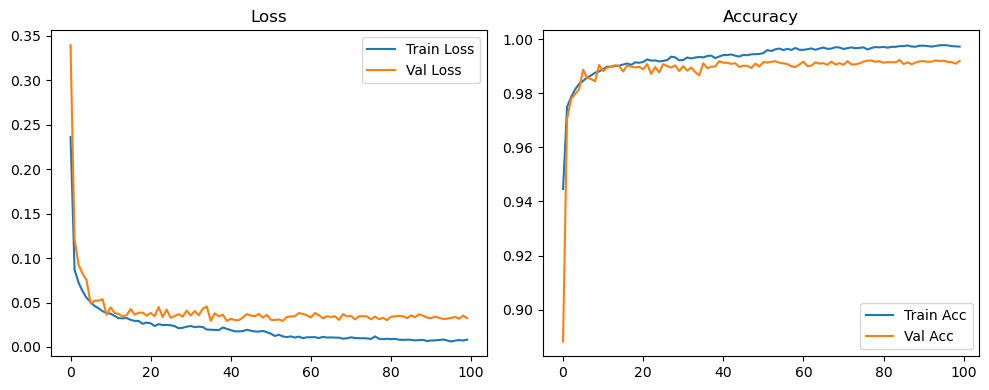

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2008, Acc: 0.9677 | Val Loss: 0.0594, Acc: 0.9861


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9898 | Val Loss: 0.0422, Acc: 0.9872


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9939 | Val Loss: 0.0383, Acc: 0.9892


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9961 | Val Loss: 0.0394, Acc: 0.9876


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9971 | Val Loss: 0.0335, Acc: 0.9898


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9978 | Val Loss: 0.0338, Acc: 0.9894


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9987 | Val Loss: 0.0283, Acc: 0.9915


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9997 | Val Loss: 0.0289, Acc: 0.9915


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9995 | Val Loss: 0.0326, Acc: 0.9910


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9998 | Val Loss: 0.0280, Acc: 0.9924


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9999 | Val Loss: 0.0297, Acc: 0.9918


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0597, Acc: 0.9837


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0311, Acc: 0.9908


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0326, Acc: 0.9908


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9997 | Val Loss: 0.0265, Acc: 0.9927


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0262, Acc: 0.9922


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0272, Acc: 0.9924


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0272, Acc: 0.9923


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0273, Acc: 0.9929


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0270, Acc: 0.9932


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0273, Acc: 0.9929


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0275, Acc: 0.9932


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0276, Acc: 0.9932


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0283, Acc: 0.9932


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0277, Acc: 0.9933


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0282, Acc: 0.9930


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0293, Acc: 0.9930


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0287, Acc: 0.9929


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0288, Acc: 0.9931


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0293, Acc: 0.9932


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0296, Acc: 0.9929


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0291, Acc: 0.9931


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0291, Acc: 0.9933


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0298, Acc: 0.9933


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0304, Acc: 0.9933


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0306, Acc: 0.9931


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0305, Acc: 0.9932


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0310, Acc: 0.9932


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0311, Acc: 0.9933


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0308, Acc: 0.9932


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0315, Acc: 0.9931


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0316, Acc: 0.9935


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0316, Acc: 0.9931


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9932


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0320, Acc: 0.9932


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9932


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9932


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9932


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9933


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9928


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9933


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9935


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9932


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0338, Acc: 0.9932


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9931


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9933


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9932


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9935


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9934


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9934


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9933


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0376, Acc: 0.9934


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9935


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9933


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9937


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0378, Acc: 0.9937


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0378, Acc: 0.9935


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9918 | Val Loss: 0.0527, Acc: 0.9854


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0305, Acc: 0.9912


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0272, Acc: 0.9926


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0292, Acc: 0.9924


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0276, Acc: 0.9932


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0277, Acc: 0.9933


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0275, Acc: 0.9931


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0285, Acc: 0.9931


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0290, Acc: 0.9935


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0292, Acc: 0.9932


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0291, Acc: 0.9937


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0293, Acc: 0.9932


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0300, Acc: 0.9935


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0302, Acc: 0.9938


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0306, Acc: 0.9933


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0308, Acc: 0.9933


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9929


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0979, Acc: 0.9772


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0388, Acc: 0.9896


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0307, Acc: 0.9921


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0300, Acc: 0.9932


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0303, Acc: 0.9935


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0299, Acc: 0.9938


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0295, Acc: 0.9937


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0302, Acc: 0.9936


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0302, Acc: 0.9934


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0300, Acc: 0.9936


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0307, Acc: 0.9938


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0416, Acc: 0.9916


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0389, Acc: 0.9923


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0410, Acc: 0.9902


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0399, Acc: 0.9919


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0444, Acc: 0.9907


Final Test Loss: 0.0328 Accuracy: 0.9915


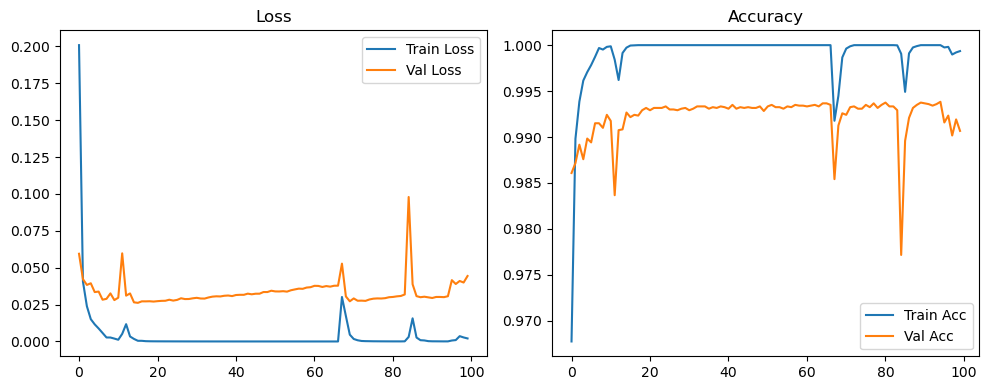

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2264, Acc: 0.9628 | Val Loss: 0.1051, Acc: 0.9762


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0528, Acc: 0.9863 | Val Loss: 0.0629, Acc: 0.9839


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9901 | Val Loss: 0.0502, Acc: 0.9857


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9913 | Val Loss: 0.0379, Acc: 0.9896


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9924 | Val Loss: 0.0385, Acc: 0.9889


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9936 | Val Loss: 0.0377, Acc: 0.9880


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9950 | Val Loss: 0.0378, Acc: 0.9885


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9956 | Val Loss: 0.0337, Acc: 0.9898


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9956 | Val Loss: 0.0371, Acc: 0.9888


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0303, Acc: 0.9909


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0430, Acc: 0.9875


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.0277, Acc: 0.9912


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.0293, Acc: 0.9919


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0285, Acc: 0.9926


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0343, Acc: 0.9907


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0300, Acc: 0.9925


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0315, Acc: 0.9912


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0382, Acc: 0.9892


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0316, Acc: 0.9919


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0345, Acc: 0.9903


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0328, Acc: 0.9910


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0272, Acc: 0.9920


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0313, Acc: 0.9922


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0321, Acc: 0.9913


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0324, Acc: 0.9916


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0317, Acc: 0.9918


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0338, Acc: 0.9912


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0335, Acc: 0.9918


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0325, Acc: 0.9922


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0308, Acc: 0.9917


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0337, Acc: 0.9919


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0325, Acc: 0.9930


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0316, Acc: 0.9931


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0324, Acc: 0.9922


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0342, Acc: 0.9918


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0312, Acc: 0.9927


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0338, Acc: 0.9924


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0308, Acc: 0.9926


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0313, Acc: 0.9930


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0359, Acc: 0.9923


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0345, Acc: 0.9922


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0361, Acc: 0.9920


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0311, Acc: 0.9931


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0330, Acc: 0.9925


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.0351, Acc: 0.9921


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0384, Acc: 0.9920


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0316, Acc: 0.9933


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0373, Acc: 0.9919


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0363, Acc: 0.9922


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0429, Acc: 0.9904


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0412, Acc: 0.9904


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0389, Acc: 0.9924


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0336, Acc: 0.9926


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0355, Acc: 0.9922


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0337, Acc: 0.9933


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0343, Acc: 0.9932


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0342, Acc: 0.9940


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0378, Acc: 0.9918


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0390, Acc: 0.9928


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0329, Acc: 0.9932


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0416, Acc: 0.9919


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0413, Acc: 0.9922


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0355, Acc: 0.9930


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0379, Acc: 0.9928


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0403, Acc: 0.9928


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0343, Acc: 0.9938


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0414, Acc: 0.9926


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0399, Acc: 0.9925


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0317, Acc: 0.9934


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0372, Acc: 0.9928


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0392, Acc: 0.9933


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0377, Acc: 0.9921


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0466, Acc: 0.9915


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0408, Acc: 0.9922


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0410, Acc: 0.9918


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0408, Acc: 0.9926


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0392, Acc: 0.9924


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9990 | Val Loss: 0.0411, Acc: 0.9921


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0379, Acc: 0.9929


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0359, Acc: 0.9929


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0385, Acc: 0.9933


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0408, Acc: 0.9928


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0388, Acc: 0.9930


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0403, Acc: 0.9930


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0394, Acc: 0.9928


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0390, Acc: 0.9932


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0400, Acc: 0.9930


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0385, Acc: 0.9928


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0427, Acc: 0.9928


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0387, Acc: 0.9924


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0413, Acc: 0.9924


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0351, Acc: 0.9934


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0376, Acc: 0.9930


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0413, Acc: 0.9929


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0462, Acc: 0.9914


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0404, Acc: 0.9923


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0440, Acc: 0.9917


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0364, Acc: 0.9930


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0387, Acc: 0.9931


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0403, Acc: 0.9922


Final Test Loss: 0.0322 Accuracy: 0.9931


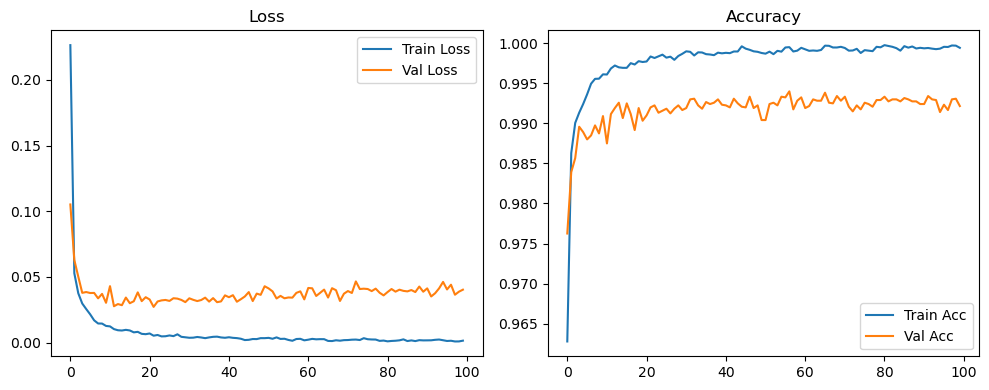

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3158, Acc: 0.9418 | Val Loss: 0.3988, Acc: 0.8869


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0980, Acc: 0.9748 | Val Loss: 0.2024, Acc: 0.9549


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0781, Acc: 0.9776 | Val Loss: 0.1390, Acc: 0.9709


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0647, Acc: 0.9816 | Val Loss: 0.1207, Acc: 0.9714


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0584, Acc: 0.9832 | Val Loss: 0.0835, Acc: 0.9829


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9848 | Val Loss: 0.0628, Acc: 0.9861


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9858 | Val Loss: 0.0893, Acc: 0.9777


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9864 | Val Loss: 0.0513, Acc: 0.9875


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9873 | Val Loss: 0.0715, Acc: 0.9812


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9877 | Val Loss: 0.0456, Acc: 0.9882


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9879 | Val Loss: 0.0551, Acc: 0.9858


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9898 | Val Loss: 0.0552, Acc: 0.9846


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9897 | Val Loss: 0.0561, Acc: 0.9857


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9899 | Val Loss: 0.0569, Acc: 0.9840


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9897 | Val Loss: 0.0422, Acc: 0.9883


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9901 | Val Loss: 0.0548, Acc: 0.9849


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9913 | Val Loss: 0.0400, Acc: 0.9887


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9914 | Val Loss: 0.0524, Acc: 0.9845


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.0433, Acc: 0.9865


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.0407, Acc: 0.9881


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9916 | Val Loss: 0.0510, Acc: 0.9846


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9929 | Val Loss: 0.0440, Acc: 0.9869


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0450, Acc: 0.9867


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9921 | Val Loss: 0.0357, Acc: 0.9895


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0398, Acc: 0.9882


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9929 | Val Loss: 0.0378, Acc: 0.9891


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9931 | Val Loss: 0.0345, Acc: 0.9898


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.0394, Acc: 0.9889


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9932 | Val Loss: 0.0356, Acc: 0.9892


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0359, Acc: 0.9895


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9932 | Val Loss: 0.0396, Acc: 0.9878


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.0391, Acc: 0.9884


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.0382, Acc: 0.9885


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.0360, Acc: 0.9882


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.0442, Acc: 0.9861


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0351, Acc: 0.9897


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0399, Acc: 0.9872


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.0378, Acc: 0.9892


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9941 | Val Loss: 0.0377, Acc: 0.9885


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.0311, Acc: 0.9908


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0438, Acc: 0.9870


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.0383, Acc: 0.9883


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.0343, Acc: 0.9893


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9944 | Val Loss: 0.0373, Acc: 0.9890


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0360, Acc: 0.9891


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.0368, Acc: 0.9888


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.0368, Acc: 0.9890


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0404, Acc: 0.9881


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.0426, Acc: 0.9875


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.0341, Acc: 0.9902


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0328, Acc: 0.9907


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0319, Acc: 0.9905


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0334, Acc: 0.9900


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0323, Acc: 0.9904


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0346, Acc: 0.9906


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.0385, Acc: 0.9885


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.0362, Acc: 0.9902


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.0360, Acc: 0.9892


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0341, Acc: 0.9904


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9952 | Val Loss: 0.0364, Acc: 0.9893


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0363, Acc: 0.9900


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0370, Acc: 0.9900


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9949 | Val Loss: 0.0373, Acc: 0.9892


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.0374, Acc: 0.9894


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9952 | Val Loss: 0.0381, Acc: 0.9894


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0398, Acc: 0.9890


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0406, Acc: 0.9880


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0384, Acc: 0.9888


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0356, Acc: 0.9897


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0366, Acc: 0.9892


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0362, Acc: 0.9898


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0415, Acc: 0.9881


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0485, Acc: 0.9858


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0416, Acc: 0.9880


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0406, Acc: 0.9889


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.0395, Acc: 0.9882


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0408, Acc: 0.9892


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0413, Acc: 0.9886


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0408, Acc: 0.9882


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.0390, Acc: 0.9889


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0382, Acc: 0.9895


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0391, Acc: 0.9902


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0387, Acc: 0.9892


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.0377, Acc: 0.9900


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0419, Acc: 0.9889


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0476, Acc: 0.9869


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0447, Acc: 0.9881


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0558, Acc: 0.9845


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0664, Acc: 0.9818


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0511, Acc: 0.9852


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0464, Acc: 0.9872


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0449, Acc: 0.9878


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9963 | Val Loss: 0.0531, Acc: 0.9867


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0437, Acc: 0.9880


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0478, Acc: 0.9868


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0529, Acc: 0.9861


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0524, Acc: 0.9866


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0545, Acc: 0.9862


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.0575, Acc: 0.9848


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0616, Acc: 0.9843


Final Test Loss: 0.0515 Accuracy: 0.9873


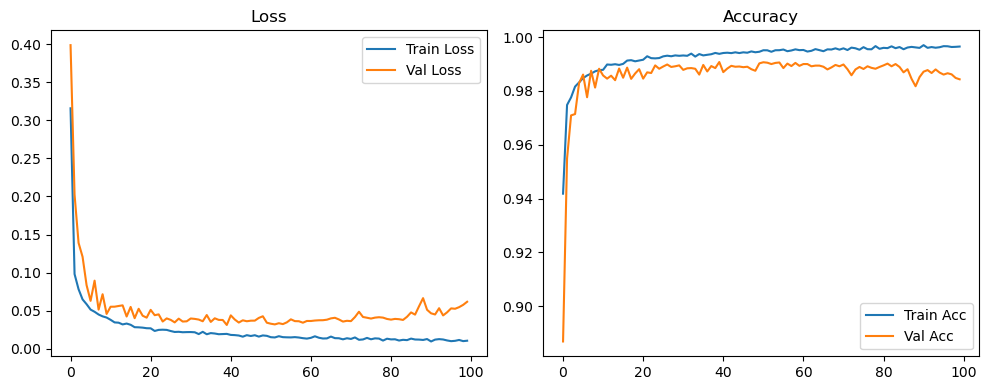

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2848, Acc: 0.9646 | Val Loss: 0.0833, Acc: 0.9845


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0542, Acc: 0.9904 | Val Loss: 0.0458, Acc: 0.9893


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9941 | Val Loss: 0.0423, Acc: 0.9898


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9961 | Val Loss: 0.0445, Acc: 0.9868


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9973 | Val Loss: 0.0335, Acc: 0.9906


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9986 | Val Loss: 0.0357, Acc: 0.9891


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9990 | Val Loss: 0.0291, Acc: 0.9916


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9997 | Val Loss: 0.0293, Acc: 0.9905


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9999 | Val Loss: 0.0309, Acc: 0.9912


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 1.0000 | Val Loss: 0.0266, Acc: 0.9923


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 1.0000 | Val Loss: 0.0267, Acc: 0.9925


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0265, Acc: 0.9924


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0579, Acc: 0.9812


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0346, Acc: 0.9902


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.0281, Acc: 0.9927


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9998 | Val Loss: 0.0269, Acc: 0.9929


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0257, Acc: 0.9930


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0256, Acc: 0.9934


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0258, Acc: 0.9931


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0252, Acc: 0.9938


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0255, Acc: 0.9935


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0259, Acc: 0.9934


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0261, Acc: 0.9937


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0263, Acc: 0.9940


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0262, Acc: 0.9937


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0269, Acc: 0.9937


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0275, Acc: 0.9932


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0272, Acc: 0.9939


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0270, Acc: 0.9937


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0274, Acc: 0.9935


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0280, Acc: 0.9935


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0278, Acc: 0.9938


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0279, Acc: 0.9939


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0282, Acc: 0.9934


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0291, Acc: 0.9936


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0291, Acc: 0.9936


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0289, Acc: 0.9936


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0292, Acc: 0.9938


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0300, Acc: 0.9933


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0296, Acc: 0.9934


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0303, Acc: 0.9936


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0300, Acc: 0.9937


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0299, Acc: 0.9938


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0306, Acc: 0.9935


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0305, Acc: 0.9937


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0308, Acc: 0.9934


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0311, Acc: 0.9933


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0316, Acc: 0.9935


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0322, Acc: 0.9934


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9933


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0321, Acc: 0.9935


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0319, Acc: 0.9933


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9933


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0317, Acc: 0.9934


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0325, Acc: 0.9934


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0332, Acc: 0.9931


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9935


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0337, Acc: 0.9934


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9937


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9933


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9914 | Val Loss: 0.0419, Acc: 0.9888


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.0353, Acc: 0.9908


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0329, Acc: 0.9915


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0296, Acc: 0.9918


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0294, Acc: 0.9925


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0289, Acc: 0.9928


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0295, Acc: 0.9931


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0294, Acc: 0.9932


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0299, Acc: 0.9928


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0298, Acc: 0.9931


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0298, Acc: 0.9929


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0300, Acc: 0.9930


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0300, Acc: 0.9931


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0304, Acc: 0.9930


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0304, Acc: 0.9932


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0307, Acc: 0.9932


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0305, Acc: 0.9932


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0309, Acc: 0.9932


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0311, Acc: 0.9932


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0314, Acc: 0.9932


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0314, Acc: 0.9933


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0315, Acc: 0.9936


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0314, Acc: 0.9933


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0320, Acc: 0.9934


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0315, Acc: 0.9936


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0318, Acc: 0.9933


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0321, Acc: 0.9932


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9933


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9934


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0326, Acc: 0.9937


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0324, Acc: 0.9935


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9937


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9929


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9938


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9934


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9935


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0341, Acc: 0.9938


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0343, Acc: 0.9932


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0337, Acc: 0.9936


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9936


Final Test Loss: 0.0327 Accuracy: 0.9923


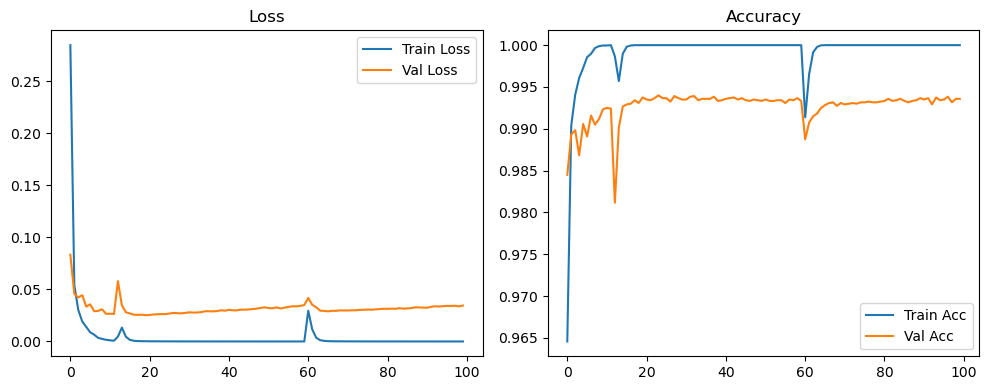

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3204, Acc: 0.9578 | Val Loss: 0.1684, Acc: 0.9748


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0709, Acc: 0.9860 | Val Loss: 0.0974, Acc: 0.9812


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9899 | Val Loss: 0.0662, Acc: 0.9849


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9917 | Val Loss: 0.0496, Acc: 0.9881


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9925 | Val Loss: 0.0454, Acc: 0.9878


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9936 | Val Loss: 0.0405, Acc: 0.9874


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9950 | Val Loss: 0.0393, Acc: 0.9887


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9958 | Val Loss: 0.0328, Acc: 0.9906


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9958 | Val Loss: 0.0403, Acc: 0.9872


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9959 | Val Loss: 0.0314, Acc: 0.9893


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9966 | Val Loss: 0.0372, Acc: 0.9887


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9968 | Val Loss: 0.0322, Acc: 0.9904


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9972 | Val Loss: 0.0326, Acc: 0.9910


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0284, Acc: 0.9911


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.0321, Acc: 0.9903


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9977 | Val Loss: 0.0290, Acc: 0.9913


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.0325, Acc: 0.9902


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0314, Acc: 0.9901


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.0266, Acc: 0.9916


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0301, Acc: 0.9911


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.0277, Acc: 0.9915


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0270, Acc: 0.9921


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0285, Acc: 0.9918


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0274, Acc: 0.9926


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.0289, Acc: 0.9909


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0275, Acc: 0.9923


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0326, Acc: 0.9913


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0302, Acc: 0.9918


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0310, Acc: 0.9911


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0311, Acc: 0.9923


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0289, Acc: 0.9918


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0273, Acc: 0.9924


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0261, Acc: 0.9928


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0294, Acc: 0.9918


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0402, Acc: 0.9898


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0320, Acc: 0.9914


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0384, Acc: 0.9905


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0302, Acc: 0.9920


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0344, Acc: 0.9912


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0306, Acc: 0.9918


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0338, Acc: 0.9916


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0279, Acc: 0.9929


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0276, Acc: 0.9937


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0310, Acc: 0.9917


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0333, Acc: 0.9918


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0335, Acc: 0.9926


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0291, Acc: 0.9928


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0321, Acc: 0.9928


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0316, Acc: 0.9921


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0320, Acc: 0.9913


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0345, Acc: 0.9918


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0333, Acc: 0.9924


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0301, Acc: 0.9929


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0356, Acc: 0.9917


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0336, Acc: 0.9925


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0363, Acc: 0.9919


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0340, Acc: 0.9922


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0359, Acc: 0.9915


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0338, Acc: 0.9920


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0336, Acc: 0.9923


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0334, Acc: 0.9927


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0385, Acc: 0.9916


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0334, Acc: 0.9922


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0330, Acc: 0.9927


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0347, Acc: 0.9921


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0373, Acc: 0.9918


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0330, Acc: 0.9922


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0361, Acc: 0.9919


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0360, Acc: 0.9922


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0334, Acc: 0.9927


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0350, Acc: 0.9927


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0369, Acc: 0.9922


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0382, Acc: 0.9922


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0400, Acc: 0.9923


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0387, Acc: 0.9919


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0345, Acc: 0.9935


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0377, Acc: 0.9922


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0361, Acc: 0.9922


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0343, Acc: 0.9927


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0348, Acc: 0.9928


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0346, Acc: 0.9922


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0338, Acc: 0.9927


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0364, Acc: 0.9925


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0343, Acc: 0.9928


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0328, Acc: 0.9931


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0353, Acc: 0.9932


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0386, Acc: 0.9925


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0396, Acc: 0.9918


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0404, Acc: 0.9925


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0400, Acc: 0.9931


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0354, Acc: 0.9933


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0412, Acc: 0.9920


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0378, Acc: 0.9929


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0414, Acc: 0.9924


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0366, Acc: 0.9927


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0405, Acc: 0.9922


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0413, Acc: 0.9920


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0414, Acc: 0.9918


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0379, Acc: 0.9931


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0415, Acc: 0.9917


Final Test Loss: 0.0330 Accuracy: 0.9926


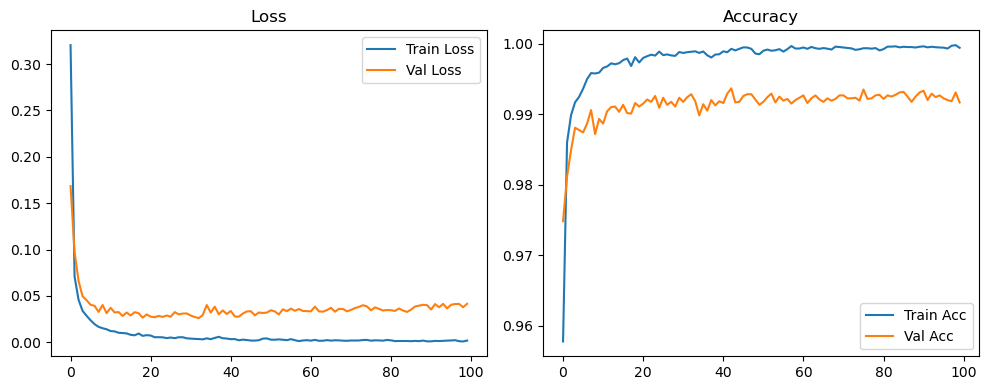

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4382, Acc: 0.9314 | Val Loss: 0.6975, Acc: 0.7514


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1274, Acc: 0.9740 | Val Loss: 0.3432, Acc: 0.9170


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0914, Acc: 0.9774 | Val Loss: 0.2268, Acc: 0.9553


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0741, Acc: 0.9800 | Val Loss: 0.1578, Acc: 0.9694


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0660, Acc: 0.9821 | Val Loss: 0.1400, Acc: 0.9712


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0571, Acc: 0.9846 | Val Loss: 0.1152, Acc: 0.9736


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0544, Acc: 0.9844 | Val Loss: 0.1255, Acc: 0.9673


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9858 | Val Loss: 0.0772, Acc: 0.9830


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0460, Acc: 0.9863 | Val Loss: 0.1031, Acc: 0.9741


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0457, Acc: 0.9863 | Val Loss: 0.0703, Acc: 0.9846


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9873 | Val Loss: 0.0731, Acc: 0.9811


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9884 | Val Loss: 0.0628, Acc: 0.9852


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9895 | Val Loss: 0.0746, Acc: 0.9822


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9895 | Val Loss: 0.0663, Acc: 0.9832


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9899 | Val Loss: 0.0654, Acc: 0.9830


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9898 | Val Loss: 0.0584, Acc: 0.9847


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9906 | Val Loss: 0.0530, Acc: 0.9858


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9905 | Val Loss: 0.0463, Acc: 0.9885


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9907 | Val Loss: 0.0466, Acc: 0.9878


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9912 | Val Loss: 0.0460, Acc: 0.9879


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9912 | Val Loss: 0.0565, Acc: 0.9842


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9922 | Val Loss: 0.0397, Acc: 0.9896


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9912 | Val Loss: 0.0375, Acc: 0.9900


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9921 | Val Loss: 0.0347, Acc: 0.9910


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9916 | Val Loss: 0.0450, Acc: 0.9865


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9922 | Val Loss: 0.0380, Acc: 0.9898


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9924 | Val Loss: 0.0382, Acc: 0.9892


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9928 | Val Loss: 0.0387, Acc: 0.9892


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9926 | Val Loss: 0.0427, Acc: 0.9867


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9928 | Val Loss: 0.0446, Acc: 0.9862


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9930 | Val Loss: 0.0425, Acc: 0.9871


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9929 | Val Loss: 0.0391, Acc: 0.9882


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9932 | Val Loss: 0.0391, Acc: 0.9882


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.0344, Acc: 0.9900


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.0416, Acc: 0.9877


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0380, Acc: 0.9888


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9940 | Val Loss: 0.0406, Acc: 0.9879


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0370, Acc: 0.9892


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0356, Acc: 0.9899


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0332, Acc: 0.9894


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0416, Acc: 0.9881


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9942 | Val Loss: 0.0354, Acc: 0.9891


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0343, Acc: 0.9895


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9945 | Val Loss: 0.0414, Acc: 0.9884


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9945 | Val Loss: 0.0357, Acc: 0.9902


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.0346, Acc: 0.9897


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.0378, Acc: 0.9892


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0358, Acc: 0.9898


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.0370, Acc: 0.9894


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.0352, Acc: 0.9896


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0304, Acc: 0.9915


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.0309, Acc: 0.9912


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0331, Acc: 0.9907


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0335, Acc: 0.9901


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.0377, Acc: 0.9898


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9955 | Val Loss: 0.0322, Acc: 0.9909


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0333, Acc: 0.9904


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0308, Acc: 0.9905


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0351, Acc: 0.9890


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.0329, Acc: 0.9902


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.0346, Acc: 0.9898


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.0397, Acc: 0.9888


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0301, Acc: 0.9909


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0337, Acc: 0.9894


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0382, Acc: 0.9893


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.0345, Acc: 0.9898


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9958 | Val Loss: 0.0312, Acc: 0.9914


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0334, Acc: 0.9899


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.0362, Acc: 0.9890


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.0324, Acc: 0.9904


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0315, Acc: 0.9905


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0395, Acc: 0.9875


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.0366, Acc: 0.9896


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.0309, Acc: 0.9913


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.0332, Acc: 0.9899


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0339, Acc: 0.9909


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0368, Acc: 0.9898


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0337, Acc: 0.9904


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0378, Acc: 0.9894


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0341, Acc: 0.9899


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0299, Acc: 0.9916


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.0355, Acc: 0.9898


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0332, Acc: 0.9900


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.0318, Acc: 0.9912


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0349, Acc: 0.9895


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0336, Acc: 0.9902


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9955 | Val Loss: 0.0341, Acc: 0.9906


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0378, Acc: 0.9888


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0428, Acc: 0.9884


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0355, Acc: 0.9902


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0331, Acc: 0.9908


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0391, Acc: 0.9890


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0408, Acc: 0.9882


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0329, Acc: 0.9912


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0380, Acc: 0.9896


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0384, Acc: 0.9897


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0396, Acc: 0.9895


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0371, Acc: 0.9901


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0394, Acc: 0.9901


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0392, Acc: 0.9885


Final Test Loss: 0.0280 Accuracy: 0.9922


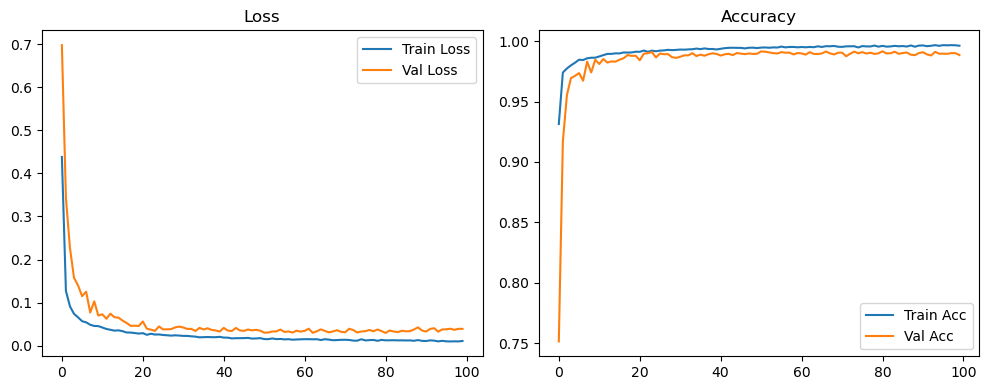

🏆 Best Config: batch256_lr0.01_0.005_0.001_dp0.5 Accuracy: 0.9944


In [8]:
root_path = "TCV_float_regular_SiLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)